In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2

from Model.model_hgsr import HourGlassNetMultiScaleInt
from loss import get_content_loss, GW_loss
from simplenet import simpleNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Data

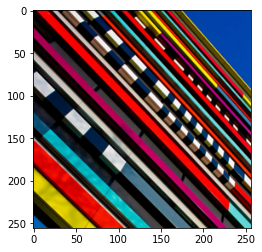

In [2]:
#X = cv2.imread('/home/mandalinadagi/Desktop/comp511/img001x4.png')
#Y = cv2.imread('/home/mandalinadagi/Desktop/comp511/img001.png')
X = cv2.imread('/home/emrecan/Desktop/Comp411/data/Urban100/img_081_SRF_4_LR.png')[:,:,::-1]
Y = cv2.imread('/home/emrecan/Desktop/Comp411/data/Urban100/img_081_SRF_4_HR.png')[:,:,::-1]
output_file = '/home/emrecan/Desktop/Comp411/data/results/Urban100/img_003_SRF_4.png'
plt.imshow(X);

float64
X: (256, 256, 3)
Y: (1024, 1024, 3)


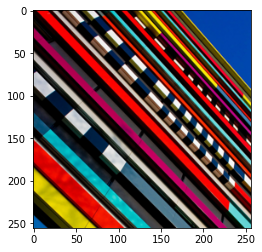

In [3]:
wx, hx, c = X.shape
wx = (wx//4)*4
hx = (hx//4)*4
X = X[:wx, :hx, :]
Y = Y[:(4*wx), :(4*hx), :]
X_original = X
Y_original = Y
X = X.astype(float)
Y = Y.astype(float)
X /= 255.0
Y /= 255.0
print(X.dtype)
plt.imshow(X);
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


lr_son: (64, 64, 3)


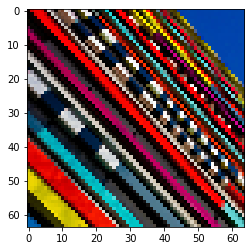

In [4]:
# Bi-CUBIC interpolation
lr_son = cv2.resize(X, None,fx=0.25, fy=0.25, interpolation=cv2.INTER_CUBIC)
plt.imshow(lr_son);
print(f"lr_son: {lr_son.shape}")

In [5]:
lr_son_tensor = torch.FloatTensor(lr_son)
lr_father_tensor = torch.FloatTensor(X)
HR_tensor = torch.FloatTensor(Y)
print(f"lr_son_tensor type: {lr_son_tensor.type()}, lr_father_tensor type: {lr_father_tensor.type()}, HR_tensor type: {HR_tensor.type()}")

lr_son_tensor type: torch.FloatTensor, lr_father_tensor type: torch.FloatTensor, HR_tensor type: torch.FloatTensor


In [6]:
print(f"lr_son: {lr_son_tensor.shape}, lr_father: {lr_father_tensor.shape}, HR: {HR_tensor.shape}")
lr_son, lr_father, HR = lr_son_tensor.unsqueeze(0), lr_father_tensor.unsqueeze(0), HR_tensor.unsqueeze(0)
print(f"lr_son: {lr_son.shape}, lr_father: {lr_father.shape}, HR: {HR.shape}")

lr_son: torch.Size([42, 64, 3]), lr_father: torch.Size([168, 256, 3]), HR: torch.Size([672, 1024, 3])
lr_son: torch.Size([1, 42, 64, 3]), lr_father: torch.Size([1, 168, 256, 3]), HR: torch.Size([1, 672, 1024, 3])


In [7]:
lr_son, lr_father, HR = lr_son.permute(0, 3, 1, 2), lr_father.permute(0, 3, 1, 2), HR.permute(0, 3, 1, 2)
print(f"lr_son: {lr_son.shape}, lr_father: {lr_father.shape}, HR: {HR.shape}")

lr_son: torch.Size([1, 3, 42, 64]), lr_father: torch.Size([1, 3, 168, 256]), HR: torch.Size([1, 3, 672, 1024])


# Training

In [8]:
EPOCHS = 30000
LR = 2e-5

In [9]:
# model = HourGlassNetMultiScaleInt(in_nc=3, 
#                                   out_nc=3, 
#                                   upscale=4,
#                                   nf=64,  
#                                   n_mid=1,
#                                  )
model = simpleNet()
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
inte_loss_weight = torch.Tensor([1.0, 2.0, 5.0, 1.0])
content_criterion = get_content_loss("L2", nn_func=False, use_cuda=True)

In [10]:
for epoch in range(EPOCHS):
    
    lr_FATHER = (0.257*lr_father[:, :1, :, :] + 0.564*lr_father[:, 1:2, :, :] + 0.098*lr_father[:, 2:, :, :] + 16/255.0) * 255.0
    map_corner = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    map_edge = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    map_flat = lr_FATHER.new(lr_FATHER.shape).fill_(0)
    lr_FATHER_numpy = np.transpose(lr_FATHER.numpy(), (0, 2, 3, 1))
    for i in range(lr_FATHER_numpy.shape[0]):
        dst = cv2.cornerHarris(lr_FATHER_numpy[i, :, :, 0], 3, 3, 0.04)
        thres1 = 0.01*dst.max()
        thres2 = -0.001*dst.max()
        map_corner[i, :, :, :] = torch.from_numpy(np.float32(dst > thres1))
        map_edge[i, :, :, :] = torch.from_numpy(np.float32(dst < thres2))
        map_flat[i, :, :, :] = torch.from_numpy(np.float32((dst > thres2) & (dst < thres1)))
    map_corner = map_corner.to(device)
    map_edge = map_edge.to(device)
    map_flat = map_flat.to(device)
    coe_list = []
    coe_list.append(map_flat)
    coe_list.append(map_edge)
    coe_list.append(map_corner)
    
#     sr_var, SR_map = model(lr_son.to(device))
    sr_var = model(lr_son.to(device))
    
    sr_loss = 0
    if isinstance(sr_var, list):
        #sr_loss = 0
        for i in range(len(sr_var)):
            if i != len(sr_var) - 1:
                coe = coe_list[i].to(device)
#                 print(coe.shape)
#                 print(sr_var[i].shape)
#                 print(lr_father.shape)
#                 print(lr_father.dtype)
                single_srloss = inte_loss_weight[i] * content_criterion(coe*sr_var[i], coe*(lr_father.to(device)))
            else:
                single_srloss = inte_loss_weight[i] * GW_loss(sr_var[i], (lr_father.to(device)))
            sr_loss += single_srloss
    else:
        sr_loss = content_criterion(sr_var, (lr_father.to(device)))
        
    optimizer.zero_grad()
    sr_loss.backward()
    optimizer.step()
    #scheduler.step(sr_loss)
    print(f"Epoch: {epoch}/{EPOCHS}, loss:{sr_loss}")

Epoch: 0/30000, loss:0.20747436583042145
Epoch: 1/30000, loss:0.20021599531173706
Epoch: 2/30000, loss:0.19339551031589508
Epoch: 3/30000, loss:0.18700610101222992
Epoch: 4/30000, loss:0.1810302585363388
Epoch: 5/30000, loss:0.17544779181480408
Epoch: 6/30000, loss:0.17022469639778137
Epoch: 7/30000, loss:0.16529017686843872
Epoch: 8/30000, loss:0.16058611869812012
Epoch: 9/30000, loss:0.15608665347099304
Epoch: 10/30000, loss:0.1517464816570282
Epoch: 11/30000, loss:0.14755064249038696
Epoch: 12/30000, loss:0.14347051084041595
Epoch: 13/30000, loss:0.1394965946674347
Epoch: 14/30000, loss:0.13561367988586426
Epoch: 15/30000, loss:0.13181087374687195
Epoch: 16/30000, loss:0.12811718881130219
Epoch: 17/30000, loss:0.12458780407905579
Epoch: 18/30000, loss:0.12125740945339203
Epoch: 19/30000, loss:0.11814538389444351
Epoch: 20/30000, loss:0.11526507884263992
Epoch: 21/30000, loss:0.11261308193206787
Epoch: 22/30000, loss:0.11018019914627075
Epoch: 23/30000, loss:0.10794532299041748
Epoch

Epoch: 210/30000, loss:0.022036615759134293
Epoch: 211/30000, loss:0.021979840472340584
Epoch: 212/30000, loss:0.021923471242189407
Epoch: 213/30000, loss:0.021867388859391212
Epoch: 214/30000, loss:0.021811649203300476
Epoch: 215/30000, loss:0.021756237372756004
Epoch: 216/30000, loss:0.02170122042298317
Epoch: 217/30000, loss:0.021646693348884583
Epoch: 218/30000, loss:0.021592698991298676
Epoch: 219/30000, loss:0.021539177745580673
Epoch: 220/30000, loss:0.021485935896635056
Epoch: 221/30000, loss:0.021433113142848015
Epoch: 222/30000, loss:0.021380722522735596
Epoch: 223/30000, loss:0.021328775212168694
Epoch: 224/30000, loss:0.02127724327147007
Epoch: 225/30000, loss:0.021226217970252037
Epoch: 226/30000, loss:0.021175600588321686
Epoch: 227/30000, loss:0.02112540788948536
Epoch: 228/30000, loss:0.02107555978000164
Epoch: 229/30000, loss:0.021026114001870155
Epoch: 230/30000, loss:0.02097698673605919
Epoch: 231/30000, loss:0.020928138867020607
Epoch: 232/30000, loss:0.020879616960

Epoch: 425/30000, loss:0.015050100162625313
Epoch: 426/30000, loss:0.015029997564852238
Epoch: 427/30000, loss:0.015009919181466103
Epoch: 428/30000, loss:0.014989888295531273
Epoch: 429/30000, loss:0.01496991515159607
Epoch: 430/30000, loss:0.014949928037822247
Epoch: 431/30000, loss:0.01492998469620943
Epoch: 432/30000, loss:0.014910110272467136
Epoch: 433/30000, loss:0.014890183694660664
Epoch: 434/30000, loss:0.014870282262563705
Epoch: 435/30000, loss:0.014850441366434097
Epoch: 436/30000, loss:0.014830619096755981
Epoch: 437/30000, loss:0.014810831286013126
Epoch: 438/30000, loss:0.014791068620979786
Epoch: 439/30000, loss:0.014771327376365662
Epoch: 440/30000, loss:0.01475165132433176
Epoch: 441/30000, loss:0.014732029289007187
Epoch: 442/30000, loss:0.014712413772940636
Epoch: 443/30000, loss:0.014692779630422592
Epoch: 444/30000, loss:0.014673134312033653
Epoch: 445/30000, loss:0.014653516933321953
Epoch: 446/30000, loss:0.01463395170867443
Epoch: 447/30000, loss:0.01461440231

Epoch: 625/30000, loss:0.011890263296663761
Epoch: 626/30000, loss:0.01187793631106615
Epoch: 627/30000, loss:0.011865910142660141
Epoch: 628/30000, loss:0.011854159645736217
Epoch: 629/30000, loss:0.01184253953397274
Epoch: 630/30000, loss:0.011831020936369896
Epoch: 631/30000, loss:0.011819345876574516
Epoch: 632/30000, loss:0.011807454749941826
Epoch: 633/30000, loss:0.011795398779213428
Epoch: 634/30000, loss:0.011783339083194733
Epoch: 635/30000, loss:0.011771433986723423
Epoch: 636/30000, loss:0.011759722605347633
Epoch: 637/30000, loss:0.011748182587325573
Epoch: 638/30000, loss:0.011736728250980377
Epoch: 639/30000, loss:0.011725367046892643
Epoch: 640/30000, loss:0.011714061722159386
Epoch: 641/30000, loss:0.011702684685587883
Epoch: 642/30000, loss:0.01169116236269474
Epoch: 643/30000, loss:0.011679527349770069
Epoch: 644/30000, loss:0.011667687445878983
Epoch: 645/30000, loss:0.011655917391180992
Epoch: 646/30000, loss:0.011644191108644009
Epoch: 647/30000, loss:0.0116325868

Epoch: 822/30000, loss:0.009858589619398117
Epoch: 823/30000, loss:0.009849241934716702
Epoch: 824/30000, loss:0.009840575978159904
Epoch: 825/30000, loss:0.009832438081502914
Epoch: 826/30000, loss:0.009824630804359913
Epoch: 827/30000, loss:0.009816792793571949
Epoch: 828/30000, loss:0.009808533824980259
Epoch: 829/30000, loss:0.009799551218748093
Epoch: 830/30000, loss:0.009790025651454926
Epoch: 831/30000, loss:0.009780137799680233
Epoch: 832/30000, loss:0.009770503267645836
Epoch: 833/30000, loss:0.009761291556060314
Epoch: 834/30000, loss:0.009752548299729824
Epoch: 835/30000, loss:0.009744236245751381
Epoch: 836/30000, loss:0.009736137464642525
Epoch: 837/30000, loss:0.009728144854307175
Epoch: 838/30000, loss:0.009719982743263245
Epoch: 839/30000, loss:0.00971156544983387
Epoch: 840/30000, loss:0.009702683426439762
Epoch: 841/30000, loss:0.009693466126918793
Epoch: 842/30000, loss:0.009684017859399319
Epoch: 843/30000, loss:0.009674708358943462
Epoch: 844/30000, loss:0.00966560

Epoch: 1026/30000, loss:0.00828651525080204
Epoch: 1027/30000, loss:0.008278708904981613
Epoch: 1028/30000, loss:0.00827114749699831
Epoch: 1029/30000, loss:0.008263874799013138
Epoch: 1030/30000, loss:0.008256970904767513
Epoch: 1031/30000, loss:0.008250408805906773
Epoch: 1032/30000, loss:0.008244019001722336
Epoch: 1033/30000, loss:0.008237836882472038
Epoch: 1034/30000, loss:0.00823186058551073
Epoch: 1035/30000, loss:0.008226160891354084
Epoch: 1036/30000, loss:0.008220834657549858
Epoch: 1037/30000, loss:0.008215731009840965
Epoch: 1038/30000, loss:0.008210726082324982
Epoch: 1039/30000, loss:0.008205302990972996
Epoch: 1040/30000, loss:0.008199356496334076
Epoch: 1041/30000, loss:0.008192573674023151
Epoch: 1042/30000, loss:0.008184901438653469
Epoch: 1043/30000, loss:0.008176601491868496
Epoch: 1044/30000, loss:0.008168285712599754
Epoch: 1045/30000, loss:0.008160526864230633
Epoch: 1046/30000, loss:0.008153596892952919
Epoch: 1047/30000, loss:0.008147519081830978
Epoch: 1048/3

Epoch: 1216/30000, loss:0.007182406727224588
Epoch: 1217/30000, loss:0.007176417391747236
Epoch: 1218/30000, loss:0.0071710022166371346
Epoch: 1219/30000, loss:0.00716599402949214
Epoch: 1220/30000, loss:0.007161369081586599
Epoch: 1221/30000, loss:0.00715698953717947
Epoch: 1222/30000, loss:0.0071528139524161816
Epoch: 1223/30000, loss:0.007148932199925184
Epoch: 1224/30000, loss:0.007145026698708534
Epoch: 1225/30000, loss:0.0071410248056054115
Epoch: 1226/30000, loss:0.007136733271181583
Epoch: 1227/30000, loss:0.007132058031857014
Epoch: 1228/30000, loss:0.00712664145976305
Epoch: 1229/30000, loss:0.0071206833235919476
Epoch: 1230/30000, loss:0.007114199921488762
Epoch: 1231/30000, loss:0.007107635959982872
Epoch: 1232/30000, loss:0.007101337891072035
Epoch: 1233/30000, loss:0.007095586974173784
Epoch: 1234/30000, loss:0.007090323138982058
Epoch: 1235/30000, loss:0.007085415534675121
Epoch: 1236/30000, loss:0.007080819923430681
Epoch: 1237/30000, loss:0.0070765381678938866
Epoch: 1

Epoch: 1420/30000, loss:0.00626686355099082
Epoch: 1421/30000, loss:0.0062625957652926445
Epoch: 1422/30000, loss:0.006257368717342615
Epoch: 1423/30000, loss:0.006251699756830931
Epoch: 1424/30000, loss:0.006245627533644438
Epoch: 1425/30000, loss:0.006239881739020348
Epoch: 1426/30000, loss:0.00623461976647377
Epoch: 1427/30000, loss:0.006229889113456011
Epoch: 1428/30000, loss:0.006225718185305595
Epoch: 1429/30000, loss:0.0062219505198299885
Epoch: 1430/30000, loss:0.0062184520065784454
Epoch: 1431/30000, loss:0.00621531018987298
Epoch: 1432/30000, loss:0.0062124901451170444
Epoch: 1433/30000, loss:0.0062101297080516815
Epoch: 1434/30000, loss:0.006207783240824938
Epoch: 1435/30000, loss:0.006205179262906313
Epoch: 1436/30000, loss:0.006202060729265213
Epoch: 1437/30000, loss:0.006198040675371885
Epoch: 1438/30000, loss:0.006193158682435751
Epoch: 1439/30000, loss:0.006187634076923132
Epoch: 1440/30000, loss:0.006181906908750534
Epoch: 1441/30000, loss:0.006176311057060957
Epoch: 1

Epoch: 1609/30000, loss:0.005565288942307234
Epoch: 1610/30000, loss:0.005561993457376957
Epoch: 1611/30000, loss:0.005559226032346487
Epoch: 1612/30000, loss:0.005556642077863216
Epoch: 1613/30000, loss:0.005554524715989828
Epoch: 1614/30000, loss:0.005552624352276325
Epoch: 1615/30000, loss:0.00555066205561161
Epoch: 1616/30000, loss:0.005548364017158747
Epoch: 1617/30000, loss:0.005545970518141985
Epoch: 1618/30000, loss:0.005542762111872435
Epoch: 1619/30000, loss:0.005539069417864084
Epoch: 1620/30000, loss:0.005534791853278875
Epoch: 1621/30000, loss:0.005530063062906265
Epoch: 1622/30000, loss:0.005525138694792986
Epoch: 1623/30000, loss:0.005520539823919535
Epoch: 1624/30000, loss:0.005516381002962589
Epoch: 1625/30000, loss:0.005512653384357691
Epoch: 1626/30000, loss:0.005509326234459877
Epoch: 1627/30000, loss:0.005506288260221481
Epoch: 1628/30000, loss:0.00550355389714241
Epoch: 1629/30000, loss:0.005501114297658205
Epoch: 1630/30000, loss:0.005499056540429592
Epoch: 1631/

Epoch: 1803/30000, loss:0.004983318503946066
Epoch: 1804/30000, loss:0.004979378078132868
Epoch: 1805/30000, loss:0.0049760970287024975
Epoch: 1806/30000, loss:0.0049734460189938545
Epoch: 1807/30000, loss:0.004971271846443415
Epoch: 1808/30000, loss:0.004969448782503605
Epoch: 1809/30000, loss:0.004967841319739819
Epoch: 1810/30000, loss:0.004966534208506346
Epoch: 1811/30000, loss:0.004965329077094793
Epoch: 1812/30000, loss:0.004964116495102644
Epoch: 1813/30000, loss:0.004962534178048372
Epoch: 1814/30000, loss:0.004960420075803995
Epoch: 1815/30000, loss:0.004957673605531454
Epoch: 1816/30000, loss:0.004953931551426649
Epoch: 1817/30000, loss:0.004949523136019707
Epoch: 1818/30000, loss:0.004944789223372936
Epoch: 1819/30000, loss:0.004940316081047058
Epoch: 1820/30000, loss:0.004936329089105129
Epoch: 1821/30000, loss:0.004932882729917765
Epoch: 1822/30000, loss:0.004930081777274609
Epoch: 1823/30000, loss:0.004927719011902809
Epoch: 1824/30000, loss:0.004925653804093599
Epoch: 1

Epoch: 1991/30000, loss:0.004506881348788738
Epoch: 1992/30000, loss:0.004504479467868805
Epoch: 1993/30000, loss:0.004502361640334129
Epoch: 1994/30000, loss:0.004500480368733406
Epoch: 1995/30000, loss:0.004498839844018221
Epoch: 1996/30000, loss:0.004497544374316931
Epoch: 1997/30000, loss:0.004496558103710413
Epoch: 1998/30000, loss:0.004495623055845499
Epoch: 1999/30000, loss:0.004494659602642059
Epoch: 2000/30000, loss:0.004493732005357742
Epoch: 2001/30000, loss:0.004492501728236675
Epoch: 2002/30000, loss:0.004490641411393881
Epoch: 2003/30000, loss:0.00448798481374979
Epoch: 2004/30000, loss:0.00448459479957819
Epoch: 2005/30000, loss:0.004480632953345776
Epoch: 2006/30000, loss:0.004476241767406464
Epoch: 2007/30000, loss:0.004472201224416494
Epoch: 2008/30000, loss:0.004468601197004318
Epoch: 2009/30000, loss:0.0044654905796051025
Epoch: 2010/30000, loss:0.004462932236492634
Epoch: 2011/30000, loss:0.004460856318473816
Epoch: 2012/30000, loss:0.004459274001419544
Epoch: 2013

Epoch: 2174/30000, loss:0.0041103060357272625
Epoch: 2175/30000, loss:0.004108862020075321
Epoch: 2176/30000, loss:0.004107754211872816
Epoch: 2177/30000, loss:0.004106986336410046
Epoch: 2178/30000, loss:0.004106707870960236
Epoch: 2179/30000, loss:0.004106450825929642
Epoch: 2180/30000, loss:0.004106282722204924
Epoch: 2181/30000, loss:0.004105627071112394
Epoch: 2182/30000, loss:0.004104538820683956
Epoch: 2183/30000, loss:0.004102202132344246
Epoch: 2184/30000, loss:0.004099174402654171
Epoch: 2185/30000, loss:0.004095395561307669
Epoch: 2186/30000, loss:0.004091416019946337
Epoch: 2187/30000, loss:0.004087207838892937
Epoch: 2188/30000, loss:0.004083567298948765
Epoch: 2189/30000, loss:0.00408058101311326
Epoch: 2190/30000, loss:0.004078289028257132
Epoch: 2191/30000, loss:0.004076395649462938
Epoch: 2192/30000, loss:0.004074732773005962
Epoch: 2193/30000, loss:0.004073417745530605
Epoch: 2194/30000, loss:0.004072420299053192
Epoch: 2195/30000, loss:0.004071930423378944
Epoch: 219

Epoch: 2361/30000, loss:0.0037679835222661495
Epoch: 2362/30000, loss:0.0037646533455699682
Epoch: 2363/30000, loss:0.0037611450534313917
Epoch: 2364/30000, loss:0.0037576553877443075
Epoch: 2365/30000, loss:0.003754630219191313
Epoch: 2366/30000, loss:0.0037521079648286104
Epoch: 2367/30000, loss:0.0037502709310501814
Epoch: 2368/30000, loss:0.0037488637026399374
Epoch: 2369/30000, loss:0.0037478292360901833
Epoch: 2370/30000, loss:0.003746927483007312
Epoch: 2371/30000, loss:0.0037463230546563864
Epoch: 2372/30000, loss:0.0037459898740053177
Epoch: 2373/30000, loss:0.0037458683364093304
Epoch: 2374/30000, loss:0.003745620371773839
Epoch: 2375/30000, loss:0.003745116526260972
Epoch: 2376/30000, loss:0.003744307206943631
Epoch: 2377/30000, loss:0.0037432173267006874
Epoch: 2378/30000, loss:0.0037410694640129805
Epoch: 2379/30000, loss:0.003738338826224208
Epoch: 2380/30000, loss:0.003734871745109558
Epoch: 2381/30000, loss:0.003731177421286702
Epoch: 2382/30000, loss:0.0037274283822625

Epoch: 2542/30000, loss:0.0034713998902589083
Epoch: 2543/30000, loss:0.003470999887213111
Epoch: 2544/30000, loss:0.003470574738457799
Epoch: 2545/30000, loss:0.0034697754308581352
Epoch: 2546/30000, loss:0.003468238515779376
Epoch: 2547/30000, loss:0.0034658443182706833
Epoch: 2548/30000, loss:0.0034630054142326117
Epoch: 2549/30000, loss:0.003459720639511943
Epoch: 2550/30000, loss:0.0034561704378575087
Epoch: 2551/30000, loss:0.003452758537605405
Epoch: 2552/30000, loss:0.0034498232416808605
Epoch: 2553/30000, loss:0.003447611117735505
Epoch: 2554/30000, loss:0.003445967333391309
Epoch: 2555/30000, loss:0.0034448732621967793
Epoch: 2556/30000, loss:0.0034440490417182446
Epoch: 2557/30000, loss:0.003443532157689333
Epoch: 2558/30000, loss:0.0034431456588208675
Epoch: 2559/30000, loss:0.0034428448416292667
Epoch: 2560/30000, loss:0.0034425773192197084
Epoch: 2561/30000, loss:0.003442375687882304
Epoch: 2562/30000, loss:0.0034419067669659853
Epoch: 2563/30000, loss:0.00344136310741305

Epoch: 2728/30000, loss:0.0031993731390684843
Epoch: 2729/30000, loss:0.0031996157485991716
Epoch: 2730/30000, loss:0.0032000786159187555
Epoch: 2731/30000, loss:0.003200758248567581
Epoch: 2732/30000, loss:0.003201190149411559
Epoch: 2733/30000, loss:0.0032010157592594624
Epoch: 2734/30000, loss:0.003200111212208867
Epoch: 2735/30000, loss:0.0031979838386178017
Epoch: 2736/30000, loss:0.0031949863769114017
Epoch: 2737/30000, loss:0.0031912149861454964
Epoch: 2738/30000, loss:0.0031871991232037544
Epoch: 2739/30000, loss:0.0031835625413805246
Epoch: 2740/30000, loss:0.0031804360914975405
Epoch: 2741/30000, loss:0.0031781799625605345
Epoch: 2742/30000, loss:0.003176824189722538
Epoch: 2743/30000, loss:0.003176155500113964
Epoch: 2744/30000, loss:0.0031759513076394796
Epoch: 2745/30000, loss:0.003176079597324133
Epoch: 2746/30000, loss:0.0031763524748384953
Epoch: 2747/30000, loss:0.0031764290761202574
Epoch: 2748/30000, loss:0.003176248399540782
Epoch: 2749/30000, loss:0.003175599034875

Epoch: 2915/30000, loss:0.0029555484652519226
Epoch: 2916/30000, loss:0.002954407362267375
Epoch: 2917/30000, loss:0.0029535305220633745
Epoch: 2918/30000, loss:0.0029528054874390364
Epoch: 2919/30000, loss:0.0029523044358938932
Epoch: 2920/30000, loss:0.0029519381932914257
Epoch: 2921/30000, loss:0.00295170652680099
Epoch: 2922/30000, loss:0.0029516262002289295
Epoch: 2923/30000, loss:0.0029515677597373724
Epoch: 2924/30000, loss:0.002951571485027671
Epoch: 2925/30000, loss:0.002951233647763729
Epoch: 2926/30000, loss:0.0029509849846363068
Epoch: 2927/30000, loss:0.0029503500554710627
Epoch: 2928/30000, loss:0.002949152374640107
Epoch: 2929/30000, loss:0.0029471840243786573
Epoch: 2930/30000, loss:0.002945016836747527
Epoch: 2931/30000, loss:0.0029423830565065145
Epoch: 2932/30000, loss:0.002939649624750018
Epoch: 2933/30000, loss:0.0029368833638727665
Epoch: 2934/30000, loss:0.0029342705383896828
Epoch: 2935/30000, loss:0.0029318907763808966
Epoch: 2936/30000, loss:0.0029300816822797

Epoch: 3100/30000, loss:0.002747830469161272
Epoch: 3101/30000, loss:0.0027478905394673347
Epoch: 3102/30000, loss:0.002747945487499237
Epoch: 3103/30000, loss:0.0027480190619826317
Epoch: 3104/30000, loss:0.002747512888163328
Epoch: 3105/30000, loss:0.002746446756646037
Epoch: 3106/30000, loss:0.0027448355685919523
Epoch: 3107/30000, loss:0.0027431545313447714
Epoch: 3108/30000, loss:0.002741083735600114
Epoch: 3109/30000, loss:0.0027387947775423527
Epoch: 3110/30000, loss:0.002736201975494623
Epoch: 3111/30000, loss:0.0027338508516550064
Epoch: 3112/30000, loss:0.002731944900006056
Epoch: 3113/30000, loss:0.0027304464019834995
Epoch: 3114/30000, loss:0.002729219850152731
Epoch: 3115/30000, loss:0.002727971412241459
Epoch: 3116/30000, loss:0.002726796083152294
Epoch: 3117/30000, loss:0.0027258126065135
Epoch: 3118/30000, loss:0.0027250228449702263
Epoch: 3119/30000, loss:0.002724516438320279
Epoch: 3120/30000, loss:0.0027240875642746687
Epoch: 3121/30000, loss:0.0027235785964876413
Ep

Epoch: 3282/30000, loss:0.0025584897957742214
Epoch: 3283/30000, loss:0.002556723775342107
Epoch: 3284/30000, loss:0.002555472543463111
Epoch: 3285/30000, loss:0.0025544962845742702
Epoch: 3286/30000, loss:0.0025537938345223665
Epoch: 3287/30000, loss:0.0025533013977110386
Epoch: 3288/30000, loss:0.0025530376005917788
Epoch: 3289/30000, loss:0.002552954712882638
Epoch: 3290/30000, loss:0.0025531116407364607
Epoch: 3291/30000, loss:0.0025533470325171947
Epoch: 3292/30000, loss:0.0025537072215229273
Epoch: 3293/30000, loss:0.002553831320255995
Epoch: 3294/30000, loss:0.0025539982598274946
Epoch: 3295/30000, loss:0.002553925383836031
Epoch: 3296/30000, loss:0.0025538108311593533
Epoch: 3297/30000, loss:0.002553093247115612
Epoch: 3298/30000, loss:0.0025514422450214624
Epoch: 3299/30000, loss:0.0025490401312708855
Epoch: 3300/30000, loss:0.0025463115889579058
Epoch: 3301/30000, loss:0.0025434831622987986
Epoch: 3302/30000, loss:0.00254100002348423
Epoch: 3303/30000, loss:0.0025387064088135

Epoch: 3484/30000, loss:0.0023808320984244347
Epoch: 3485/30000, loss:0.002379676327109337
Epoch: 3486/30000, loss:0.002377705182880163
Epoch: 3487/30000, loss:0.0023755684960633516
Epoch: 3488/30000, loss:0.0023732881527394056
Epoch: 3489/30000, loss:0.002370944246649742
Epoch: 3490/30000, loss:0.0023684499319642782
Epoch: 3491/30000, loss:0.0023660841397941113
Epoch: 3492/30000, loss:0.0023642447777092457
Epoch: 3493/30000, loss:0.0023629830684512854
Epoch: 3494/30000, loss:0.002362165367230773
Epoch: 3495/30000, loss:0.0023616591934114695
Epoch: 3496/30000, loss:0.00236139097250998
Epoch: 3497/30000, loss:0.0023611520882695913
Epoch: 3498/30000, loss:0.002360967919230461
Epoch: 3499/30000, loss:0.0023610377684235573
Epoch: 3500/30000, loss:0.0023614042438566685
Epoch: 3501/30000, loss:0.002362063154578209
Epoch: 3502/30000, loss:0.0023627430200576782
Epoch: 3503/30000, loss:0.0023630941286683083
Epoch: 3504/30000, loss:0.002362919272854924
Epoch: 3505/30000, loss:0.00236237514764070

Epoch: 3675/30000, loss:0.0022158934734761715
Epoch: 3676/30000, loss:0.0022170920856297016
Epoch: 3677/30000, loss:0.002218438545241952
Epoch: 3678/30000, loss:0.0022197498474270105
Epoch: 3679/30000, loss:0.0022209605667740107
Epoch: 3680/30000, loss:0.002222089096903801
Epoch: 3681/30000, loss:0.002221961971372366
Epoch: 3682/30000, loss:0.0022204392589628696
Epoch: 3683/30000, loss:0.00221720221452415
Epoch: 3684/30000, loss:0.0022134464234113693
Epoch: 3685/30000, loss:0.0022097311448305845
Epoch: 3686/30000, loss:0.0022063308861106634
Epoch: 3687/30000, loss:0.002203341107815504
Epoch: 3688/30000, loss:0.0022011108230799437
Epoch: 3689/30000, loss:0.002199921989813447
Epoch: 3690/30000, loss:0.0021996216382831335
Epoch: 3691/30000, loss:0.0021999161690473557
Epoch: 3692/30000, loss:0.002200543647632003
Epoch: 3693/30000, loss:0.0022013233974575996
Epoch: 3694/30000, loss:0.0022021017502993345
Epoch: 3695/30000, loss:0.0022027837112545967
Epoch: 3696/30000, loss:0.0022033010609447

Epoch: 3865/30000, loss:0.002074955962598324
Epoch: 3866/30000, loss:0.002072109142318368
Epoch: 3867/30000, loss:0.0020692574325948954
Epoch: 3868/30000, loss:0.0020665291231125593
Epoch: 3869/30000, loss:0.002064506057649851
Epoch: 3870/30000, loss:0.0020632350351661444
Epoch: 3871/30000, loss:0.0020625328179448843
Epoch: 3872/30000, loss:0.002062146319076419
Epoch: 3873/30000, loss:0.002062073675915599
Epoch: 3874/30000, loss:0.0020623032469302416
Epoch: 3875/30000, loss:0.0020626396872103214
Epoch: 3876/30000, loss:0.002063050167635083
Epoch: 3877/30000, loss:0.00206339661963284
Epoch: 3878/30000, loss:0.0020641223527491093
Epoch: 3879/30000, loss:0.0020648729987442493
Epoch: 3880/30000, loss:0.0020651796367019415
Epoch: 3881/30000, loss:0.002064934466034174
Epoch: 3882/30000, loss:0.002064117696136236
Epoch: 3883/30000, loss:0.002062514889985323
Epoch: 3884/30000, loss:0.002060703933238983
Epoch: 3885/30000, loss:0.0020586492028087378
Epoch: 3886/30000, loss:0.0020565867889672518


Epoch: 4055/30000, loss:0.0019481279887259007
Epoch: 4056/30000, loss:0.001950219040736556
Epoch: 4057/30000, loss:0.0019511255668476224
Epoch: 4058/30000, loss:0.0019511001883074641
Epoch: 4059/30000, loss:0.001949326484464109
Epoch: 4060/30000, loss:0.0019457211019471288
Epoch: 4061/30000, loss:0.0019408586667850614
Epoch: 4062/30000, loss:0.0019360220758244395
Epoch: 4063/30000, loss:0.0019321962026879191
Epoch: 4064/30000, loss:0.0019298632396385074
Epoch: 4065/30000, loss:0.0019288435578346252
Epoch: 4066/30000, loss:0.0019286413444206119
Epoch: 4067/30000, loss:0.0019288455368950963
Epoch: 4068/30000, loss:0.0019293871009722352
Epoch: 4069/30000, loss:0.0019302339060232043
Epoch: 4070/30000, loss:0.0019313956145197153
Epoch: 4071/30000, loss:0.0019324778113514185
Epoch: 4072/30000, loss:0.001932971179485321
Epoch: 4073/30000, loss:0.0019328687340021133
Epoch: 4074/30000, loss:0.0019315527752041817
Epoch: 4075/30000, loss:0.001929615275003016
Epoch: 4076/30000, loss:0.001927493722

Epoch: 4249/30000, loss:0.0018223325023427606
Epoch: 4250/30000, loss:0.001819217810407281
Epoch: 4251/30000, loss:0.0018160018371418118
Epoch: 4252/30000, loss:0.0018130361568182707
Epoch: 4253/30000, loss:0.0018106884090229869
Epoch: 4254/30000, loss:0.0018091702368110418
Epoch: 4255/30000, loss:0.0018083989853039384
Epoch: 4256/30000, loss:0.0018082155147567391
Epoch: 4257/30000, loss:0.001808401197195053
Epoch: 4258/30000, loss:0.0018087186617776752
Epoch: 4259/30000, loss:0.001809189561754465
Epoch: 4260/30000, loss:0.001809892593882978
Epoch: 4261/30000, loss:0.0018106139032170177
Epoch: 4262/30000, loss:0.0018114245031028986
Epoch: 4263/30000, loss:0.0018117711879312992
Epoch: 4264/30000, loss:0.00181184324901551
Epoch: 4265/30000, loss:0.0018116196151822805
Epoch: 4266/30000, loss:0.001810592133551836
Epoch: 4267/30000, loss:0.0018089506775140762
Epoch: 4268/30000, loss:0.0018068405333906412
Epoch: 4269/30000, loss:0.0018046075711026788
Epoch: 4270/30000, loss:0.001802530838176

Epoch: 4444/30000, loss:0.001710895448923111
Epoch: 4445/30000, loss:0.0017108257161453366
Epoch: 4446/30000, loss:0.0017097261734306812
Epoch: 4447/30000, loss:0.0017078111413866282
Epoch: 4448/30000, loss:0.001705378177575767
Epoch: 4449/30000, loss:0.0017026730347424746
Epoch: 4450/30000, loss:0.0017003407701849937
Epoch: 4451/30000, loss:0.0016982357483357191
Epoch: 4452/30000, loss:0.001696225255727768
Epoch: 4453/30000, loss:0.001694514648988843
Epoch: 4454/30000, loss:0.001693537225946784
Epoch: 4455/30000, loss:0.001692961435765028
Epoch: 4456/30000, loss:0.0016925978707149625
Epoch: 4457/30000, loss:0.0016926487442106009
Epoch: 4458/30000, loss:0.0016930546844378114
Epoch: 4459/30000, loss:0.0016937021864578128
Epoch: 4460/30000, loss:0.0016944105736911297
Epoch: 4461/30000, loss:0.0016953747253865004
Epoch: 4462/30000, loss:0.0016964197857305408
Epoch: 4463/30000, loss:0.0016971674049273133
Epoch: 4464/30000, loss:0.0016975166508927941
Epoch: 4465/30000, loss:0.00169746426399

Epoch: 4638/30000, loss:0.0016016485169529915
Epoch: 4639/30000, loss:0.0016023913631215692
Epoch: 4640/30000, loss:0.0016024879878386855
Epoch: 4641/30000, loss:0.0016022796044126153
Epoch: 4642/30000, loss:0.00160153245087713
Epoch: 4643/30000, loss:0.0016002925112843513
Epoch: 4644/30000, loss:0.001598577480763197
Epoch: 4645/30000, loss:0.0015969970263540745
Epoch: 4646/30000, loss:0.001595612964592874
Epoch: 4647/30000, loss:0.0015942067839205265
Epoch: 4648/30000, loss:0.001592608168721199
Epoch: 4649/30000, loss:0.0015911954687908292
Epoch: 4650/30000, loss:0.0015900225844234228
Epoch: 4651/30000, loss:0.001588889630511403
Epoch: 4652/30000, loss:0.0015879692509770393
Epoch: 4653/30000, loss:0.0015873999800533056
Epoch: 4654/30000, loss:0.0015871040523052216
Epoch: 4655/30000, loss:0.001586934900842607
Epoch: 4656/30000, loss:0.0015868677292019129
Epoch: 4657/30000, loss:0.001586948405019939
Epoch: 4658/30000, loss:0.0015870960196480155
Epoch: 4659/30000, loss:0.0015873310621827

Epoch: 4829/30000, loss:0.00150306336581707
Epoch: 4830/30000, loss:0.001502757309935987
Epoch: 4831/30000, loss:0.00150262750685215
Epoch: 4832/30000, loss:0.0015024145832285285
Epoch: 4833/30000, loss:0.001501958817243576
Epoch: 4834/30000, loss:0.0015010051429271698
Epoch: 4835/30000, loss:0.0014998875558376312
Epoch: 4836/30000, loss:0.0014989691553637385
Epoch: 4837/30000, loss:0.0014984513400122523
Epoch: 4838/30000, loss:0.0014982009306550026
Epoch: 4839/30000, loss:0.001498158322647214
Epoch: 4840/30000, loss:0.0014982573920860887
Epoch: 4841/30000, loss:0.0014983458677306771
Epoch: 4842/30000, loss:0.0014981679851189256
Epoch: 4843/30000, loss:0.0014978129183873534
Epoch: 4844/30000, loss:0.0014976337552070618
Epoch: 4845/30000, loss:0.0014982054708525538
Epoch: 4846/30000, loss:0.0014995152596384287
Epoch: 4847/30000, loss:0.0015017306432127953
Epoch: 4848/30000, loss:0.0015046148328110576
Epoch: 4849/30000, loss:0.0015079325530678034
Epoch: 4850/30000, loss:0.001510369591414

Epoch: 5022/30000, loss:0.0014191580703482032
Epoch: 5023/30000, loss:0.0014196995180100203
Epoch: 5024/30000, loss:0.0014201138401404023
Epoch: 5025/30000, loss:0.0014204379403963685
Epoch: 5026/30000, loss:0.001420025946572423
Epoch: 5027/30000, loss:0.0014189701760187745
Epoch: 5028/30000, loss:0.0014172961236909032
Epoch: 5029/30000, loss:0.0014158902922645211
Epoch: 5030/30000, loss:0.0014149367343634367
Epoch: 5031/30000, loss:0.00141419458668679
Epoch: 5032/30000, loss:0.0014134707162156701
Epoch: 5033/30000, loss:0.0014124894514679909
Epoch: 5034/30000, loss:0.001411398290656507
Epoch: 5035/30000, loss:0.001410190830938518
Epoch: 5036/30000, loss:0.0014090188778936863
Epoch: 5037/30000, loss:0.0014081958215683699
Epoch: 5038/30000, loss:0.001407779287546873
Epoch: 5039/30000, loss:0.0014075601939111948
Epoch: 5040/30000, loss:0.001407422125339508
Epoch: 5041/30000, loss:0.0014072463382035494
Epoch: 5042/30000, loss:0.0014068710152059793
Epoch: 5043/30000, loss:0.001406230265274

Epoch: 5216/30000, loss:0.001338483882136643
Epoch: 5217/30000, loss:0.0013393547851592302
Epoch: 5218/30000, loss:0.0013398928567767143
Epoch: 5219/30000, loss:0.0013399343006312847
Epoch: 5220/30000, loss:0.0013398879673331976
Epoch: 5221/30000, loss:0.0013396115973591805
Epoch: 5222/30000, loss:0.001339193433523178
Epoch: 5223/30000, loss:0.0013381318422034383
Epoch: 5224/30000, loss:0.001336313784122467
Epoch: 5225/30000, loss:0.001333923893980682
Epoch: 5226/30000, loss:0.0013316493714228272
Epoch: 5227/30000, loss:0.0013299381826072931
Epoch: 5228/30000, loss:0.0013289718190208077
Epoch: 5229/30000, loss:0.0013286668108776212
Epoch: 5230/30000, loss:0.001328814891166985
Epoch: 5231/30000, loss:0.0013291637878865004
Epoch: 5232/30000, loss:0.0013293911470100284
Epoch: 5233/30000, loss:0.00132930267136544
Epoch: 5234/30000, loss:0.0013290407368913293
Epoch: 5235/30000, loss:0.0013288460904732347
Epoch: 5236/30000, loss:0.0013289334019646049
Epoch: 5237/30000, loss:0.001329146209172

Epoch: 5411/30000, loss:0.001262421952560544
Epoch: 5412/30000, loss:0.0012612368445843458
Epoch: 5413/30000, loss:0.0012600545305758715
Epoch: 5414/30000, loss:0.001258927513845265
Epoch: 5415/30000, loss:0.0012580712791532278
Epoch: 5416/30000, loss:0.0012573901331052184
Epoch: 5417/30000, loss:0.0012568519450724125
Epoch: 5418/30000, loss:0.0012564875651150942
Epoch: 5419/30000, loss:0.0012563150376081467
Epoch: 5420/30000, loss:0.0012561421608552337
Epoch: 5421/30000, loss:0.0012557845329865813
Epoch: 5422/30000, loss:0.0012554482091218233
Epoch: 5423/30000, loss:0.0012553115375339985
Epoch: 5424/30000, loss:0.0012550333049148321
Epoch: 5425/30000, loss:0.0012543384218588471
Epoch: 5426/30000, loss:0.0012535365531221032
Epoch: 5427/30000, loss:0.001252965652383864
Epoch: 5428/30000, loss:0.001252673682756722
Epoch: 5429/30000, loss:0.0012524076737463474
Epoch: 5430/30000, loss:0.0012519753072410822
Epoch: 5431/30000, loss:0.001251460867933929
Epoch: 5432/30000, loss:0.0012511810055

Epoch: 5605/30000, loss:0.0011905004503205419
Epoch: 5606/30000, loss:0.001190178794786334
Epoch: 5607/30000, loss:0.0011911384062841535
Epoch: 5608/30000, loss:0.0011929108295589685
Epoch: 5609/30000, loss:0.0011949009494856
Epoch: 5610/30000, loss:0.0011969389161095023
Epoch: 5611/30000, loss:0.0011983962031081319
Epoch: 5612/30000, loss:0.0011989893391728401
Epoch: 5613/30000, loss:0.0011982350843027234
Epoch: 5614/30000, loss:0.0011966238962486386
Epoch: 5615/30000, loss:0.0011944506550207734
Epoch: 5616/30000, loss:0.001192206284031272
Epoch: 5617/30000, loss:0.0011897393269464374
Epoch: 5618/30000, loss:0.001187418936751783
Epoch: 5619/30000, loss:0.0011858061188831925
Epoch: 5620/30000, loss:0.0011850616429001093
Epoch: 5621/30000, loss:0.0011849552392959595
Epoch: 5622/30000, loss:0.0011852142633870244
Epoch: 5623/30000, loss:0.0011857857462018728
Epoch: 5624/30000, loss:0.0011866088025271893
Epoch: 5625/30000, loss:0.001187394605949521
Epoch: 5626/30000, loss:0.001187855494208

Epoch: 5799/30000, loss:0.0011285189539194107
Epoch: 5800/30000, loss:0.0011282163904979825
Epoch: 5801/30000, loss:0.0011281106853857636
Epoch: 5802/30000, loss:0.001128281932324171
Epoch: 5803/30000, loss:0.0011288829846307635
Epoch: 5804/30000, loss:0.0011299178004264832
Epoch: 5805/30000, loss:0.0011309004621580243
Epoch: 5806/30000, loss:0.0011314157163724303
Epoch: 5807/30000, loss:0.0011312976712360978
Epoch: 5808/30000, loss:0.0011310226982459426
Epoch: 5809/30000, loss:0.001130834105424583
Epoch: 5810/30000, loss:0.001130544813349843
Epoch: 5811/30000, loss:0.0011304878862574697
Epoch: 5812/30000, loss:0.0011302181519567966
Epoch: 5813/30000, loss:0.0011296389857307076
Epoch: 5814/30000, loss:0.0011282000923529267
Epoch: 5815/30000, loss:0.0011263664346188307
Epoch: 5816/30000, loss:0.0011247498914599419
Epoch: 5817/30000, loss:0.001123798661865294
Epoch: 5818/30000, loss:0.0011232018005102873
Epoch: 5819/30000, loss:0.0011226055212318897
Epoch: 5820/30000, loss:0.001121786423

Epoch: 5992/30000, loss:0.0010759426513686776
Epoch: 5993/30000, loss:0.0010745417093858123
Epoch: 5994/30000, loss:0.0010731355287134647
Epoch: 5995/30000, loss:0.001071856007911265
Epoch: 5996/30000, loss:0.0010703526204451919
Epoch: 5997/30000, loss:0.001069126185029745
Epoch: 5998/30000, loss:0.0010681097628548741
Epoch: 5999/30000, loss:0.0010673499200493097
Epoch: 6000/30000, loss:0.0010665368754416704
Epoch: 6001/30000, loss:0.0010657313978299499
Epoch: 6002/30000, loss:0.001065122545696795
Epoch: 6003/30000, loss:0.0010648854076862335
Epoch: 6004/30000, loss:0.0010649109026417136
Epoch: 6005/30000, loss:0.0010650891344994307
Epoch: 6006/30000, loss:0.001065319636836648
Epoch: 6007/30000, loss:0.0010657188249751925
Epoch: 6008/30000, loss:0.0010664435103535652
Epoch: 6009/30000, loss:0.0010673347860574722
Epoch: 6010/30000, loss:0.0010683935834094882
Epoch: 6011/30000, loss:0.0010693662334233522
Epoch: 6012/30000, loss:0.0010705068707466125
Epoch: 6013/30000, loss:0.001071354839

Epoch: 6185/30000, loss:0.001013504108414054
Epoch: 6186/30000, loss:0.0010132426396012306
Epoch: 6187/30000, loss:0.0010127347195520997
Epoch: 6188/30000, loss:0.0010123492684215307
Epoch: 6189/30000, loss:0.0010122780222445726
Epoch: 6190/30000, loss:0.0010125881526619196
Epoch: 6191/30000, loss:0.0010132688330486417
Epoch: 6192/30000, loss:0.0010144609259441495
Epoch: 6193/30000, loss:0.001016677706502378
Epoch: 6194/30000, loss:0.0010206219740211964
Epoch: 6195/30000, loss:0.001026870682835579
Epoch: 6196/30000, loss:0.0010356889106333256
Epoch: 6197/30000, loss:0.0010455686133354902
Epoch: 6198/30000, loss:0.0010563337709754705
Epoch: 6199/30000, loss:0.00106292893178761
Epoch: 6200/30000, loss:0.0010628814343363047
Epoch: 6201/30000, loss:0.001053126878105104
Epoch: 6202/30000, loss:0.001037880894728005
Epoch: 6203/30000, loss:0.0010213209316134453
Epoch: 6204/30000, loss:0.001010598731227219
Epoch: 6205/30000, loss:0.0010085246758535504
Epoch: 6206/30000, loss:0.0010133490432053

Epoch: 6369/30000, loss:0.0009696772322058678
Epoch: 6370/30000, loss:0.0009706969722174108
Epoch: 6371/30000, loss:0.0009717839420773089
Epoch: 6372/30000, loss:0.0009724911069497466
Epoch: 6373/30000, loss:0.0009728921577334404
Epoch: 6374/30000, loss:0.0009722361573949456
Epoch: 6375/30000, loss:0.0009710543672554195
Epoch: 6376/30000, loss:0.0009694035979919136
Epoch: 6377/30000, loss:0.0009678550995886326
Epoch: 6378/30000, loss:0.0009662712691351771
Epoch: 6379/30000, loss:0.0009649476269260049
Epoch: 6380/30000, loss:0.0009639278287068009
Epoch: 6381/30000, loss:0.0009631721186451614
Epoch: 6382/30000, loss:0.0009625369566492736
Epoch: 6383/30000, loss:0.0009619304328225553
Epoch: 6384/30000, loss:0.0009614703012630343
Epoch: 6385/30000, loss:0.0009611586574465036
Epoch: 6386/30000, loss:0.0009611384593881667
Epoch: 6387/30000, loss:0.0009613302536308765
Epoch: 6388/30000, loss:0.0009616429451853037
Epoch: 6389/30000, loss:0.00096213846700266
Epoch: 6390/30000, loss:0.0009627205

Epoch: 6556/30000, loss:0.000920055084861815
Epoch: 6557/30000, loss:0.0009201791253872216
Epoch: 6558/30000, loss:0.000921701081097126
Epoch: 6559/30000, loss:0.0009239736245945096
Epoch: 6560/30000, loss:0.0009265336557291448
Epoch: 6561/30000, loss:0.0009286142303608358
Epoch: 6562/30000, loss:0.0009297303040511906
Epoch: 6563/30000, loss:0.0009288661531172693
Epoch: 6564/30000, loss:0.0009268386056646705
Epoch: 6565/30000, loss:0.0009238706552423537
Epoch: 6566/30000, loss:0.0009209293057210743
Epoch: 6567/30000, loss:0.0009185626986436546
Epoch: 6568/30000, loss:0.0009172128629870713
Epoch: 6569/30000, loss:0.0009168380056507885
Epoch: 6570/30000, loss:0.0009169401600956917
Epoch: 6571/30000, loss:0.0009172502323053777
Epoch: 6572/30000, loss:0.00091770407743752
Epoch: 6573/30000, loss:0.000918357283808291
Epoch: 6574/30000, loss:0.0009188253898173571
Epoch: 6575/30000, loss:0.0009191374410875142
Epoch: 6576/30000, loss:0.0009192549623548985
Epoch: 6577/30000, loss:0.0009192440193

Epoch: 6755/30000, loss:0.0008747161482460797
Epoch: 6756/30000, loss:0.0008740826160646975
Epoch: 6757/30000, loss:0.0008747793617658317
Epoch: 6758/30000, loss:0.0008764307713136077
Epoch: 6759/30000, loss:0.0008784093079157174
Epoch: 6760/30000, loss:0.0008803420350886881
Epoch: 6761/30000, loss:0.0008819772629067302
Epoch: 6762/30000, loss:0.0008828100981190801
Epoch: 6763/30000, loss:0.0008826711564324796
Epoch: 6764/30000, loss:0.0008810182916931808
Epoch: 6765/30000, loss:0.0008787794504314661
Epoch: 6766/30000, loss:0.0008762009674683213
Epoch: 6767/30000, loss:0.0008738403557799757
Epoch: 6768/30000, loss:0.000871994358021766
Epoch: 6769/30000, loss:0.0008709942339919508
Epoch: 6770/30000, loss:0.0008708260720595717
Epoch: 6771/30000, loss:0.0008711219415999949
Epoch: 6772/30000, loss:0.0008715367875993252
Epoch: 6773/30000, loss:0.0008718910394236445
Epoch: 6774/30000, loss:0.0008723326027393341
Epoch: 6775/30000, loss:0.0008726927917450666
Epoch: 6776/30000, loss:0.000872855

Epoch: 6945/30000, loss:0.0008368371636606753
Epoch: 6946/30000, loss:0.0008380564977414906
Epoch: 6947/30000, loss:0.0008399494108743966
Epoch: 6948/30000, loss:0.0008422395912930369
Epoch: 6949/30000, loss:0.0008450276218354702
Epoch: 6950/30000, loss:0.0008479946409352124
Epoch: 6951/30000, loss:0.0008509542676620185
Epoch: 6952/30000, loss:0.0008530267514288425
Epoch: 6953/30000, loss:0.0008534849039278924
Epoch: 6954/30000, loss:0.0008519415277987719
Epoch: 6955/30000, loss:0.0008487735176458955
Epoch: 6956/30000, loss:0.0008439776720479131
Epoch: 6957/30000, loss:0.0008389626163989305
Epoch: 6958/30000, loss:0.0008344907546415925
Epoch: 6959/30000, loss:0.0008314736769534647
Epoch: 6960/30000, loss:0.0008302280330099165
Epoch: 6961/30000, loss:0.000830510223750025
Epoch: 6962/30000, loss:0.0008317799074575305
Epoch: 6963/30000, loss:0.0008335312595590949
Epoch: 6964/30000, loss:0.0008352621807716787
Epoch: 6965/30000, loss:0.0008367575937882066
Epoch: 6966/30000, loss:0.000837484

Epoch: 7149/30000, loss:0.0007996050990186632
Epoch: 7150/30000, loss:0.0008023347472772002
Epoch: 7151/30000, loss:0.0008038883097469807
Epoch: 7152/30000, loss:0.0008038633968681097
Epoch: 7153/30000, loss:0.0008023294503800571
Epoch: 7154/30000, loss:0.0007996877538971603
Epoch: 7155/30000, loss:0.0007968072313815355
Epoch: 7156/30000, loss:0.0007939523784443736
Epoch: 7157/30000, loss:0.0007919484050944448
Epoch: 7158/30000, loss:0.0007911251741461456
Epoch: 7159/30000, loss:0.0007912113214842975
Epoch: 7160/30000, loss:0.0007917123148217797
Epoch: 7161/30000, loss:0.0007922668592073023
Epoch: 7162/30000, loss:0.0007929198327474296
Epoch: 7163/30000, loss:0.0007935647154226899
Epoch: 7164/30000, loss:0.0007939843344502151
Epoch: 7165/30000, loss:0.0007939806091599166
Epoch: 7166/30000, loss:0.0007936615729704499
Epoch: 7167/30000, loss:0.0007931113941594958
Epoch: 7168/30000, loss:0.0007924169767647982
Epoch: 7169/30000, loss:0.0007913718582130969
Epoch: 7170/30000, loss:0.00079019

Epoch: 7337/30000, loss:0.0007602285477332771
Epoch: 7338/30000, loss:0.0007603183039464056
Epoch: 7339/30000, loss:0.0007603146368637681
Epoch: 7340/30000, loss:0.0007600020617246628
Epoch: 7341/30000, loss:0.0007593167829327285
Epoch: 7342/30000, loss:0.0007584751001559198
Epoch: 7343/30000, loss:0.0007576796924695373
Epoch: 7344/30000, loss:0.0007570925517939031
Epoch: 7345/30000, loss:0.0007567115244455636
Epoch: 7346/30000, loss:0.0007565020932815969
Epoch: 7347/30000, loss:0.0007564075640402734
Epoch: 7348/30000, loss:0.0007564243860542774
Epoch: 7349/30000, loss:0.0007565213018096983
Epoch: 7350/30000, loss:0.0007565355626866221
Epoch: 7351/30000, loss:0.0007563142571598291
Epoch: 7352/30000, loss:0.0007558040670119226
Epoch: 7353/30000, loss:0.0007551834569312632
Epoch: 7354/30000, loss:0.0007546786800958216
Epoch: 7355/30000, loss:0.0007543464889749885
Epoch: 7356/30000, loss:0.0007542409584857523
Epoch: 7357/30000, loss:0.0007542581297457218
Epoch: 7358/30000, loss:0.00075435

Epoch: 7516/30000, loss:0.0007351739332079887
Epoch: 7517/30000, loss:0.0007359482697211206
Epoch: 7518/30000, loss:0.0007364401244558394
Epoch: 7519/30000, loss:0.0007363918703049421
Epoch: 7520/30000, loss:0.0007362736505456269
Epoch: 7521/30000, loss:0.0007362874457612634
Epoch: 7522/30000, loss:0.0007359912851825356
Epoch: 7523/30000, loss:0.0007351579261012375
Epoch: 7524/30000, loss:0.0007333083194680512
Epoch: 7525/30000, loss:0.0007311647641472518
Epoch: 7526/30000, loss:0.0007288428023457527
Epoch: 7527/30000, loss:0.0007266346947290003
Epoch: 7528/30000, loss:0.0007251072092913091
Epoch: 7529/30000, loss:0.000724565121345222
Epoch: 7530/30000, loss:0.0007247688481584191
Epoch: 7531/30000, loss:0.0007252153009176254
Epoch: 7532/30000, loss:0.0007253866642713547
Epoch: 7533/30000, loss:0.0007253256626427174
Epoch: 7534/30000, loss:0.0007251830538734794
Epoch: 7535/30000, loss:0.000724891375284642
Epoch: 7536/30000, loss:0.0007246137247420847
Epoch: 7537/30000, loss:0.0007244747

Epoch: 7711/30000, loss:0.0006944211199879646
Epoch: 7712/30000, loss:0.000694509013555944
Epoch: 7713/30000, loss:0.0006948993541300297
Epoch: 7714/30000, loss:0.0006957027362659574
Epoch: 7715/30000, loss:0.000696813513059169
Epoch: 7716/30000, loss:0.0006986019434407353
Epoch: 7717/30000, loss:0.0007013981812633574
Epoch: 7718/30000, loss:0.0007054186426103115
Epoch: 7719/30000, loss:0.000710708147380501
Epoch: 7720/30000, loss:0.0007171333418227732
Epoch: 7721/30000, loss:0.0007244147127494216
Epoch: 7722/30000, loss:0.0007305143517442048
Epoch: 7723/30000, loss:0.0007337143179029226
Epoch: 7724/30000, loss:0.0007309414213523269
Epoch: 7725/30000, loss:0.0007233370561152697
Epoch: 7726/30000, loss:0.0007114741601981223
Epoch: 7727/30000, loss:0.0007004424696788192
Epoch: 7728/30000, loss:0.0006934465491212904
Epoch: 7729/30000, loss:0.000691950146574527
Epoch: 7730/30000, loss:0.0006947893998585641
Epoch: 7731/30000, loss:0.0006995591102167964
Epoch: 7732/30000, loss:0.000704393663

Epoch: 7890/30000, loss:0.0006761928671039641
Epoch: 7891/30000, loss:0.0006760811083950102
Epoch: 7892/30000, loss:0.0006761986296623945
Epoch: 7893/30000, loss:0.000676295137964189
Epoch: 7894/30000, loss:0.000675773830153048
Epoch: 7895/30000, loss:0.0006747312727384269
Epoch: 7896/30000, loss:0.0006732147303409874
Epoch: 7897/30000, loss:0.0006712800241075456
Epoch: 7898/30000, loss:0.0006693117320537567
Epoch: 7899/30000, loss:0.0006674656760878861
Epoch: 7900/30000, loss:0.000666311476379633
Epoch: 7901/30000, loss:0.0006658312049694359
Epoch: 7902/30000, loss:0.0006656906334683299
Epoch: 7903/30000, loss:0.0006655832403339446
Epoch: 7904/30000, loss:0.0006653613527305424
Epoch: 7905/30000, loss:0.0006652525626122952
Epoch: 7906/30000, loss:0.0006652595475316048
Epoch: 7907/30000, loss:0.0006652409792877734
Epoch: 7908/30000, loss:0.0006652372539974749
Epoch: 7909/30000, loss:0.0006653073942288756
Epoch: 7910/30000, loss:0.0006656249752268195
Epoch: 7911/30000, loss:0.00066625722

Epoch: 8080/30000, loss:0.000653561728540808
Epoch: 8081/30000, loss:0.0006483429460786283
Epoch: 8082/30000, loss:0.0006437203846871853
Epoch: 8083/30000, loss:0.0006406083703041077
Epoch: 8084/30000, loss:0.000639352947473526
Epoch: 8085/30000, loss:0.0006396896205842495
Epoch: 8086/30000, loss:0.0006411103531718254
Epoch: 8087/30000, loss:0.0006432253285311162
Epoch: 8088/30000, loss:0.0006456826231442392
Epoch: 8089/30000, loss:0.0006475373520515859
Epoch: 8090/30000, loss:0.0006485838675871491
Epoch: 8091/30000, loss:0.0006482244352810085
Epoch: 8092/30000, loss:0.000646791944745928
Epoch: 8093/30000, loss:0.0006443349993787706
Epoch: 8094/30000, loss:0.0006415285170078278
Epoch: 8095/30000, loss:0.000639017962384969
Epoch: 8096/30000, loss:0.0006374082295224071
Epoch: 8097/30000, loss:0.0006368351168930531
Epoch: 8098/30000, loss:0.0006370816263370216
Epoch: 8099/30000, loss:0.0006377924582920969
Epoch: 8100/30000, loss:0.000638686353340745
Epoch: 8101/30000, loss:0.0006395168602

Epoch: 8264/30000, loss:0.0006285349372774363
Epoch: 8265/30000, loss:0.0006303586415015161
Epoch: 8266/30000, loss:0.0006310198805294931
Epoch: 8267/30000, loss:0.0006315106293186545
Epoch: 8268/30000, loss:0.0006313672056421638
Epoch: 8269/30000, loss:0.0006300772074609995
Epoch: 8270/30000, loss:0.0006272403988987207
Epoch: 8271/30000, loss:0.0006233107415027916
Epoch: 8272/30000, loss:0.0006191417924128473
Epoch: 8273/30000, loss:0.0006157247116789222
Epoch: 8274/30000, loss:0.0006133795250207186
Epoch: 8275/30000, loss:0.0006126430816948414
Epoch: 8276/30000, loss:0.0006132972193881869
Epoch: 8277/30000, loss:0.0006146664964035153
Epoch: 8278/30000, loss:0.0006160262273624539
Epoch: 8279/30000, loss:0.0006168252439238131
Epoch: 8280/30000, loss:0.0006173986475914717
Epoch: 8281/30000, loss:0.000617818150203675
Epoch: 8282/30000, loss:0.000618073099758476
Epoch: 8283/30000, loss:0.0006179983611218631
Epoch: 8284/30000, loss:0.0006177143659442663
Epoch: 8285/30000, loss:0.0006171020

Epoch: 8447/30000, loss:0.0005933441570959985
Epoch: 8448/30000, loss:0.000592921394854784
Epoch: 8449/30000, loss:0.0005926277372054756
Epoch: 8450/30000, loss:0.0005924907163716853
Epoch: 8451/30000, loss:0.0005922977579757571
Epoch: 8452/30000, loss:0.0005922613199800253
Epoch: 8453/30000, loss:0.0005923889693804085
Epoch: 8454/30000, loss:0.0005925607983954251
Epoch: 8455/30000, loss:0.0005925862351432443
Epoch: 8456/30000, loss:0.0005921853589825332
Epoch: 8457/30000, loss:0.0005916894297115505
Epoch: 8458/30000, loss:0.0005913354689255357
Epoch: 8459/30000, loss:0.0005911627085879445
Epoch: 8460/30000, loss:0.0005911194602958858
Epoch: 8461/30000, loss:0.000591014395467937
Epoch: 8462/30000, loss:0.0005911352345719934
Epoch: 8463/30000, loss:0.0005915052024647593
Epoch: 8464/30000, loss:0.0005920589901506901
Epoch: 8465/30000, loss:0.0005925256991758943
Epoch: 8466/30000, loss:0.0005928102182224393
Epoch: 8467/30000, loss:0.000592960393987596
Epoch: 8468/30000, loss:0.00059342279

Epoch: 8628/30000, loss:0.0005754294688813388
Epoch: 8629/30000, loss:0.0005762804648838937
Epoch: 8630/30000, loss:0.0005766196409240365
Epoch: 8631/30000, loss:0.0005765373934991658
Epoch: 8632/30000, loss:0.0005767287802882493
Epoch: 8633/30000, loss:0.0005769364070147276
Epoch: 8634/30000, loss:0.000577600032556802
Epoch: 8635/30000, loss:0.0005782824009656906
Epoch: 8636/30000, loss:0.0005787640693597496
Epoch: 8637/30000, loss:0.0005783025990240276
Epoch: 8638/30000, loss:0.0005765632377006114
Epoch: 8639/30000, loss:0.0005741493660025299
Epoch: 8640/30000, loss:0.0005719708278775215
Epoch: 8641/30000, loss:0.0005703044007532299
Epoch: 8642/30000, loss:0.0005694370483979583
Epoch: 8643/30000, loss:0.0005691249971278012
Epoch: 8644/30000, loss:0.0005690510151907802
Epoch: 8645/30000, loss:0.0005686911754310131
Epoch: 8646/30000, loss:0.0005679171299561858
Epoch: 8647/30000, loss:0.0005670412792824209
Epoch: 8648/30000, loss:0.000566516479011625
Epoch: 8649/30000, loss:0.0005665628

Epoch: 8821/30000, loss:0.0005462371627800167
Epoch: 8822/30000, loss:0.0005464497371576726
Epoch: 8823/30000, loss:0.0005467327428050339
Epoch: 8824/30000, loss:0.0005468784947879612
Epoch: 8825/30000, loss:0.0005469521274790168
Epoch: 8826/30000, loss:0.0005469595198519528
Epoch: 8827/30000, loss:0.0005469738971441984
Epoch: 8828/30000, loss:0.0005470183095894754
Epoch: 8829/30000, loss:0.0005469346069730818
Epoch: 8830/30000, loss:0.0005469239549711347
Epoch: 8831/30000, loss:0.0005470715695992112
Epoch: 8832/30000, loss:0.0005475494544953108
Epoch: 8833/30000, loss:0.0005484200082719326
Epoch: 8834/30000, loss:0.0005494332290254533
Epoch: 8835/30000, loss:0.000550475378986448
Epoch: 8836/30000, loss:0.0005512326606549323
Epoch: 8837/30000, loss:0.0005519355181604624
Epoch: 8838/30000, loss:0.0005525486776605248
Epoch: 8839/30000, loss:0.0005529515910893679
Epoch: 8840/30000, loss:0.0005530058988370001
Epoch: 8841/30000, loss:0.0005528688197955489
Epoch: 8842/30000, loss:0.000552712

Epoch: 9012/30000, loss:0.0005297299940139055
Epoch: 9013/30000, loss:0.0005279683973640203
Epoch: 9014/30000, loss:0.0005263444036245346
Epoch: 9015/30000, loss:0.0005252689588814974
Epoch: 9016/30000, loss:0.000524964474607259
Epoch: 9017/30000, loss:0.0005252085393294692
Epoch: 9018/30000, loss:0.0005256107542663813
Epoch: 9019/30000, loss:0.0005260424804873765
Epoch: 9020/30000, loss:0.0005263948114588857
Epoch: 9021/30000, loss:0.0005266877706162632
Epoch: 9022/30000, loss:0.0005267917877063155
Epoch: 9023/30000, loss:0.0005265939398668706
Epoch: 9024/30000, loss:0.0005262898630462587
Epoch: 9025/30000, loss:0.0005261690239422023
Epoch: 9026/30000, loss:0.0005264263600111008
Epoch: 9027/30000, loss:0.0005270422552712262
Epoch: 9028/30000, loss:0.00052761344704777
Epoch: 9029/30000, loss:0.0005279625183902681
Epoch: 9030/30000, loss:0.0005280075711198151
Epoch: 9031/30000, loss:0.0005278473836369812
Epoch: 9032/30000, loss:0.000527518626768142
Epoch: 9033/30000, loss:0.000527008203

Epoch: 9207/30000, loss:0.0005124161834828556
Epoch: 9208/30000, loss:0.0005128970369696617
Epoch: 9209/30000, loss:0.0005132663645781577
Epoch: 9210/30000, loss:0.0005128420307300985
Epoch: 9211/30000, loss:0.0005121409776620567
Epoch: 9212/30000, loss:0.0005112388171255589
Epoch: 9213/30000, loss:0.0005099892150610685
Epoch: 9214/30000, loss:0.0005085436860099435
Epoch: 9215/30000, loss:0.0005071882624179125
Epoch: 9216/30000, loss:0.0005063549033366144
Epoch: 9217/30000, loss:0.0005060799885541201
Epoch: 9218/30000, loss:0.0005058807437308133
Epoch: 9219/30000, loss:0.0005056036170572042
Epoch: 9220/30000, loss:0.000505209609400481
Epoch: 9221/30000, loss:0.0005049472092650831
Epoch: 9222/30000, loss:0.0005048283492214978
Epoch: 9223/30000, loss:0.0005046090227551758
Epoch: 9224/30000, loss:0.0005043685087002814
Epoch: 9225/30000, loss:0.0005041999975219369
Epoch: 9226/30000, loss:0.0005043524433858693
Epoch: 9227/30000, loss:0.0005048376624472439
Epoch: 9228/30000, loss:0.000505430

Epoch: 9404/30000, loss:0.0004864524817094207
Epoch: 9405/30000, loss:0.0004862344649154693
Epoch: 9406/30000, loss:0.0004862212808802724
Epoch: 9407/30000, loss:0.00048637398867867887
Epoch: 9408/30000, loss:0.00048657666775397956
Epoch: 9409/30000, loss:0.0004865866794716567
Epoch: 9410/30000, loss:0.0004864933725912124
Epoch: 9411/30000, loss:0.0004863780050072819
Epoch: 9412/30000, loss:0.0004863604553975165
Epoch: 9413/30000, loss:0.0004863610665779561
Epoch: 9414/30000, loss:0.0004861828056164086
Epoch: 9415/30000, loss:0.00048597267596051097
Epoch: 9416/30000, loss:0.0004858338797930628
Epoch: 9417/30000, loss:0.00048606895143166184
Epoch: 9418/30000, loss:0.00048680530744604766
Epoch: 9419/30000, loss:0.0004879565385635942
Epoch: 9420/30000, loss:0.0004897376638837159
Epoch: 9421/30000, loss:0.0004922786611132324
Epoch: 9422/30000, loss:0.0004963058163411915
Epoch: 9423/30000, loss:0.0005021532997488976
Epoch: 9424/30000, loss:0.0005092163919471204
Epoch: 9425/30000, loss:0.000

Epoch: 9601/30000, loss:0.00048298999899998307
Epoch: 9602/30000, loss:0.00048183539183810353
Epoch: 9603/30000, loss:0.0004796214052475989
Epoch: 9604/30000, loss:0.0004765295307151973
Epoch: 9605/30000, loss:0.0004731396329589188
Epoch: 9606/30000, loss:0.00047024089144542813
Epoch: 9607/30000, loss:0.00046855592518113554
Epoch: 9608/30000, loss:0.00046814672532491386
Epoch: 9609/30000, loss:0.00046859635040163994
Epoch: 9610/30000, loss:0.00046947182272560894
Epoch: 9611/30000, loss:0.00047040957724675536
Epoch: 9612/30000, loss:0.00047121444367803633
Epoch: 9613/30000, loss:0.00047174052451737225
Epoch: 9614/30000, loss:0.00047177416854538023
Epoch: 9615/30000, loss:0.0004716239054687321
Epoch: 9616/30000, loss:0.0004714457900263369
Epoch: 9617/30000, loss:0.00047146412543952465
Epoch: 9618/30000, loss:0.0004715361865237355
Epoch: 9619/30000, loss:0.0004714692186098546
Epoch: 9620/30000, loss:0.00047110466402955353
Epoch: 9621/30000, loss:0.00047049042768776417
Epoch: 9622/30000, l

Epoch: 9791/30000, loss:0.0004549994191620499
Epoch: 9792/30000, loss:0.00045570259680971503
Epoch: 9793/30000, loss:0.00045637632138095796
Epoch: 9794/30000, loss:0.00045706110540777445
Epoch: 9795/30000, loss:0.00045745132956653833
Epoch: 9796/30000, loss:0.00045740013592876494
Epoch: 9797/30000, loss:0.00045700601185671985
Epoch: 9798/30000, loss:0.00045657064765691757
Epoch: 9799/30000, loss:0.0004561512905638665
Epoch: 9800/30000, loss:0.00045579756260849535
Epoch: 9801/30000, loss:0.0004551720339804888
Epoch: 9802/30000, loss:0.0004544906842056662
Epoch: 9803/30000, loss:0.0004538454522844404
Epoch: 9804/30000, loss:0.00045333083835430443
Epoch: 9805/30000, loss:0.0004527218989096582
Epoch: 9806/30000, loss:0.00045183030306361616
Epoch: 9807/30000, loss:0.00045106172910891473
Epoch: 9808/30000, loss:0.000450662657385692
Epoch: 9809/30000, loss:0.0004505733959376812
Epoch: 9810/30000, loss:0.0004505735996644944
Epoch: 9811/30000, loss:0.0004504870739765465
Epoch: 9812/30000, loss:

Epoch: 9980/30000, loss:0.00044077017810195684
Epoch: 9981/30000, loss:0.0004408692184370011
Epoch: 9982/30000, loss:0.0004408971581142396
Epoch: 9983/30000, loss:0.0004404751816764474
Epoch: 9984/30000, loss:0.0004396595759317279
Epoch: 9985/30000, loss:0.0004384937055874616
Epoch: 9986/30000, loss:0.00043745760922320187
Epoch: 9987/30000, loss:0.0004368287918623537
Epoch: 9988/30000, loss:0.00043664942495524883
Epoch: 9989/30000, loss:0.0004367489891592413
Epoch: 9990/30000, loss:0.0004368385416455567
Epoch: 9991/30000, loss:0.00043693932821042836
Epoch: 9992/30000, loss:0.0004370743117760867
Epoch: 9993/30000, loss:0.00043709497549571097
Epoch: 9994/30000, loss:0.0004368406953290105
Epoch: 9995/30000, loss:0.0004362346662674099
Epoch: 9996/30000, loss:0.00043565171654336154
Epoch: 9997/30000, loss:0.0004353058466222137
Epoch: 9998/30000, loss:0.0004352379764895886
Epoch: 9999/30000, loss:0.0004353595431894064
Epoch: 10000/30000, loss:0.000435523601481691
Epoch: 10001/30000, loss:0.0

Epoch: 10169/30000, loss:0.00043496344005689025
Epoch: 10170/30000, loss:0.00043441494926810265
Epoch: 10171/30000, loss:0.00043276301585137844
Epoch: 10172/30000, loss:0.00043062525219284
Epoch: 10173/30000, loss:0.00042836146894842386
Epoch: 10174/30000, loss:0.00042647647205740213
Epoch: 10175/30000, loss:0.0004250914207659662
Epoch: 10176/30000, loss:0.00042436772491782904
Epoch: 10177/30000, loss:0.00042385319829918444
Epoch: 10178/30000, loss:0.00042327604023739696
Epoch: 10179/30000, loss:0.0004225505399517715
Epoch: 10180/30000, loss:0.00042200254392810166
Epoch: 10181/30000, loss:0.0004219097027089447
Epoch: 10182/30000, loss:0.00042232387932017446
Epoch: 10183/30000, loss:0.00042312676669098437
Epoch: 10184/30000, loss:0.0004240698763169348
Epoch: 10185/30000, loss:0.00042510751518420875
Epoch: 10186/30000, loss:0.0004259530105628073
Epoch: 10187/30000, loss:0.0004265492607373744
Epoch: 10188/30000, loss:0.00042656430741772056
Epoch: 10189/30000, loss:0.00042625327478162944
E

Epoch: 10358/30000, loss:0.00040784539305604994
Epoch: 10359/30000, loss:0.00040792106301523745
Epoch: 10360/30000, loss:0.00040802962030284107
Epoch: 10361/30000, loss:0.00040813759551383555
Epoch: 10362/30000, loss:0.0004082979867234826
Epoch: 10363/30000, loss:0.0004085128311999142
Epoch: 10364/30000, loss:0.0004088880668859929
Epoch: 10365/30000, loss:0.0004094769828952849
Epoch: 10366/30000, loss:0.0004105269617866725
Epoch: 10367/30000, loss:0.00041240599239245057
Epoch: 10368/30000, loss:0.00041576536023057997
Epoch: 10369/30000, loss:0.0004212397034280002
Epoch: 10370/30000, loss:0.00042954226955771446
Epoch: 10371/30000, loss:0.0004409420071169734
Epoch: 10372/30000, loss:0.0004553268663585186
Epoch: 10373/30000, loss:0.0004685797030106187
Epoch: 10374/30000, loss:0.0004777132417075336
Epoch: 10375/30000, loss:0.0004743498284369707
Epoch: 10376/30000, loss:0.0004595129285007715
Epoch: 10377/30000, loss:0.000435541442129761
Epoch: 10378/30000, loss:0.00041542944381944835
Epoch:

Epoch: 10534/30000, loss:0.00041496308404020965
Epoch: 10535/30000, loss:0.00041179373511113226
Epoch: 10536/30000, loss:0.00040737673407420516
Epoch: 10537/30000, loss:0.000403188489144668
Epoch: 10538/30000, loss:0.00039999865111894906
Epoch: 10539/30000, loss:0.0003982782654929906
Epoch: 10540/30000, loss:0.0003975569852627814
Epoch: 10541/30000, loss:0.00039741452201269567
Epoch: 10542/30000, loss:0.00039767674752511084
Epoch: 10543/30000, loss:0.00039818312507122755
Epoch: 10544/30000, loss:0.0003989684337284416
Epoch: 10545/30000, loss:0.00039970409125089645
Epoch: 10546/30000, loss:0.00040058387094177306
Epoch: 10547/30000, loss:0.00040146944229491055
Epoch: 10548/30000, loss:0.00040222995448857546
Epoch: 10549/30000, loss:0.00040235798223875463
Epoch: 10550/30000, loss:0.0004014727601315826
Epoch: 10551/30000, loss:0.00039980298606678843
Epoch: 10552/30000, loss:0.0003979093744419515
Epoch: 10553/30000, loss:0.000396115385228768
Epoch: 10554/30000, loss:0.00039484325679950416
E

Epoch: 10725/30000, loss:0.00038394617149606347
Epoch: 10726/30000, loss:0.00038368930108845234
Epoch: 10727/30000, loss:0.0003833267546724528
Epoch: 10728/30000, loss:0.00038294109981507063
Epoch: 10729/30000, loss:0.00038271601079031825
Epoch: 10730/30000, loss:0.0003826721222139895
Epoch: 10731/30000, loss:0.00038280835724435747
Epoch: 10732/30000, loss:0.0003830838541034609
Epoch: 10733/30000, loss:0.00038345056236721575
Epoch: 10734/30000, loss:0.0003839423297904432
Epoch: 10735/30000, loss:0.0003845080209430307
Epoch: 10736/30000, loss:0.00038529306766577065
Epoch: 10737/30000, loss:0.0003861665027216077
Epoch: 10738/30000, loss:0.00038727049832232296
Epoch: 10739/30000, loss:0.00038853331352584064
Epoch: 10740/30000, loss:0.0003901950840372592
Epoch: 10741/30000, loss:0.00039239146281033754
Epoch: 10742/30000, loss:0.00039543682942166924
Epoch: 10743/30000, loss:0.00039883979479782283
Epoch: 10744/30000, loss:0.00040248557343147695
Epoch: 10745/30000, loss:0.0004052874865010381


Epoch: 10907/30000, loss:0.0003715140628628433
Epoch: 10908/30000, loss:0.000371702917618677
Epoch: 10909/30000, loss:0.0003719219530466944
Epoch: 10910/30000, loss:0.0003721904649864882
Epoch: 10911/30000, loss:0.0003725176502484828
Epoch: 10912/30000, loss:0.0003729645977728069
Epoch: 10913/30000, loss:0.00037353934021666646
Epoch: 10914/30000, loss:0.0003741808468475938
Epoch: 10915/30000, loss:0.0003749581810552627
Epoch: 10916/30000, loss:0.0003759918035939336
Epoch: 10917/30000, loss:0.0003775314544327557
Epoch: 10918/30000, loss:0.00037968085962347686
Epoch: 10919/30000, loss:0.0003823594015557319
Epoch: 10920/30000, loss:0.0003853193193208426
Epoch: 10921/30000, loss:0.0003884725156240165
Epoch: 10922/30000, loss:0.0003909870283678174
Epoch: 10923/30000, loss:0.0003926353238057345
Epoch: 10924/30000, loss:0.0003917621506843716
Epoch: 10925/30000, loss:0.00038909376598894596
Epoch: 10926/30000, loss:0.0003846406762022525
Epoch: 10927/30000, loss:0.00037987035466358066
Epoch: 109

Epoch: 11098/30000, loss:0.00036191358231008053
Epoch: 11099/30000, loss:0.00036288605770096183
Epoch: 11100/30000, loss:0.00036413202178664505
Epoch: 11101/30000, loss:0.00036522335722111166
Epoch: 11102/30000, loss:0.0003661822120193392
Epoch: 11103/30000, loss:0.0003669285215437412
Epoch: 11104/30000, loss:0.00036685969098471105
Epoch: 11105/30000, loss:0.0003661845112219453
Epoch: 11106/30000, loss:0.0003647188423201442
Epoch: 11107/30000, loss:0.00036301728687249124
Epoch: 11108/30000, loss:0.0003611939027905464
Epoch: 11109/30000, loss:0.00035967963049188256
Epoch: 11110/30000, loss:0.00035886390833184123
Epoch: 11111/30000, loss:0.00035897348425351083
Epoch: 11112/30000, loss:0.00035976216895505786
Epoch: 11113/30000, loss:0.0003608040860854089
Epoch: 11114/30000, loss:0.0003616982721723616
Epoch: 11115/30000, loss:0.00036218660534359515
Epoch: 11116/30000, loss:0.00036230270052328706
Epoch: 11117/30000, loss:0.00036190153332427144
Epoch: 11118/30000, loss:0.0003612302243709564


Epoch: 11292/30000, loss:0.00034853818942792714
Epoch: 11293/30000, loss:0.00034886933281086385
Epoch: 11294/30000, loss:0.0003490822564344853
Epoch: 11295/30000, loss:0.00034909756504930556
Epoch: 11296/30000, loss:0.0003489222435746342
Epoch: 11297/30000, loss:0.00034861592575907707
Epoch: 11298/30000, loss:0.0003482069296296686
Epoch: 11299/30000, loss:0.0003478381840977818
Epoch: 11300/30000, loss:0.00034759676782414317
Epoch: 11301/30000, loss:0.0003475170233286917
Epoch: 11302/30000, loss:0.00034757042885757983
Epoch: 11303/30000, loss:0.00034768544719554484
Epoch: 11304/30000, loss:0.0003478325961623341
Epoch: 11305/30000, loss:0.0003479451406747103
Epoch: 11306/30000, loss:0.0003480049199424684
Epoch: 11307/30000, loss:0.0003479902516119182
Epoch: 11308/30000, loss:0.0003479215083643794
Epoch: 11309/30000, loss:0.00034782651346176863
Epoch: 11310/30000, loss:0.0003477178979665041
Epoch: 11311/30000, loss:0.00034766699536703527
Epoch: 11312/30000, loss:0.0003476782876532525
Epoc

Epoch: 11483/30000, loss:0.0003417030966375023
Epoch: 11484/30000, loss:0.00034241171670146286
Epoch: 11485/30000, loss:0.00034294778015464544
Epoch: 11486/30000, loss:0.00034345584572292864
Epoch: 11487/30000, loss:0.0003436894330661744
Epoch: 11488/30000, loss:0.0003438973508309573
Epoch: 11489/30000, loss:0.00034405087353661656
Epoch: 11490/30000, loss:0.00034449223312549293
Epoch: 11491/30000, loss:0.00034505099756643176
Epoch: 11492/30000, loss:0.0003454076068010181
Epoch: 11493/30000, loss:0.000345349166309461
Epoch: 11494/30000, loss:0.00034457442234270275
Epoch: 11495/30000, loss:0.0003433694946579635
Epoch: 11496/30000, loss:0.0003419530112296343
Epoch: 11497/30000, loss:0.00034040227183140814
Epoch: 11498/30000, loss:0.00033906131284311414
Epoch: 11499/30000, loss:0.0003380365378689021
Epoch: 11500/30000, loss:0.0003375440137460828
Epoch: 11501/30000, loss:0.00033745443215593696
Epoch: 11502/30000, loss:0.00033754599280655384
Epoch: 11503/30000, loss:0.0003376125532668084
Epo

Epoch: 11671/30000, loss:0.00032948327134363353
Epoch: 11672/30000, loss:0.000329362228512764
Epoch: 11673/30000, loss:0.00032923714024946094
Epoch: 11674/30000, loss:0.0003291945904493332
Epoch: 11675/30000, loss:0.0003293102781753987
Epoch: 11676/30000, loss:0.0003295500064268708
Epoch: 11677/30000, loss:0.00032983010169118643
Epoch: 11678/30000, loss:0.00033011968480423093
Epoch: 11679/30000, loss:0.000330362468957901
Epoch: 11680/30000, loss:0.000330656417645514
Epoch: 11681/30000, loss:0.00033095941762439907
Epoch: 11682/30000, loss:0.0003311186155769974
Epoch: 11683/30000, loss:0.00033107047784142196
Epoch: 11684/30000, loss:0.00033068496850319207
Epoch: 11685/30000, loss:0.0003302365366835147
Epoch: 11686/30000, loss:0.0003297961375210434
Epoch: 11687/30000, loss:0.0003295591741334647
Epoch: 11688/30000, loss:0.00032949683372862637
Epoch: 11689/30000, loss:0.0003294460766483098
Epoch: 11690/30000, loss:0.00032937724608927965
Epoch: 11691/30000, loss:0.0003292662149760872
Epoch: 

Epoch: 11859/30000, loss:0.00032334134448319674
Epoch: 11860/30000, loss:0.0003217041085008532
Epoch: 11861/30000, loss:0.00032025796826928854
Epoch: 11862/30000, loss:0.00031936002778820693
Epoch: 11863/30000, loss:0.0003189703857060522
Epoch: 11864/30000, loss:0.0003189018461853266
Epoch: 11865/30000, loss:0.000318900216370821
Epoch: 11866/30000, loss:0.00031882277107797563
Epoch: 11867/30000, loss:0.0003187684342265129
Epoch: 11868/30000, loss:0.00031882672919891775
Epoch: 11869/30000, loss:0.0003189485869370401
Epoch: 11870/30000, loss:0.0003191391588188708
Epoch: 11871/30000, loss:0.0003193356969859451
Epoch: 11872/30000, loss:0.0003196409670636058
Epoch: 11873/30000, loss:0.0003201260988134891
Epoch: 11874/30000, loss:0.00032078937510959804
Epoch: 11875/30000, loss:0.0003216018376406282
Epoch: 11876/30000, loss:0.0003223178209736943
Epoch: 11877/30000, loss:0.0003229845315217972
Epoch: 11878/30000, loss:0.0003234586038161069
Epoch: 11879/30000, loss:0.00032394504523836076
Epoch: 

Epoch: 12049/30000, loss:0.00031353748636320233
Epoch: 12050/30000, loss:0.00031476799631491303
Epoch: 12051/30000, loss:0.0003165678645018488
Epoch: 12052/30000, loss:0.000319067039526999
Epoch: 12053/30000, loss:0.0003224977117497474
Epoch: 12054/30000, loss:0.00032655365066602826
Epoch: 12055/30000, loss:0.00033106509363278747
Epoch: 12056/30000, loss:0.00033487388282082975
Epoch: 12057/30000, loss:0.0003370961348991841
Epoch: 12058/30000, loss:0.00033639001776464283
Epoch: 12059/30000, loss:0.00033253736910410225
Epoch: 12060/30000, loss:0.00032619034755043685
Epoch: 12061/30000, loss:0.00031945251976139843
Epoch: 12062/30000, loss:0.0003138516331091523
Epoch: 12063/30000, loss:0.0003108773671556264
Epoch: 12064/30000, loss:0.0003103938652202487
Epoch: 12065/30000, loss:0.00031165764085017145
Epoch: 12066/30000, loss:0.000313645345158875
Epoch: 12067/30000, loss:0.00031546116224490106
Epoch: 12068/30000, loss:0.00031668448355048895
Epoch: 12069/30000, loss:0.00031693180790171027
Ep

Epoch: 12240/30000, loss:0.0003036964335478842
Epoch: 12241/30000, loss:0.00030446640448644757
Epoch: 12242/30000, loss:0.00030552982934750617
Epoch: 12243/30000, loss:0.00030649497057311237
Epoch: 12244/30000, loss:0.0003070799575652927
Epoch: 12245/30000, loss:0.00030700492789037526
Epoch: 12246/30000, loss:0.0003064767806790769
Epoch: 12247/30000, loss:0.00030578052974306047
Epoch: 12248/30000, loss:0.00030498250271193683
Epoch: 12249/30000, loss:0.0003043732140213251
Epoch: 12250/30000, loss:0.00030394355417229235
Epoch: 12251/30000, loss:0.00030382463592104614
Epoch: 12252/30000, loss:0.00030373898334801197
Epoch: 12253/30000, loss:0.00030356188653968275
Epoch: 12254/30000, loss:0.00030294645694084466
Epoch: 12255/30000, loss:0.0003019872528966516
Epoch: 12256/30000, loss:0.00030089166830293834
Epoch: 12257/30000, loss:0.0003000842116307467
Epoch: 12258/30000, loss:0.0002996476541738957
Epoch: 12259/30000, loss:0.00029947952134534717
Epoch: 12260/30000, loss:0.0002994421811308712


Epoch: 12438/30000, loss:0.000294579251203686
Epoch: 12439/30000, loss:0.00029557195375673473
Epoch: 12440/30000, loss:0.00029665642068721354
Epoch: 12441/30000, loss:0.00029756288859061897
Epoch: 12442/30000, loss:0.00029766568331979215
Epoch: 12443/30000, loss:0.00029705718043260276
Epoch: 12444/30000, loss:0.00029577469103969634
Epoch: 12445/30000, loss:0.00029438023921102285
Epoch: 12446/30000, loss:0.00029297068249434233
Epoch: 12447/30000, loss:0.00029180891579017043
Epoch: 12448/30000, loss:0.0002911127812694758
Epoch: 12449/30000, loss:0.00029101019026711583
Epoch: 12450/30000, loss:0.00029136805096641183
Epoch: 12451/30000, loss:0.00029185580206103623
Epoch: 12452/30000, loss:0.0002922584244515747
Epoch: 12453/30000, loss:0.00029245635960251093
Epoch: 12454/30000, loss:0.00029254157561808825
Epoch: 12455/30000, loss:0.0002925033331848681
Epoch: 12456/30000, loss:0.0002923606080003083
Epoch: 12457/30000, loss:0.00029216427356004715
Epoch: 12458/30000, loss:0.0002920602273661643

Epoch: 12634/30000, loss:0.0002833284088410437
Epoch: 12635/30000, loss:0.00028344252496026456
Epoch: 12636/30000, loss:0.00028360853320918977
Epoch: 12637/30000, loss:0.00028372486121952534
Epoch: 12638/30000, loss:0.0002838264044839889
Epoch: 12639/30000, loss:0.0002838879299815744
Epoch: 12640/30000, loss:0.00028396351262927055
Epoch: 12641/30000, loss:0.0002840459637809545
Epoch: 12642/30000, loss:0.0002840639208443463
Epoch: 12643/30000, loss:0.00028401444433256984
Epoch: 12644/30000, loss:0.0002838939253706485
Epoch: 12645/30000, loss:0.0002838189830072224
Epoch: 12646/30000, loss:0.00028383758035488427
Epoch: 12647/30000, loss:0.00028407119680196047
Epoch: 12648/30000, loss:0.0002845006820280105
Epoch: 12649/30000, loss:0.00028515473240986466
Epoch: 12650/30000, loss:0.00028604926774278283
Epoch: 12651/30000, loss:0.0002872234326787293
Epoch: 12652/30000, loss:0.00028878109878860414
Epoch: 12653/30000, loss:0.00029066947172395885
Epoch: 12654/30000, loss:0.00029273462132550776
E

Epoch: 12830/30000, loss:0.0002753540175035596
Epoch: 12831/30000, loss:0.0002751933061517775
Epoch: 12832/30000, loss:0.0002750704297795892
Epoch: 12833/30000, loss:0.00027502200100570917
Epoch: 12834/30000, loss:0.0002750488056335598
Epoch: 12835/30000, loss:0.0002751569845713675
Epoch: 12836/30000, loss:0.00027532546664588153
Epoch: 12837/30000, loss:0.00027556781424209476
Epoch: 12838/30000, loss:0.0002758544578682631
Epoch: 12839/30000, loss:0.00027619677712209523
Epoch: 12840/30000, loss:0.0002765712852124125
Epoch: 12841/30000, loss:0.0002770049904938787
Epoch: 12842/30000, loss:0.0002774750755634159
Epoch: 12843/30000, loss:0.0002780565118882805
Epoch: 12844/30000, loss:0.0002787264238577336
Epoch: 12845/30000, loss:0.0002796705812215805
Epoch: 12846/30000, loss:0.0002808368008118123
Epoch: 12847/30000, loss:0.0002824814000632614
Epoch: 12848/30000, loss:0.00028443997143767774
Epoch: 12849/30000, loss:0.0002866866998374462
Epoch: 12850/30000, loss:0.0002887172158807516
Epoch: 1

Epoch: 13026/30000, loss:0.0002777084009721875
Epoch: 13027/30000, loss:0.00027571190730668604
Epoch: 13028/30000, loss:0.0002733181172516197
Epoch: 13029/30000, loss:0.0002709244145080447
Epoch: 13030/30000, loss:0.00026899471413344145
Epoch: 13031/30000, loss:0.00026780887856148183
Epoch: 13032/30000, loss:0.000267395400442183
Epoch: 13033/30000, loss:0.00026754228747449815
Epoch: 13034/30000, loss:0.00026806019013747573
Epoch: 13035/30000, loss:0.0002687658416107297
Epoch: 13036/30000, loss:0.0002695588336791843
Epoch: 13037/30000, loss:0.0002702720230445266
Epoch: 13038/30000, loss:0.0002708152460400015
Epoch: 13039/30000, loss:0.0002711683337111026
Epoch: 13040/30000, loss:0.00027114024851471186
Epoch: 13041/30000, loss:0.0002709490654524416
Epoch: 13042/30000, loss:0.0002704896323848516
Epoch: 13043/30000, loss:0.00027006107848137617
Epoch: 13044/30000, loss:0.0002696643059607595
Epoch: 13045/30000, loss:0.0002694438153412193
Epoch: 13046/30000, loss:0.0002693337737582624
Epoch: 

Epoch: 13215/30000, loss:0.0002677382726687938
Epoch: 13216/30000, loss:0.00026175836683250964
Epoch: 13217/30000, loss:0.00026338902534916997
Epoch: 13218/30000, loss:0.0002693427086342126
Epoch: 13219/30000, loss:0.00027535983826965094
Epoch: 13220/30000, loss:0.0002777861664071679
Epoch: 13221/30000, loss:0.0002760992501862347
Epoch: 13222/30000, loss:0.0002712455461733043
Epoch: 13223/30000, loss:0.00026625048485584557
Epoch: 13224/30000, loss:0.00026315590366721153
Epoch: 13225/30000, loss:0.00026292999973520637
Epoch: 13226/30000, loss:0.0002643288462422788
Epoch: 13227/30000, loss:0.0002657152072060853
Epoch: 13228/30000, loss:0.00026610487839207053
Epoch: 13229/30000, loss:0.0002654769632499665
Epoch: 13230/30000, loss:0.0002644997730385512
Epoch: 13231/30000, loss:0.000263498310232535
Epoch: 13232/30000, loss:0.00026291515678167343
Epoch: 13233/30000, loss:0.0002625237684696913
Epoch: 13234/30000, loss:0.0002621528401505202
Epoch: 13235/30000, loss:0.0002617540012579411
Epoch:

Epoch: 13401/30000, loss:0.0002680222678463906
Epoch: 13402/30000, loss:0.00027030493947677314
Epoch: 13403/30000, loss:0.0002717547176871449
Epoch: 13404/30000, loss:0.00027212969143874943
Epoch: 13405/30000, loss:0.00027089210925623775
Epoch: 13406/30000, loss:0.00026856933254748583
Epoch: 13407/30000, loss:0.00026502180844545364
Epoch: 13408/30000, loss:0.0002614108088891953
Epoch: 13409/30000, loss:0.00025810732040554285
Epoch: 13410/30000, loss:0.00025590177392587066
Epoch: 13411/30000, loss:0.0002548053744249046
Epoch: 13412/30000, loss:0.0002547728654462844
Epoch: 13413/30000, loss:0.0002555021783336997
Epoch: 13414/30000, loss:0.0002566831244621426
Epoch: 13415/30000, loss:0.00025797775015234947
Epoch: 13416/30000, loss:0.0002590790973044932
Epoch: 13417/30000, loss:0.0002597497368697077
Epoch: 13418/30000, loss:0.00025980197824537754
Epoch: 13419/30000, loss:0.00025941297644749284
Epoch: 13420/30000, loss:0.0002584466419648379
Epoch: 13421/30000, loss:0.00025726595777086914
Ep

Epoch: 13594/30000, loss:0.0002794128959067166
Epoch: 13595/30000, loss:0.0002693858987186104
Epoch: 13596/30000, loss:0.00025799666764214635
Epoch: 13597/30000, loss:0.0002498530375305563
Epoch: 13598/30000, loss:0.0002472052874509245
Epoch: 13599/30000, loss:0.00024999919696711004
Epoch: 13600/30000, loss:0.0002555814280640334
Epoch: 13601/30000, loss:0.0002604058536235243
Epoch: 13602/30000, loss:0.00026267667999491096
Epoch: 13603/30000, loss:0.0002612377575132996
Epoch: 13604/30000, loss:0.0002572658995632082
Epoch: 13605/30000, loss:0.00025218602968379855
Epoch: 13606/30000, loss:0.00024830232723616064
Epoch: 13607/30000, loss:0.0002469349710736424
Epoch: 13608/30000, loss:0.0002481023839209229
Epoch: 13609/30000, loss:0.00025052044657059014
Epoch: 13610/30000, loss:0.0002526529715396464
Epoch: 13611/30000, loss:0.00025340402498841286
Epoch: 13612/30000, loss:0.0002525744494050741
Epoch: 13613/30000, loss:0.00025082824868150055
Epoch: 13614/30000, loss:0.0002488347527105361
Epoch

Epoch: 13792/30000, loss:0.00024593755370005965
Epoch: 13793/30000, loss:0.00024703150847926736
Epoch: 13794/30000, loss:0.00024836877128109336
Epoch: 13795/30000, loss:0.00024975332780741155
Epoch: 13796/30000, loss:0.0002512333740014583
Epoch: 13797/30000, loss:0.0002522322756703943
Epoch: 13798/30000, loss:0.00025294776423834264
Epoch: 13799/30000, loss:0.0002530024212319404
Epoch: 13800/30000, loss:0.0002526096941437572
Epoch: 13801/30000, loss:0.0002513972285669297
Epoch: 13802/30000, loss:0.00024937649141065776
Epoch: 13803/30000, loss:0.00024681599461473525
Epoch: 13804/30000, loss:0.00024432322243228555
Epoch: 13805/30000, loss:0.0002423044788883999
Epoch: 13806/30000, loss:0.00024105973716359586
Epoch: 13807/30000, loss:0.0002404311380814761
Epoch: 13808/30000, loss:0.00024034616944845766
Epoch: 13809/30000, loss:0.0002407347346888855
Epoch: 13810/30000, loss:0.00024148968805093318
Epoch: 13811/30000, loss:0.00024241191567853093
Epoch: 13812/30000, loss:0.00024322707031387836


Epoch: 13989/30000, loss:0.00023640121798962355
Epoch: 13990/30000, loss:0.00023659199359826744
Epoch: 13991/30000, loss:0.00023668618814554065
Epoch: 13992/30000, loss:0.00023668922949582338
Epoch: 13993/30000, loss:0.0002364937390666455
Epoch: 13994/30000, loss:0.0002362417581025511
Epoch: 13995/30000, loss:0.00023593497462570667
Epoch: 13996/30000, loss:0.0002357807388762012
Epoch: 13997/30000, loss:0.00023575073282700032
Epoch: 13998/30000, loss:0.00023590988712385297
Epoch: 13999/30000, loss:0.00023616441467311233
Epoch: 14000/30000, loss:0.00023653988318983465
Epoch: 14001/30000, loss:0.00023698504082858562
Epoch: 14002/30000, loss:0.0002376401098445058
Epoch: 14003/30000, loss:0.00023858486383687705
Epoch: 14004/30000, loss:0.00023980341211427003
Epoch: 14005/30000, loss:0.00024134099658112973
Epoch: 14006/30000, loss:0.00024306964769493788
Epoch: 14007/30000, loss:0.00024505419423803687
Epoch: 14008/30000, loss:0.0002475864894222468
Epoch: 14009/30000, loss:0.000250308716204017

Epoch: 14187/30000, loss:0.00023092103947419673
Epoch: 14188/30000, loss:0.00023134300136007369
Epoch: 14189/30000, loss:0.00023193206288851798
Epoch: 14190/30000, loss:0.00023252435494214296
Epoch: 14191/30000, loss:0.00023329841496888548
Epoch: 14192/30000, loss:0.00023420143406838179
Epoch: 14193/30000, loss:0.00023519029491581023
Epoch: 14194/30000, loss:0.00023610958305653185
Epoch: 14195/30000, loss:0.00023674918338656425
Epoch: 14196/30000, loss:0.00023724000493530184
Epoch: 14197/30000, loss:0.0002377970959059894
Epoch: 14198/30000, loss:0.00023834420426283032
Epoch: 14199/30000, loss:0.0002391320449532941
Epoch: 14200/30000, loss:0.000239490473177284
Epoch: 14201/30000, loss:0.00023980173864401877
Epoch: 14202/30000, loss:0.00023949629394337535
Epoch: 14203/30000, loss:0.00023908622097223997
Epoch: 14204/30000, loss:0.00023785499797668308
Epoch: 14205/30000, loss:0.00023606917238794267
Epoch: 14206/30000, loss:0.00023349490948021412
Epoch: 14207/30000, loss:0.00023104449792299

Epoch: 14385/30000, loss:0.00022369968064595014
Epoch: 14386/30000, loss:0.00022356277622748166
Epoch: 14387/30000, loss:0.00022344054013956338
Epoch: 14388/30000, loss:0.0002233550330856815
Epoch: 14389/30000, loss:0.0002233260020148009
Epoch: 14390/30000, loss:0.00022330890351440758
Epoch: 14391/30000, loss:0.00022328559134621173
Epoch: 14392/30000, loss:0.00022328754130285233
Epoch: 14393/30000, loss:0.00022327055921778083
Epoch: 14394/30000, loss:0.00022330488718580455
Epoch: 14395/30000, loss:0.00022332105436362326
Epoch: 14396/30000, loss:0.00022341358999256045
Epoch: 14397/30000, loss:0.0002236183499917388
Epoch: 14398/30000, loss:0.00022396860003937036
Epoch: 14399/30000, loss:0.0002245533250970766
Epoch: 14400/30000, loss:0.00022536145115736872
Epoch: 14401/30000, loss:0.00022651760082226247
Epoch: 14402/30000, loss:0.00022820917365606874
Epoch: 14403/30000, loss:0.0002305457164766267
Epoch: 14404/30000, loss:0.0002339639759156853
Epoch: 14405/30000, loss:0.0002383731043664738

Epoch: 14584/30000, loss:0.00022100366186350584
Epoch: 14585/30000, loss:0.00021942192688584328
Epoch: 14586/30000, loss:0.00021818011009600013
Epoch: 14587/30000, loss:0.00021744747937191278
Epoch: 14588/30000, loss:0.00021725679107476026
Epoch: 14589/30000, loss:0.00021743612887803465
Epoch: 14590/30000, loss:0.00021789365564472973
Epoch: 14591/30000, loss:0.00021841644775122404
Epoch: 14592/30000, loss:0.00021881422435399145
Epoch: 14593/30000, loss:0.000219017339986749
Epoch: 14594/30000, loss:0.00021887230104766786
Epoch: 14595/30000, loss:0.00021856973762623966
Epoch: 14596/30000, loss:0.00021815518266521394
Epoch: 14597/30000, loss:0.0002178449503844604
Epoch: 14598/30000, loss:0.00021768832812085748
Epoch: 14599/30000, loss:0.0002176955749746412
Epoch: 14600/30000, loss:0.0002178436698159203
Epoch: 14601/30000, loss:0.00021807727171108127
Epoch: 14602/30000, loss:0.00021833376376889646
Epoch: 14603/30000, loss:0.00021859680418856442
Epoch: 14604/30000, loss:0.000218725283048115

Epoch: 14771/30000, loss:0.0002180884766858071
Epoch: 14772/30000, loss:0.0002197884168708697
Epoch: 14773/30000, loss:0.00022175726189743727
Epoch: 14774/30000, loss:0.00022405094932764769
Epoch: 14775/30000, loss:0.00022663954587187618
Epoch: 14776/30000, loss:0.00022961806098464876
Epoch: 14777/30000, loss:0.00023205291654448956
Epoch: 14778/30000, loss:0.0002341331564821303
Epoch: 14779/30000, loss:0.00023460866941604763
Epoch: 14780/30000, loss:0.0002340600040042773
Epoch: 14781/30000, loss:0.0002314324810868129
Epoch: 14782/30000, loss:0.0002275102015119046
Epoch: 14783/30000, loss:0.00022225982684176415
Epoch: 14784/30000, loss:0.00021754570479970425
Epoch: 14785/30000, loss:0.0002142788580385968
Epoch: 14786/30000, loss:0.00021300777734722942
Epoch: 14787/30000, loss:0.00021339023078326136
Epoch: 14788/30000, loss:0.00021497152920346707
Epoch: 14789/30000, loss:0.00021715076582040638
Epoch: 14790/30000, loss:0.00021909817587584257
Epoch: 14791/30000, loss:0.00022031039407011122

Epoch: 14959/30000, loss:0.00021275923063512892
Epoch: 14960/30000, loss:0.0002113710215780884
Epoch: 14961/30000, loss:0.00020985656010452658
Epoch: 14962/30000, loss:0.00020848748681601137
Epoch: 14963/30000, loss:0.000207652454264462
Epoch: 14964/30000, loss:0.00020758436585310847
Epoch: 14965/30000, loss:0.00020814155868720263
Epoch: 14966/30000, loss:0.00020896470232401043
Epoch: 14967/30000, loss:0.0002097170945489779
Epoch: 14968/30000, loss:0.00021018923143856227
Epoch: 14969/30000, loss:0.00021023862063884735
Epoch: 14970/30000, loss:0.00020984002912882715
Epoch: 14971/30000, loss:0.0002090585621772334
Epoch: 14972/30000, loss:0.00020815273455809802
Epoch: 14973/30000, loss:0.0002073784708045423
Epoch: 14974/30000, loss:0.00020695649436675012
Epoch: 14975/30000, loss:0.00020687875803560019
Epoch: 14976/30000, loss:0.00020702740584965795
Epoch: 14977/30000, loss:0.0002072423230856657
Epoch: 14978/30000, loss:0.0002074312069453299
Epoch: 14979/30000, loss:0.00020755501464009285


Epoch: 15147/30000, loss:0.00020278886950109154
Epoch: 15148/30000, loss:0.0002026807051151991
Epoch: 15149/30000, loss:0.00020271218090783805
Epoch: 15150/30000, loss:0.00020288187079131603
Epoch: 15151/30000, loss:0.0002030611940426752
Epoch: 15152/30000, loss:0.0002031521435128525
Epoch: 15153/30000, loss:0.00020314122957643121
Epoch: 15154/30000, loss:0.0002030821779044345
Epoch: 15155/30000, loss:0.00020306192163843662
Epoch: 15156/30000, loss:0.00020310563559178263
Epoch: 15157/30000, loss:0.00020320409385021776
Epoch: 15158/30000, loss:0.00020326965022832155
Epoch: 15159/30000, loss:0.0002032245247391984
Epoch: 15160/30000, loss:0.0002031218755291775
Epoch: 15161/30000, loss:0.00020302334451116621
Epoch: 15162/30000, loss:0.00020304885401856154
Epoch: 15163/30000, loss:0.00020322813361417502
Epoch: 15164/30000, loss:0.00020353964646346867
Epoch: 15165/30000, loss:0.00020399292407091707
Epoch: 15166/30000, loss:0.00020460515224840492
Epoch: 15167/30000, loss:0.0002056436642305925

Epoch: 15335/30000, loss:0.00020526660955511034
Epoch: 15336/30000, loss:0.0002069563342956826
Epoch: 15337/30000, loss:0.0002087687753373757
Epoch: 15338/30000, loss:0.00021093020041007549
Epoch: 15339/30000, loss:0.00021278549684211612
Epoch: 15340/30000, loss:0.00021446595201268792
Epoch: 15341/30000, loss:0.0002151646913262084
Epoch: 15342/30000, loss:0.00021501244918908924
Epoch: 15343/30000, loss:0.00021345580171328038
Epoch: 15344/30000, loss:0.00021062575979158282
Epoch: 15345/30000, loss:0.00020685498020611703
Epoch: 15346/30000, loss:0.00020302526536397636
Epoch: 15347/30000, loss:0.00020000735821668059
Epoch: 15348/30000, loss:0.00019843266636598855
Epoch: 15349/30000, loss:0.00019826091011054814
Epoch: 15350/30000, loss:0.00019902798521798104
Epoch: 15351/30000, loss:0.00020024589321110398
Epoch: 15352/30000, loss:0.00020149188640061766
Epoch: 15353/30000, loss:0.0002024685381911695
Epoch: 15354/30000, loss:0.00020281723118387163
Epoch: 15355/30000, loss:0.00020264131308067

Epoch: 15525/30000, loss:0.0001970230514416471
Epoch: 15526/30000, loss:0.00019731602515093982
Epoch: 15527/30000, loss:0.00019788206554949284
Epoch: 15528/30000, loss:0.0001985841226996854
Epoch: 15529/30000, loss:0.00019949444686062634
Epoch: 15530/30000, loss:0.00020014554320368916
Epoch: 15531/30000, loss:0.00020036452042404562
Epoch: 15532/30000, loss:0.00019989366410300136
Epoch: 15533/30000, loss:0.00019897955644410104
Epoch: 15534/30000, loss:0.00019772259111050516
Epoch: 15535/30000, loss:0.00019648431043606251
Epoch: 15536/30000, loss:0.0001953121682163328
Epoch: 15537/30000, loss:0.00019446217629592866
Epoch: 15538/30000, loss:0.0001940479560289532
Epoch: 15539/30000, loss:0.0001941218797583133
Epoch: 15540/30000, loss:0.0001945501280715689
Epoch: 15541/30000, loss:0.0001951372396433726
Epoch: 15542/30000, loss:0.00019563501700758934
Epoch: 15543/30000, loss:0.00019592486205510795
Epoch: 15544/30000, loss:0.0001959819783223793
Epoch: 15545/30000, loss:0.00019580138905439526


Epoch: 15717/30000, loss:0.00019448366947472095
Epoch: 15718/30000, loss:0.00019299030827824026
Epoch: 15719/30000, loss:0.00019178180082235485
Epoch: 15720/30000, loss:0.00019099086057394743
Epoch: 15721/30000, loss:0.0001905460376292467
Epoch: 15722/30000, loss:0.0001903816155390814
Epoch: 15723/30000, loss:0.00019048535614274442
Epoch: 15724/30000, loss:0.0001907115802168846
Epoch: 15725/30000, loss:0.00019083303050138056
Epoch: 15726/30000, loss:0.00019061380589846522
Epoch: 15727/30000, loss:0.0001900883944472298
Epoch: 15728/30000, loss:0.00018952685059048235
Epoch: 15729/30000, loss:0.0001891561405500397
Epoch: 15730/30000, loss:0.00018907329649664462
Epoch: 15731/30000, loss:0.00018921842274721712
Epoch: 15732/30000, loss:0.00018946253112517297
Epoch: 15733/30000, loss:0.00018976085993926972
Epoch: 15734/30000, loss:0.00019010037067346275
Epoch: 15735/30000, loss:0.00019045535009354353
Epoch: 15736/30000, loss:0.0001907969854073599
Epoch: 15737/30000, loss:0.0001909646962303668

Epoch: 15912/30000, loss:0.0001889650011435151
Epoch: 15913/30000, loss:0.00018863275181502104
Epoch: 15914/30000, loss:0.00018766670837067068
Epoch: 15915/30000, loss:0.00018664557137526572
Epoch: 15916/30000, loss:0.00018585770158097148
Epoch: 15917/30000, loss:0.00018547482613939792
Epoch: 15918/30000, loss:0.0001854622532846406
Epoch: 15919/30000, loss:0.000185656055691652
Epoch: 15920/30000, loss:0.00018592302512843162
Epoch: 15921/30000, loss:0.0001860614138422534
Epoch: 15922/30000, loss:0.0001859951880760491
Epoch: 15923/30000, loss:0.00018573040142655373
Epoch: 15924/30000, loss:0.00018536897550802678
Epoch: 15925/30000, loss:0.00018508297216612846
Epoch: 15926/30000, loss:0.0001849459222285077
Epoch: 15927/30000, loss:0.00018495239783078432
Epoch: 15928/30000, loss:0.00018502007878851146
Epoch: 15929/30000, loss:0.00018507405184209347
Epoch: 15930/30000, loss:0.00018507573986425996
Epoch: 15931/30000, loss:0.00018507774802856147
Epoch: 15932/30000, loss:0.00018509358051232994

Epoch: 16106/30000, loss:0.00018274430476594716
Epoch: 16107/30000, loss:0.00018322787946090102
Epoch: 16108/30000, loss:0.00018374835781287402
Epoch: 16109/30000, loss:0.00018423039000481367
Epoch: 16110/30000, loss:0.00018472105148248374
Epoch: 16111/30000, loss:0.0001849910186138004
Epoch: 16112/30000, loss:0.00018507578352000564
Epoch: 16113/30000, loss:0.0001846847590059042
Epoch: 16114/30000, loss:0.00018406222807243466
Epoch: 16115/30000, loss:0.00018326161080040038
Epoch: 16116/30000, loss:0.00018247496336698532
Epoch: 16117/30000, loss:0.0001817073207348585
Epoch: 16118/30000, loss:0.00018102546164300293
Epoch: 16119/30000, loss:0.00018056148837786168
Epoch: 16120/30000, loss:0.00018045268370769918
Epoch: 16121/30000, loss:0.0001806843065423891
Epoch: 16122/30000, loss:0.00018109296797774732
Epoch: 16123/30000, loss:0.00018151193216908723
Epoch: 16124/30000, loss:0.0001818365417420864
Epoch: 16125/30000, loss:0.00018205246306024492
Epoch: 16126/30000, loss:0.000182146352017298

Epoch: 16302/30000, loss:0.0001838323805714026
Epoch: 16303/30000, loss:0.00018001304124481976
Epoch: 16304/30000, loss:0.00017790270794648677
Epoch: 16305/30000, loss:0.0001777059951564297
Epoch: 16306/30000, loss:0.00017901952378451824
Epoch: 16307/30000, loss:0.00018115330021828413
Epoch: 16308/30000, loss:0.0001831807749113068
Epoch: 16309/30000, loss:0.00018460321007296443
Epoch: 16310/30000, loss:0.00018464583263266832
Epoch: 16311/30000, loss:0.0001835592556744814
Epoch: 16312/30000, loss:0.00018144125351682305
Epoch: 16313/30000, loss:0.0001792451221263036
Epoch: 16314/30000, loss:0.00017751415725797415
Epoch: 16315/30000, loss:0.0001767003705026582
Epoch: 16316/30000, loss:0.00017677356663625687
Epoch: 16317/30000, loss:0.0001774450793163851
Epoch: 16318/30000, loss:0.00017832143930718303
Epoch: 16319/30000, loss:0.00017904156993608922
Epoch: 16320/30000, loss:0.00017943816783372313
Epoch: 16321/30000, loss:0.0001793406408978626
Epoch: 16322/30000, loss:0.00017894204938784242


Epoch: 16496/30000, loss:0.00018696025654207915
Epoch: 16497/30000, loss:0.0001882729266071692
Epoch: 16498/30000, loss:0.00018918330897577107
Epoch: 16499/30000, loss:0.00018816592637449503
Epoch: 16500/30000, loss:0.00018558990268502384
Epoch: 16501/30000, loss:0.0001814152637962252
Epoch: 16502/30000, loss:0.00017722592747304589
Epoch: 16503/30000, loss:0.00017429309082217515
Epoch: 16504/30000, loss:0.00017340233898721635
Epoch: 16505/30000, loss:0.00017424319230485708
Epoch: 16506/30000, loss:0.00017600679711904377
Epoch: 16507/30000, loss:0.00017765160009730607
Epoch: 16508/30000, loss:0.00017838715575635433
Epoch: 16509/30000, loss:0.0001780318416422233
Epoch: 16510/30000, loss:0.0001767106296028942
Epoch: 16511/30000, loss:0.00017532249330542982
Epoch: 16512/30000, loss:0.00017441237287130207
Epoch: 16513/30000, loss:0.00017438578652217984
Epoch: 16514/30000, loss:0.0001750688679749146
Epoch: 16515/30000, loss:0.00017598851991351694
Epoch: 16516/30000, loss:0.000176587782334536

Epoch: 16692/30000, loss:0.00017041026148945093
Epoch: 16693/30000, loss:0.00017037235375028104
Epoch: 16694/30000, loss:0.00017036711506079882
Epoch: 16695/30000, loss:0.00017044274136424065
Epoch: 16696/30000, loss:0.00017059603123925626
Epoch: 16697/30000, loss:0.00017076476069632918
Epoch: 16698/30000, loss:0.00017098851094488055
Epoch: 16699/30000, loss:0.000171223800862208
Epoch: 16700/30000, loss:0.00017162671429105103
Epoch: 16701/30000, loss:0.00017229709192179143
Epoch: 16702/30000, loss:0.00017333727737423033
Epoch: 16703/30000, loss:0.000174820568645373
Epoch: 16704/30000, loss:0.0001765392953529954
Epoch: 16705/30000, loss:0.00017853877216111869
Epoch: 16706/30000, loss:0.00018052039376925677
Epoch: 16707/30000, loss:0.0001826547522796318
Epoch: 16708/30000, loss:0.0001845970400609076
Epoch: 16709/30000, loss:0.0001862196222646162
Epoch: 16710/30000, loss:0.00018699714564718306
Epoch: 16711/30000, loss:0.00018679762433748692
Epoch: 16712/30000, loss:0.00018543677288107574


Epoch: 16887/30000, loss:0.00016639767272863537
Epoch: 16888/30000, loss:0.00016627638251520693
Epoch: 16889/30000, loss:0.00016618252266198397
Epoch: 16890/30000, loss:0.00016603209951426834
Epoch: 16891/30000, loss:0.00016589461301919073
Epoch: 16892/30000, loss:0.00016580127703491598
Epoch: 16893/30000, loss:0.00016577950736973435
Epoch: 16894/30000, loss:0.00016578643408138305
Epoch: 16895/30000, loss:0.00016577396309003234
Epoch: 16896/30000, loss:0.00016575652989558876
Epoch: 16897/30000, loss:0.00016577761562075466
Epoch: 16898/30000, loss:0.0001658653054619208
Epoch: 16899/30000, loss:0.0001660296693444252
Epoch: 16900/30000, loss:0.00016625649004708976
Epoch: 16901/30000, loss:0.000166539175552316
Epoch: 16902/30000, loss:0.00016687187599018216
Epoch: 16903/30000, loss:0.00016728768241591752
Epoch: 16904/30000, loss:0.000167821126524359
Epoch: 16905/30000, loss:0.0001685622992226854
Epoch: 16906/30000, loss:0.00016949632845353335
Epoch: 16907/30000, loss:0.00017073401249945164

Epoch: 17083/30000, loss:0.00016276957467198372
Epoch: 17084/30000, loss:0.00016273082292173058
Epoch: 17085/30000, loss:0.00016266929742414504
Epoch: 17086/30000, loss:0.00016256938397418708
Epoch: 17087/30000, loss:0.00016247107123490423
Epoch: 17088/30000, loss:0.00016236085502896458
Epoch: 17089/30000, loss:0.00016226879961322993
Epoch: 17090/30000, loss:0.00016220068209804595
Epoch: 17091/30000, loss:0.0001621759874979034
Epoch: 17092/30000, loss:0.00016219812096096575
Epoch: 17093/30000, loss:0.00016225673607550561
Epoch: 17094/30000, loss:0.00016234627400990576
Epoch: 17095/30000, loss:0.00016243434220086783
Epoch: 17096/30000, loss:0.0001625461591174826
Epoch: 17097/30000, loss:0.00016261341806966811
Epoch: 17098/30000, loss:0.00016267926548607647
Epoch: 17099/30000, loss:0.0001626953308004886
Epoch: 17100/30000, loss:0.00016272583161480725
Epoch: 17101/30000, loss:0.0001627421734156087
Epoch: 17102/30000, loss:0.0001627868041396141
Epoch: 17103/30000, loss:0.000162844124133698

Epoch: 17277/30000, loss:0.0001613299100426957
Epoch: 17278/30000, loss:0.00016108129057101905
Epoch: 17279/30000, loss:0.00016063261136878282
Epoch: 17280/30000, loss:0.00016007984231691808
Epoch: 17281/30000, loss:0.00015962000179570168
Epoch: 17282/30000, loss:0.00015933351824060082
Epoch: 17283/30000, loss:0.00015923251339700073
Epoch: 17284/30000, loss:0.00015928137872833759
Epoch: 17285/30000, loss:0.0001593954220879823
Epoch: 17286/30000, loss:0.0001594759669387713
Epoch: 17287/30000, loss:0.00015945731138344854
Epoch: 17288/30000, loss:0.00015934360271785408
Epoch: 17289/30000, loss:0.00015915116819087416
Epoch: 17290/30000, loss:0.00015894534590188414
Epoch: 17291/30000, loss:0.00015878125850576907
Epoch: 17292/30000, loss:0.00015868025366216898
Epoch: 17293/30000, loss:0.0001586673315614462
Epoch: 17294/30000, loss:0.00015870490460656583
Epoch: 17295/30000, loss:0.00015878556587267667
Epoch: 17296/30000, loss:0.00015885963512118906
Epoch: 17297/30000, loss:0.00015893088129814

Epoch: 17470/30000, loss:0.00015621694910805672
Epoch: 17471/30000, loss:0.000156359703396447
Epoch: 17472/30000, loss:0.0001565558632137254
Epoch: 17473/30000, loss:0.00015681245713494718
Epoch: 17474/30000, loss:0.00015705946134403348
Epoch: 17475/30000, loss:0.0001573554618516937
Epoch: 17476/30000, loss:0.00015766402066219598
Epoch: 17477/30000, loss:0.00015812128549441695
Epoch: 17478/30000, loss:0.000158719252794981
Epoch: 17479/30000, loss:0.0001595416833879426
Epoch: 17480/30000, loss:0.00016051187412813306
Epoch: 17481/30000, loss:0.00016163870168384165
Epoch: 17482/30000, loss:0.0001628178870305419
Epoch: 17483/30000, loss:0.00016411680553574115
Epoch: 17484/30000, loss:0.00016539660282433033
Epoch: 17485/30000, loss:0.00016676397353876382
Epoch: 17486/30000, loss:0.00016776776465121657
Epoch: 17487/30000, loss:0.0001684491871856153
Epoch: 17488/30000, loss:0.00016821776807773858
Epoch: 17489/30000, loss:0.0001673734950600192
Epoch: 17490/30000, loss:0.0001656153326621279
Epo

Epoch: 17663/30000, loss:0.00015372547204606235
Epoch: 17664/30000, loss:0.00015371727931778878
Epoch: 17665/30000, loss:0.0001536303898319602
Epoch: 17666/30000, loss:0.00015346938744187355
Epoch: 17667/30000, loss:0.0001532563619548455
Epoch: 17668/30000, loss:0.00015305232955142856
Epoch: 17669/30000, loss:0.00015291299496311694
Epoch: 17670/30000, loss:0.00015285318659152836
Epoch: 17671/30000, loss:0.00015285763947758824
Epoch: 17672/30000, loss:0.00015288061695173383
Epoch: 17673/30000, loss:0.00015291513409465551
Epoch: 17674/30000, loss:0.00015292511670850217
Epoch: 17675/30000, loss:0.0001529531873529777
Epoch: 17676/30000, loss:0.00015298198559321463
Epoch: 17677/30000, loss:0.0001530233712401241
Epoch: 17678/30000, loss:0.00015308604633901268
Epoch: 17679/30000, loss:0.00015314870688598603
Epoch: 17680/30000, loss:0.00015326199354603887
Epoch: 17681/30000, loss:0.0001534120092401281
Epoch: 17682/30000, loss:0.00015368575986940414
Epoch: 17683/30000, loss:0.000154077395563945

Epoch: 17858/30000, loss:0.00015525639173574746
Epoch: 17859/30000, loss:0.00015828557661734521
Epoch: 17860/30000, loss:0.00016297484398819506
Epoch: 17861/30000, loss:0.00016935108578763902
Epoch: 17862/30000, loss:0.0001783757470548153
Epoch: 17863/30000, loss:0.00018881369032897055
Epoch: 17864/30000, loss:0.00020111956109758466
Epoch: 17865/30000, loss:0.00020981089619453996
Epoch: 17866/30000, loss:0.00021317900973372161
Epoch: 17867/30000, loss:0.00020378493354655802
Epoch: 17868/30000, loss:0.00018543907208368182
Epoch: 17869/30000, loss:0.0001640657865209505
Epoch: 17870/30000, loss:0.00015156604058574885
Epoch: 17871/30000, loss:0.00015241144865285605
Epoch: 17872/30000, loss:0.00016234298527706414
Epoch: 17873/30000, loss:0.00017279571329709142
Epoch: 17874/30000, loss:0.0001754762779455632
Epoch: 17875/30000, loss:0.00016981447697617114
Epoch: 17876/30000, loss:0.00015902997984085232
Epoch: 17877/30000, loss:0.00015107191575225443
Epoch: 17878/30000, loss:0.0001501357328379

Epoch: 18048/30000, loss:0.0001491536240791902
Epoch: 18049/30000, loss:0.00014946359442546964
Epoch: 18050/30000, loss:0.00015005774912424386
Epoch: 18051/30000, loss:0.00015108022489584982
Epoch: 18052/30000, loss:0.00015244056703522801
Epoch: 18053/30000, loss:0.00015405011072289199
Epoch: 18054/30000, loss:0.00015568740491289645
Epoch: 18055/30000, loss:0.00015723038814030588
Epoch: 18056/30000, loss:0.0001586501457495615
Epoch: 18057/30000, loss:0.00016009584942366928
Epoch: 18058/30000, loss:0.00016122152737807482
Epoch: 18059/30000, loss:0.0001622332783881575
Epoch: 18060/30000, loss:0.00016228234744630754
Epoch: 18061/30000, loss:0.0001618559763301164
Epoch: 18062/30000, loss:0.00016027835954446346
Epoch: 18063/30000, loss:0.00015810062177479267
Epoch: 18064/30000, loss:0.00015489471843466163
Epoch: 18065/30000, loss:0.00015155084838625044
Epoch: 18066/30000, loss:0.00014855791232548654
Epoch: 18067/30000, loss:0.0001468611735617742
Epoch: 18068/30000, loss:0.000146619189763441

Epoch: 18242/30000, loss:0.00014629111683461815
Epoch: 18243/30000, loss:0.0001453765871701762
Epoch: 18244/30000, loss:0.00014479050878435373
Epoch: 18245/30000, loss:0.00014453007315751165
Epoch: 18246/30000, loss:0.00014452530012931675
Epoch: 18247/30000, loss:0.00014470081077888608
Epoch: 18248/30000, loss:0.0001449252013117075
Epoch: 18249/30000, loss:0.00014517019735649228
Epoch: 18250/30000, loss:0.00014530740736518055
Epoch: 18251/30000, loss:0.00014531258784700185
Epoch: 18252/30000, loss:0.00014518547686748207
Epoch: 18253/30000, loss:0.0001449778937967494
Epoch: 18254/30000, loss:0.00014476777869276702
Epoch: 18255/30000, loss:0.0001446046371711418
Epoch: 18256/30000, loss:0.00014451950846705586
Epoch: 18257/30000, loss:0.00014452822506427765
Epoch: 18258/30000, loss:0.00014464309788309038
Epoch: 18259/30000, loss:0.00014479501987807453
Epoch: 18260/30000, loss:0.00014498834207188338
Epoch: 18261/30000, loss:0.00014516270312014967
Epoch: 18262/30000, loss:0.00014528505562338

Epoch: 18436/30000, loss:0.00014257330622058362
Epoch: 18437/30000, loss:0.00014286192890722305
Epoch: 18438/30000, loss:0.00014320106129162014
Epoch: 18439/30000, loss:0.00014343083603307605
Epoch: 18440/30000, loss:0.00014359618944581598
Epoch: 18441/30000, loss:0.0001435257727280259
Epoch: 18442/30000, loss:0.00014336008462123573
Epoch: 18443/30000, loss:0.00014311033010017127
Epoch: 18444/30000, loss:0.00014287153317127377
Epoch: 18445/30000, loss:0.00014265388017520308
Epoch: 18446/30000, loss:0.00014241445751395077
Epoch: 18447/30000, loss:0.0001421733177267015
Epoch: 18448/30000, loss:0.00014194670075085014
Epoch: 18449/30000, loss:0.00014182194718159735
Epoch: 18450/30000, loss:0.0001418498286511749
Epoch: 18451/30000, loss:0.00014206356718204916
Epoch: 18452/30000, loss:0.0001424132497049868
Epoch: 18453/30000, loss:0.00014284116332419217
Epoch: 18454/30000, loss:0.00014331411512102932
Epoch: 18455/30000, loss:0.00014381362416315824
Epoch: 18456/30000, loss:0.00014443881809711

Epoch: 18632/30000, loss:0.0001392321864841506
Epoch: 18633/30000, loss:0.00013930756540503353
Epoch: 18634/30000, loss:0.00013929075794294477
Epoch: 18635/30000, loss:0.00013922037032898515
Epoch: 18636/30000, loss:0.0001391488767694682
Epoch: 18637/30000, loss:0.00013917096657678485
Epoch: 18638/30000, loss:0.00013931264402344823
Epoch: 18639/30000, loss:0.00013955053873360157
Epoch: 18640/30000, loss:0.000139896001201123
Epoch: 18641/30000, loss:0.00014030830061528832
Epoch: 18642/30000, loss:0.000140843287226744
Epoch: 18643/30000, loss:0.00014152198855299503
Epoch: 18644/30000, loss:0.00014246445789467543
Epoch: 18645/30000, loss:0.00014363140508066863
Epoch: 18646/30000, loss:0.00014521603588946164
Epoch: 18647/30000, loss:0.00014707246737089008
Epoch: 18648/30000, loss:0.00014945528528187424
Epoch: 18649/30000, loss:0.00015208832337521017
Epoch: 18650/30000, loss:0.00015534812700934708
Epoch: 18651/30000, loss:0.00015853044169489294
Epoch: 18652/30000, loss:0.0001617783709662035

Epoch: 18826/30000, loss:0.00014588476915378124
Epoch: 18827/30000, loss:0.00014748534886166453
Epoch: 18828/30000, loss:0.00014902690600138158
Epoch: 18829/30000, loss:0.00015002477448433638
Epoch: 18830/30000, loss:0.0001506046246504411
Epoch: 18831/30000, loss:0.00015020142018329352
Epoch: 18832/30000, loss:0.00014921293768566102
Epoch: 18833/30000, loss:0.00014736689627170563
Epoch: 18834/30000, loss:0.0001454103330615908
Epoch: 18835/30000, loss:0.00014325261872727424
Epoch: 18836/30000, loss:0.00014151429058983922
Epoch: 18837/30000, loss:0.00013996001507621258
Epoch: 18838/30000, loss:0.00013883986684959382
Epoch: 18839/30000, loss:0.00013805911294184625
Epoch: 18840/30000, loss:0.00013766397023573518
Epoch: 18841/30000, loss:0.0001376900472678244
Epoch: 18842/30000, loss:0.00013806764036417007
Epoch: 18843/30000, loss:0.0001386628719046712
Epoch: 18844/30000, loss:0.00013933773152530193
Epoch: 18845/30000, loss:0.000139958385261707
Epoch: 18846/30000, loss:0.0001402975613018497

Epoch: 19019/30000, loss:0.00013452809071168303
Epoch: 19020/30000, loss:0.00013465697702486068
Epoch: 19021/30000, loss:0.000134688540128991
Epoch: 19022/30000, loss:0.00013464532094076276
Epoch: 19023/30000, loss:0.00013450972619466484
Epoch: 19024/30000, loss:0.00013432126434054226
Epoch: 19025/30000, loss:0.00013405906793195754
Epoch: 19026/30000, loss:0.00013382112956605852
Epoch: 19027/30000, loss:0.00013368617510423064
Epoch: 19028/30000, loss:0.00013371040404308587
Epoch: 19029/30000, loss:0.0001338750298600644
Epoch: 19030/30000, loss:0.00013411568943411112
Epoch: 19031/30000, loss:0.00013436759763862938
Epoch: 19032/30000, loss:0.00013458136527333409
Epoch: 19033/30000, loss:0.00013472765567712486
Epoch: 19034/30000, loss:0.00013484297960530967
Epoch: 19035/30000, loss:0.00013494008453562856
Epoch: 19036/30000, loss:0.00013510162534657866
Epoch: 19037/30000, loss:0.00013533535820897669
Epoch: 19038/30000, loss:0.0001357176515739411
Epoch: 19039/30000, loss:0.00013619571109302

Epoch: 19212/30000, loss:0.00013099134957883507
Epoch: 19213/30000, loss:0.000131938504637219
Epoch: 19214/30000, loss:0.00013316934928297997
Epoch: 19215/30000, loss:0.00013381738972384483
Epoch: 19216/30000, loss:0.00013354083057492971
Epoch: 19217/30000, loss:0.00013262976426631212
Epoch: 19218/30000, loss:0.00013161930837668478
Epoch: 19219/30000, loss:0.00013103234232403338
Epoch: 19220/30000, loss:0.00013098795898258686
Epoch: 19221/30000, loss:0.00013127100828569382
Epoch: 19222/30000, loss:0.00013157434295862913
Epoch: 19223/30000, loss:0.0001316980051342398
Epoch: 19224/30000, loss:0.00013161463721189648
Epoch: 19225/30000, loss:0.00013141547970008105
Epoch: 19226/30000, loss:0.00013120914809405804
Epoch: 19227/30000, loss:0.00013106515689287335
Epoch: 19228/30000, loss:0.00013097512419335544
Epoch: 19229/30000, loss:0.0001309103099629283
Epoch: 19230/30000, loss:0.00013085202954243869
Epoch: 19231/30000, loss:0.0001307985803578049
Epoch: 19232/30000, loss:0.000130763306515291

Epoch: 19407/30000, loss:0.0001837343443185091
Epoch: 19408/30000, loss:0.0001801493635866791
Epoch: 19409/30000, loss:0.00016651324403937906
Epoch: 19410/30000, loss:0.00015037167759146541
Epoch: 19411/30000, loss:0.00013725693861488253
Epoch: 19412/30000, loss:0.00013297896657604724
Epoch: 19413/30000, loss:0.00013685852172784507
Epoch: 19414/30000, loss:0.00014364506932906806
Epoch: 19415/30000, loss:0.00014808720152359456
Epoch: 19416/30000, loss:0.00014625958283431828
Epoch: 19417/30000, loss:0.00014089301112107933
Epoch: 19418/30000, loss:0.00013541156658902764
Epoch: 19419/30000, loss:0.00013310194481164217
Epoch: 19420/30000, loss:0.00013374954869505018
Epoch: 19421/30000, loss:0.00013509283598978072
Epoch: 19422/30000, loss:0.00013563959510065615
Epoch: 19423/30000, loss:0.0001347476791124791
Epoch: 19424/30000, loss:0.00013352508540265262
Epoch: 19425/30000, loss:0.00013260086416266859
Epoch: 19426/30000, loss:0.00013220570690464228
Epoch: 19427/30000, loss:0.0001319931616308

Epoch: 19601/30000, loss:0.00012728538422379643
Epoch: 19602/30000, loss:0.00012769133900292218
Epoch: 19603/30000, loss:0.00012832203356083483
Epoch: 19604/30000, loss:0.00012911850353702903
Epoch: 19605/30000, loss:0.00013007679081056267
Epoch: 19606/30000, loss:0.00013110472355037928
Epoch: 19607/30000, loss:0.00013224381837062538
Epoch: 19608/30000, loss:0.00013357384887058288
Epoch: 19609/30000, loss:0.00013534523895941675
Epoch: 19610/30000, loss:0.00013749116624239832
Epoch: 19611/30000, loss:0.00014025096606928855
Epoch: 19612/30000, loss:0.00014307744277175516
Epoch: 19613/30000, loss:0.0001462912478018552
Epoch: 19614/30000, loss:0.00014893953630235046
Epoch: 19615/30000, loss:0.00015118000737857074
Epoch: 19616/30000, loss:0.00015141908079385757
Epoch: 19617/30000, loss:0.0001497675257269293
Epoch: 19618/30000, loss:0.00014496559742838144
Epoch: 19619/30000, loss:0.00013892361312173307
Epoch: 19620/30000, loss:0.00013259745901450515
Epoch: 19621/30000, loss:0.000128329425933

Epoch: 19795/30000, loss:0.0001246579340659082
Epoch: 19796/30000, loss:0.00012471561785787344
Epoch: 19797/30000, loss:0.00012467247142922133
Epoch: 19798/30000, loss:0.0001245192252099514
Epoch: 19799/30000, loss:0.0001243305014213547
Epoch: 19800/30000, loss:0.00012410680938046426
Epoch: 19801/30000, loss:0.00012390248593874276
Epoch: 19802/30000, loss:0.00012375072401482612
Epoch: 19803/30000, loss:0.00012368005991447717
Epoch: 19804/30000, loss:0.00012369206524454057
Epoch: 19805/30000, loss:0.00012376309314277023
Epoch: 19806/30000, loss:0.00012386380694806576
Epoch: 19807/30000, loss:0.0001239482662640512
Epoch: 19808/30000, loss:0.00012400673585943878
Epoch: 19809/30000, loss:0.00012399430852383375
Epoch: 19810/30000, loss:0.00012393777433317155
Epoch: 19811/30000, loss:0.00012383102148305625
Epoch: 19812/30000, loss:0.00012372503988444805
Epoch: 19813/30000, loss:0.00012363094720058143
Epoch: 19814/30000, loss:0.00012357864761725068
Epoch: 19815/30000, loss:0.00012357169180177

Epoch: 19990/30000, loss:0.0001263204321730882
Epoch: 19991/30000, loss:0.00012540511670522392
Epoch: 19992/30000, loss:0.00012424080341588706
Epoch: 19993/30000, loss:0.0001233040529768914
Epoch: 19994/30000, loss:0.0001228016772074625
Epoch: 19995/30000, loss:0.00012276292545720935
Epoch: 19996/30000, loss:0.00012294996122363955
Epoch: 19997/30000, loss:0.0001231991918757558
Epoch: 19998/30000, loss:0.00012324760609772056
Epoch: 19999/30000, loss:0.0001230506895808503
Epoch: 20000/30000, loss:0.0001226213207701221
Epoch: 20001/30000, loss:0.00012209423584863544
Epoch: 20002/30000, loss:0.00012169098044978455
Epoch: 20003/30000, loss:0.00012153863644925877
Epoch: 20004/30000, loss:0.00012165588123025373
Epoch: 20005/30000, loss:0.00012193357542855665
Epoch: 20006/30000, loss:0.00012223076191730797
Epoch: 20007/30000, loss:0.00012243425589986145
Epoch: 20008/30000, loss:0.00012249656720086932
Epoch: 20009/30000, loss:0.00012241971853654832
Epoch: 20010/30000, loss:0.0001222772407345473

Epoch: 20184/30000, loss:0.0001215147931361571
Epoch: 20185/30000, loss:0.00012147516099503264
Epoch: 20186/30000, loss:0.0001213167270179838
Epoch: 20187/30000, loss:0.00012112587137380615
Epoch: 20188/30000, loss:0.0001208794055855833
Epoch: 20189/30000, loss:0.00012060548760928214
Epoch: 20190/30000, loss:0.00012029706704197451
Epoch: 20191/30000, loss:0.00011999364505754784
Epoch: 20192/30000, loss:0.00011973080108873546
Epoch: 20193/30000, loss:0.00011954900401178747
Epoch: 20194/30000, loss:0.00011946927406825125
Epoch: 20195/30000, loss:0.00011949075269512832
Epoch: 20196/30000, loss:0.00011959228868363425
Epoch: 20197/30000, loss:0.00011976491805398837
Epoch: 20198/30000, loss:0.00011994811211479828
Epoch: 20199/30000, loss:0.00012015026004519314
Epoch: 20200/30000, loss:0.00012033709936076775
Epoch: 20201/30000, loss:0.00012056849664077163
Epoch: 20202/30000, loss:0.00012088037328794599
Epoch: 20203/30000, loss:0.00012129094830015674
Epoch: 20204/30000, loss:0.0001218555262312

Epoch: 20380/30000, loss:0.00011845301924040541
Epoch: 20381/30000, loss:0.00011801758228102699
Epoch: 20382/30000, loss:0.00011777118197642267
Epoch: 20383/30000, loss:0.00011773905134759843
Epoch: 20384/30000, loss:0.00011781640932895243
Epoch: 20385/30000, loss:0.00011790742428274825
Epoch: 20386/30000, loss:0.00011792279838118702
Epoch: 20387/30000, loss:0.00011793107842095196
Epoch: 20388/30000, loss:0.00011790599091909826
Epoch: 20389/30000, loss:0.00011789530253736302
Epoch: 20390/30000, loss:0.00011786247341660783
Epoch: 20391/30000, loss:0.00011779702617786825
Epoch: 20392/30000, loss:0.00011769981210818514
Epoch: 20393/30000, loss:0.00011756155436160043
Epoch: 20394/30000, loss:0.00011744767107302323
Epoch: 20395/30000, loss:0.00011734868894563988
Epoch: 20396/30000, loss:0.00011728836398106068
Epoch: 20397/30000, loss:0.00011725372314685956
Epoch: 20398/30000, loss:0.00011725290096364915
Epoch: 20399/30000, loss:0.00011728952085832134
Epoch: 20400/30000, loss:0.0001173437849

Epoch: 20576/30000, loss:0.00011779493797803298
Epoch: 20577/30000, loss:0.0001203785723191686
Epoch: 20578/30000, loss:0.00012261590745765716
Epoch: 20579/30000, loss:0.00012356328079476953
Epoch: 20580/30000, loss:0.00012321284157224
Epoch: 20581/30000, loss:0.00012144722859375179
Epoch: 20582/30000, loss:0.00011911801266251132
Epoch: 20583/30000, loss:0.00011702061601681635
Epoch: 20584/30000, loss:0.00011593887757044286
Epoch: 20585/30000, loss:0.00011604261089814827
Epoch: 20586/30000, loss:0.00011686939978972077
Epoch: 20587/30000, loss:0.00011775214807130396
Epoch: 20588/30000, loss:0.00011817386985057965
Epoch: 20589/30000, loss:0.00011800524225691333
Epoch: 20590/30000, loss:0.0001173776327050291
Epoch: 20591/30000, loss:0.00011659395386232063
Epoch: 20592/30000, loss:0.00011598434502957389
Epoch: 20593/30000, loss:0.00011572678340598941
Epoch: 20594/30000, loss:0.00011584400635911152
Epoch: 20595/30000, loss:0.00011620891746133566
Epoch: 20596/30000, loss:0.000116590868856292

Epoch: 20772/30000, loss:0.00011348877887940034
Epoch: 20773/30000, loss:0.00011351252032909542
Epoch: 20774/30000, loss:0.0001135012716986239
Epoch: 20775/30000, loss:0.0001134638223447837
Epoch: 20776/30000, loss:0.00011339704360580072
Epoch: 20777/30000, loss:0.00011333666043356061
Epoch: 20778/30000, loss:0.00011328982509439811
Epoch: 20779/30000, loss:0.00011327356332913041
Epoch: 20780/30000, loss:0.00011328740220051259
Epoch: 20781/30000, loss:0.00011332701978972182
Epoch: 20782/30000, loss:0.00011339389311615378
Epoch: 20783/30000, loss:0.00011349057604093105
Epoch: 20784/30000, loss:0.00011362481745891273
Epoch: 20785/30000, loss:0.00011379597708582878
Epoch: 20786/30000, loss:0.00011402828386053443
Epoch: 20787/30000, loss:0.00011430675658630207
Epoch: 20788/30000, loss:0.00011466444266261533
Epoch: 20789/30000, loss:0.00011505089059937745
Epoch: 20790/30000, loss:0.00011547693429747596
Epoch: 20791/30000, loss:0.00011592400551307946
Epoch: 20792/30000, loss:0.000116425973828

Epoch: 20968/30000, loss:0.00011519747931743041
Epoch: 20969/30000, loss:0.00011612395610427484
Epoch: 20970/30000, loss:0.00011714794527506456
Epoch: 20971/30000, loss:0.00011831323354272172
Epoch: 20972/30000, loss:0.00011940673721255735
Epoch: 20973/30000, loss:0.00012055213301209733
Epoch: 20974/30000, loss:0.00012151692499173805
Epoch: 20975/30000, loss:0.00012242332741152495
Epoch: 20976/30000, loss:0.00012297078501433134
Epoch: 20977/30000, loss:0.0001231502101290971
Epoch: 20978/30000, loss:0.00012261622759979218
Epoch: 20979/30000, loss:0.00012148891983088106
Epoch: 20980/30000, loss:0.00011967523460043594
Epoch: 20981/30000, loss:0.00011781575449276716
Epoch: 20982/30000, loss:0.00011600782454479486
Epoch: 20983/30000, loss:0.0001146282083936967
Epoch: 20984/30000, loss:0.00011358946358086541
Epoch: 20985/30000, loss:0.00011292049748590216
Epoch: 20986/30000, loss:0.00011268952221143991
Epoch: 20987/30000, loss:0.00011287749657640234
Epoch: 20988/30000, loss:0.000113372690975

Epoch: 21163/30000, loss:0.00011050208559026942
Epoch: 21164/30000, loss:0.00011079954856541008
Epoch: 21165/30000, loss:0.00011118601833004504
Epoch: 21166/30000, loss:0.0001116094717872329
Epoch: 21167/30000, loss:0.00011203531175851822
Epoch: 21168/30000, loss:0.0001123831607401371
Epoch: 21169/30000, loss:0.00011261593317613006
Epoch: 21170/30000, loss:0.00011273314885329455
Epoch: 21171/30000, loss:0.00011274696589680389
Epoch: 21172/30000, loss:0.00011267855006735772
Epoch: 21173/30000, loss:0.00011248847295064479
Epoch: 21174/30000, loss:0.00011220106534892693
Epoch: 21175/30000, loss:0.00011180683941347525
Epoch: 21176/30000, loss:0.0001113871403504163
Epoch: 21177/30000, loss:0.00011098168761236593
Epoch: 21178/30000, loss:0.00011065739090554416
Epoch: 21179/30000, loss:0.00011040458775823936
Epoch: 21180/30000, loss:0.00011021498357877135
Epoch: 21181/30000, loss:0.00011003809049725533
Epoch: 21182/30000, loss:0.00010987874702550471
Epoch: 21183/30000, loss:0.0001097298954846

Epoch: 21359/30000, loss:0.00010854326683329418
Epoch: 21360/30000, loss:0.00010872762504732236
Epoch: 21361/30000, loss:0.00010912011202890426
Epoch: 21362/30000, loss:0.00010942378867184743
Epoch: 21363/30000, loss:0.00010953311721095815
Epoch: 21364/30000, loss:0.00010939747153315693
Epoch: 21365/30000, loss:0.00010914058657363057
Epoch: 21366/30000, loss:0.00010883807408390567
Epoch: 21367/30000, loss:0.00010859798931051046
Epoch: 21368/30000, loss:0.00010843815107364208
Epoch: 21369/30000, loss:0.00010836722503881902
Epoch: 21370/30000, loss:0.00010836442379513755
Epoch: 21371/30000, loss:0.00010841750190593302
Epoch: 21372/30000, loss:0.00010849328100448474
Epoch: 21373/30000, loss:0.0001085551266442053
Epoch: 21374/30000, loss:0.00010854608990484849
Epoch: 21375/30000, loss:0.00010845812357729301
Epoch: 21376/30000, loss:0.00010824682976817712
Epoch: 21377/30000, loss:0.00010799272422445938
Epoch: 21378/30000, loss:0.00010774441761896014
Epoch: 21379/30000, loss:0.00010758309508

Epoch: 21554/30000, loss:0.0001148270966950804
Epoch: 21555/30000, loss:0.00011661890312097967
Epoch: 21556/30000, loss:0.00011836720659630373
Epoch: 21557/30000, loss:0.00011975047527812421
Epoch: 21558/30000, loss:0.00012043024617014453
Epoch: 21559/30000, loss:0.00012018236884614453
Epoch: 21560/30000, loss:0.00011907759471796453
Epoch: 21561/30000, loss:0.00011713794810930267
Epoch: 21562/30000, loss:0.00011505975271575153
Epoch: 21563/30000, loss:0.00011303499923087656
Epoch: 21564/30000, loss:0.00011168023775098845
Epoch: 21565/30000, loss:0.00011091468331869692
Epoch: 21566/30000, loss:0.0001107770367525518
Epoch: 21567/30000, loss:0.00011077146336901933
Epoch: 21568/30000, loss:0.0001105946212192066
Epoch: 21569/30000, loss:0.00010994351032422855
Epoch: 21570/30000, loss:0.00010889445547945797
Epoch: 21571/30000, loss:0.00010791984823299572
Epoch: 21572/30000, loss:0.00010736992408055812
Epoch: 21573/30000, loss:0.00010748940985649824
Epoch: 21574/30000, loss:0.0001081003065337

Epoch: 21750/30000, loss:0.0001050854116328992
Epoch: 21751/30000, loss:0.00010526579717407003
Epoch: 21752/30000, loss:0.0001055194006767124
Epoch: 21753/30000, loss:0.00010595215280773118
Epoch: 21754/30000, loss:0.00010659387044142932
Epoch: 21755/30000, loss:0.00010758576536318287
Epoch: 21756/30000, loss:0.00010899190237978473
Epoch: 21757/30000, loss:0.00011103123688371852
Epoch: 21758/30000, loss:0.00011381258082110435
Epoch: 21759/30000, loss:0.00011768806143663824
Epoch: 21760/30000, loss:0.00012261215306352824
Epoch: 21761/30000, loss:0.00012899498688057065
Epoch: 21762/30000, loss:0.00013574962213169783
Epoch: 21763/30000, loss:0.00014296220615506172
Epoch: 21764/30000, loss:0.0001471752329962328
Epoch: 21765/30000, loss:0.0001479794445913285
Epoch: 21766/30000, loss:0.00014108263712842017
Epoch: 21767/30000, loss:0.00012963930203113705
Epoch: 21768/30000, loss:0.00011578400881262496
Epoch: 21769/30000, loss:0.00010649152682162821
Epoch: 21770/30000, loss:0.00010484225640539

Epoch: 21946/30000, loss:0.00010280942660756409
Epoch: 21947/30000, loss:0.00010282134462613612
Epoch: 21948/30000, loss:0.00010280233254889026
Epoch: 21949/30000, loss:0.00010281219147145748
Epoch: 21950/30000, loss:0.00010281310096615925
Epoch: 21951/30000, loss:0.0001028303595376201
Epoch: 21952/30000, loss:0.00010282879520673305
Epoch: 21953/30000, loss:0.00010281380673404783
Epoch: 21954/30000, loss:0.00010278762056259438
Epoch: 21955/30000, loss:0.00010278500849381089
Epoch: 21956/30000, loss:0.00010283813753630966
Epoch: 21957/30000, loss:0.00010299326822860166
Epoch: 21958/30000, loss:0.0001032682484947145
Epoch: 21959/30000, loss:0.00010367881623096764
Epoch: 21960/30000, loss:0.00010417354496894404
Epoch: 21961/30000, loss:0.00010474399459781125
Epoch: 21962/30000, loss:0.00010532560554565862
Epoch: 21963/30000, loss:0.0001059470814652741
Epoch: 21964/30000, loss:0.00010653775098035112
Epoch: 21965/30000, loss:0.00010704530723160133
Epoch: 21966/30000, loss:0.0001073979292414

Epoch: 22142/30000, loss:0.00010138688230654225
Epoch: 22143/30000, loss:0.00010154116171179339
Epoch: 22144/30000, loss:0.0001017016256810166
Epoch: 22145/30000, loss:0.00010187044972553849
Epoch: 22146/30000, loss:0.00010203182318946347
Epoch: 22147/30000, loss:0.00010219970863545313
Epoch: 22148/30000, loss:0.00010232470231130719
Epoch: 22149/30000, loss:0.00010242723510600626
Epoch: 22150/30000, loss:0.00010240697156405076
Epoch: 22151/30000, loss:0.00010231872875010595
Epoch: 22152/30000, loss:0.00010210004256805405
Epoch: 22153/30000, loss:0.0001018652183120139
Epoch: 22154/30000, loss:0.00010159049998037517
Epoch: 22155/30000, loss:0.0001013734654407017
Epoch: 22156/30000, loss:0.00010119733633473516
Epoch: 22157/30000, loss:0.00010107539856107906
Epoch: 22158/30000, loss:0.00010100962390424684
Epoch: 22159/30000, loss:0.00010094490426126868
Epoch: 22160/30000, loss:0.00010091931471833959
Epoch: 22161/30000, loss:0.00010087386181112379
Epoch: 22162/30000, loss:0.0001008789331535

Epoch: 22338/30000, loss:0.00011061820259783417
Epoch: 22339/30000, loss:0.00011037740478059277
Epoch: 22340/30000, loss:0.00010991330782417208
Epoch: 22341/30000, loss:0.00010931231372524053
Epoch: 22342/30000, loss:0.00010866275988519192
Epoch: 22343/30000, loss:0.00010747597116278484
Epoch: 22344/30000, loss:0.00010565707634668797
Epoch: 22345/30000, loss:0.00010322663001716137
Epoch: 22346/30000, loss:0.00010104634566232562
Epoch: 22347/30000, loss:9.985241922549903e-05
Epoch: 22348/30000, loss:9.992494597099721e-05
Epoch: 22349/30000, loss:0.00010080388892674819
Epoch: 22350/30000, loss:0.0001018629118334502
Epoch: 22351/30000, loss:0.0001027609032462351
Epoch: 22352/30000, loss:0.00010330374061595649
Epoch: 22353/30000, loss:0.0001035460300045088
Epoch: 22354/30000, loss:0.00010340673907194287
Epoch: 22355/30000, loss:0.0001027385878842324
Epoch: 22356/30000, loss:0.00010173303599003702
Epoch: 22357/30000, loss:0.00010060872591566294
Epoch: 22358/30000, loss:9.978254092857242e-05

Epoch: 22534/30000, loss:9.855952521320432e-05
Epoch: 22535/30000, loss:9.879820572678e-05
Epoch: 22536/30000, loss:9.909850632539019e-05
Epoch: 22537/30000, loss:9.950935054803267e-05
Epoch: 22538/30000, loss:0.00010002836643252522
Epoch: 22539/30000, loss:0.00010072634177049622
Epoch: 22540/30000, loss:0.00010160444799112156
Epoch: 22541/30000, loss:0.00010276396642439067
Epoch: 22542/30000, loss:0.00010420456237625331
Epoch: 22543/30000, loss:0.00010602558177197352
Epoch: 22544/30000, loss:0.00010803785698954016
Epoch: 22545/30000, loss:0.00011023981642210856
Epoch: 22546/30000, loss:0.00011201227607671171
Epoch: 22547/30000, loss:0.0001134056510636583
Epoch: 22548/30000, loss:0.00011348965199431404
Epoch: 22549/30000, loss:0.00011276541772531345
Epoch: 22550/30000, loss:0.00011063611600548029
Epoch: 22551/30000, loss:0.00010813814878929406
Epoch: 22552/30000, loss:0.00010535160981817171
Epoch: 22553/30000, loss:0.00010328359348932281
Epoch: 22554/30000, loss:0.00010197654773946851


Epoch: 22729/30000, loss:9.709223377285525e-05
Epoch: 22730/30000, loss:9.699831571197137e-05
Epoch: 22731/30000, loss:9.695583139546216e-05
Epoch: 22732/30000, loss:9.680602670414373e-05
Epoch: 22733/30000, loss:9.660528303356841e-05
Epoch: 22734/30000, loss:9.634207526687533e-05
Epoch: 22735/30000, loss:9.6160925750155e-05
Epoch: 22736/30000, loss:9.611807035980746e-05
Epoch: 22737/30000, loss:9.620469791116193e-05
Epoch: 22738/30000, loss:9.636366303311661e-05
Epoch: 22739/30000, loss:9.647513797972351e-05
Epoch: 22740/30000, loss:9.653669985709712e-05
Epoch: 22741/30000, loss:9.643960947869346e-05
Epoch: 22742/30000, loss:9.627729741623625e-05
Epoch: 22743/30000, loss:9.609445260139182e-05
Epoch: 22744/30000, loss:9.599057375453413e-05
Epoch: 22745/30000, loss:9.599477925803512e-05
Epoch: 22746/30000, loss:9.608364780433476e-05
Epoch: 22747/30000, loss:9.621040226193145e-05
Epoch: 22748/30000, loss:9.631314605940133e-05
Epoch: 22749/30000, loss:9.639177733333781e-05
Epoch: 22750/30

Epoch: 22925/30000, loss:0.00011183354945387691
Epoch: 22926/30000, loss:0.00011320979683659971
Epoch: 22927/30000, loss:0.00011337026080582291
Epoch: 22928/30000, loss:0.00011328809341648594
Epoch: 22929/30000, loss:0.00011233316763537005
Epoch: 22930/30000, loss:0.00011157988774357364
Epoch: 22931/30000, loss:0.00011051484034396708
Epoch: 22932/30000, loss:0.00010938343621091917
Epoch: 22933/30000, loss:0.00010719801503000781
Epoch: 22934/30000, loss:0.00010402324551250786
Epoch: 22935/30000, loss:0.00010019250476034358
Epoch: 22936/30000, loss:9.710935410112143e-05
Epoch: 22937/30000, loss:9.59829703788273e-05
Epoch: 22938/30000, loss:9.707858407637104e-05
Epoch: 22939/30000, loss:9.941106691258028e-05
Epoch: 22940/30000, loss:0.000101455909316428
Epoch: 22941/30000, loss:0.00010231156920781359
Epoch: 22942/30000, loss:0.00010156616917811334
Epoch: 22943/30000, loss:9.966496872948483e-05
Epoch: 22944/30000, loss:9.737639629747719e-05
Epoch: 22945/30000, loss:9.553708514431491e-05
Ep

Epoch: 23121/30000, loss:9.468585631111637e-05
Epoch: 23122/30000, loss:9.472256351727992e-05
Epoch: 23123/30000, loss:9.499635780230165e-05
Epoch: 23124/30000, loss:9.538509038975462e-05
Epoch: 23125/30000, loss:9.568006498739123e-05
Epoch: 23126/30000, loss:9.571650298312306e-05
Epoch: 23127/30000, loss:9.54344286583364e-05
Epoch: 23128/30000, loss:9.490626689512283e-05
Epoch: 23129/30000, loss:9.436927939532325e-05
Epoch: 23130/30000, loss:9.402659634361044e-05
Epoch: 23131/30000, loss:9.395456436323002e-05
Epoch: 23132/30000, loss:9.406593017047271e-05
Epoch: 23133/30000, loss:9.421411959920079e-05
Epoch: 23134/30000, loss:9.420870628673583e-05
Epoch: 23135/30000, loss:9.405955643160269e-05
Epoch: 23136/30000, loss:9.375812078360468e-05
Epoch: 23137/30000, loss:9.347760351374745e-05
Epoch: 23138/30000, loss:9.325799328507856e-05
Epoch: 23139/30000, loss:9.31645481614396e-05
Epoch: 23140/30000, loss:9.317052172264084e-05
Epoch: 23141/30000, loss:9.3212875071913e-05
Epoch: 23142/3000

Epoch: 23317/30000, loss:9.249765571439639e-05
Epoch: 23318/30000, loss:9.26812645047903e-05
Epoch: 23319/30000, loss:9.289806621382013e-05
Epoch: 23320/30000, loss:9.304835111834109e-05
Epoch: 23321/30000, loss:9.320646495325491e-05
Epoch: 23322/30000, loss:9.325212886324152e-05
Epoch: 23323/30000, loss:9.328457963420078e-05
Epoch: 23324/30000, loss:9.319426317233592e-05
Epoch: 23325/30000, loss:9.308302833233029e-05
Epoch: 23326/30000, loss:9.288636647397652e-05
Epoch: 23327/30000, loss:9.267380664823577e-05
Epoch: 23328/30000, loss:9.244288958143443e-05
Epoch: 23329/30000, loss:9.223705274052918e-05
Epoch: 23330/30000, loss:9.210246935253963e-05
Epoch: 23331/30000, loss:9.202134242514148e-05
Epoch: 23332/30000, loss:9.201830107485875e-05
Epoch: 23333/30000, loss:9.202076762448996e-05
Epoch: 23334/30000, loss:9.205193782690912e-05
Epoch: 23335/30000, loss:9.204642992699519e-05
Epoch: 23336/30000, loss:9.205693640979007e-05
Epoch: 23337/30000, loss:9.206103277392685e-05
Epoch: 23338/3

Epoch: 23512/30000, loss:9.580914775142446e-05
Epoch: 23513/30000, loss:9.77486270130612e-05
Epoch: 23514/30000, loss:0.00010028489487012848
Epoch: 23515/30000, loss:0.00010326755000278354
Epoch: 23516/30000, loss:0.00010682083666324615
Epoch: 23517/30000, loss:0.0001104059920180589
Epoch: 23518/30000, loss:0.00011400634684832767
Epoch: 23519/30000, loss:0.00011636548151727766
Epoch: 23520/30000, loss:0.0001175499492092058
Epoch: 23521/30000, loss:0.00011567283218028024
Epoch: 23522/30000, loss:0.00011178412387380376
Epoch: 23523/30000, loss:0.00010554163600318134
Epoch: 23524/30000, loss:9.963456977857277e-05
Epoch: 23525/30000, loss:9.541861072648317e-05
Epoch: 23526/30000, loss:9.405316086485982e-05
Epoch: 23527/30000, loss:9.497860446572304e-05
Epoch: 23528/30000, loss:9.686737757874653e-05
Epoch: 23529/30000, loss:9.848592162597924e-05
Epoch: 23530/30000, loss:9.88551473710686e-05
Epoch: 23531/30000, loss:9.811239578993991e-05
Epoch: 23532/30000, loss:9.64918581303209e-05
Epoch: 2

Epoch: 23699/30000, loss:0.00011139312118757516
Epoch: 23700/30000, loss:0.00010423262574477121
Epoch: 23701/30000, loss:9.684673568699509e-05
Epoch: 23702/30000, loss:9.192794095724821e-05
Epoch: 23703/30000, loss:9.086217323783785e-05
Epoch: 23704/30000, loss:9.278122888645157e-05
Epoch: 23705/30000, loss:9.577722812537104e-05
Epoch: 23706/30000, loss:9.804810542846099e-05
Epoch: 23707/30000, loss:9.869353380054235e-05
Epoch: 23708/30000, loss:9.752689220476896e-05
Epoch: 23709/30000, loss:9.540963219478726e-05
Epoch: 23710/30000, loss:9.308383596362546e-05
Epoch: 23711/30000, loss:9.14862030185759e-05
Epoch: 23712/30000, loss:9.0960536908824e-05
Epoch: 23713/30000, loss:9.134643187280744e-05
Epoch: 23714/30000, loss:9.205442620441318e-05
Epoch: 23715/30000, loss:9.236786718247458e-05
Epoch: 23716/30000, loss:9.21010214369744e-05
Epoch: 23717/30000, loss:9.133316780207679e-05
Epoch: 23718/30000, loss:9.07159992493689e-05
Epoch: 23719/30000, loss:9.054433030541986e-05
Epoch: 23720/300

Epoch: 23888/30000, loss:8.829286525724456e-05
Epoch: 23889/30000, loss:8.891900506569073e-05
Epoch: 23890/30000, loss:8.905942377168685e-05
Epoch: 23891/30000, loss:8.862370304996148e-05
Epoch: 23892/30000, loss:8.805317338556051e-05
Epoch: 23893/30000, loss:8.777499897405505e-05
Epoch: 23894/30000, loss:8.792524022283033e-05
Epoch: 23895/30000, loss:8.823785901768133e-05
Epoch: 23896/30000, loss:8.835945482132956e-05
Epoch: 23897/30000, loss:8.818015339784324e-05
Epoch: 23898/30000, loss:8.784163946984336e-05
Epoch: 23899/30000, loss:8.759771299082786e-05
Epoch: 23900/30000, loss:8.758098556427285e-05
Epoch: 23901/30000, loss:8.773579611442983e-05
Epoch: 23902/30000, loss:8.788164268480614e-05
Epoch: 23903/30000, loss:8.789834100753069e-05
Epoch: 23904/30000, loss:8.777847688179463e-05
Epoch: 23905/30000, loss:8.76224585226737e-05
Epoch: 23906/30000, loss:8.752823487157002e-05
Epoch: 23907/30000, loss:8.752900612307712e-05
Epoch: 23908/30000, loss:8.758735930314288e-05
Epoch: 23909/3

Epoch: 24079/30000, loss:0.00011647320206975564
Epoch: 24080/30000, loss:0.00011139505659230053
Epoch: 24081/30000, loss:0.00010446680971654132
Epoch: 24082/30000, loss:9.694758045952767e-05
Epoch: 24083/30000, loss:9.11986717255786e-05
Epoch: 24084/30000, loss:8.860261732479557e-05
Epoch: 24085/30000, loss:8.93366668606177e-05
Epoch: 24086/30000, loss:9.229849092662334e-05
Epoch: 24087/30000, loss:9.553411655360833e-05
Epoch: 24088/30000, loss:9.757846419233829e-05
Epoch: 24089/30000, loss:9.729315934237093e-05
Epoch: 24090/30000, loss:9.490609227214009e-05
Epoch: 24091/30000, loss:9.131452679866925e-05
Epoch: 24092/30000, loss:8.82150634424761e-05
Epoch: 24093/30000, loss:8.678543235873803e-05
Epoch: 24094/30000, loss:8.730264380574226e-05
Epoch: 24095/30000, loss:8.900585089577362e-05
Epoch: 24096/30000, loss:9.069144289242104e-05
Epoch: 24097/30000, loss:9.146226511802524e-05
Epoch: 24098/30000, loss:9.082933684112504e-05
Epoch: 24099/30000, loss:8.928651368478313e-05
Epoch: 24100/

Epoch: 24270/30000, loss:8.636187703814358e-05
Epoch: 24271/30000, loss:8.565327152609825e-05
Epoch: 24272/30000, loss:8.631914533907548e-05
Epoch: 24273/30000, loss:8.772456203587353e-05
Epoch: 24274/30000, loss:8.919264655560255e-05
Epoch: 24275/30000, loss:9.032148955157027e-05
Epoch: 24276/30000, loss:9.079235314857215e-05
Epoch: 24277/30000, loss:9.064054756890982e-05
Epoch: 24278/30000, loss:8.978350524557754e-05
Epoch: 24279/30000, loss:8.857633656589314e-05
Epoch: 24280/30000, loss:8.71246520546265e-05
Epoch: 24281/30000, loss:8.588877972215414e-05
Epoch: 24282/30000, loss:8.515176159562543e-05
Epoch: 24283/30000, loss:8.50750511744991e-05
Epoch: 24284/30000, loss:8.552728832000867e-05
Epoch: 24285/30000, loss:8.620205335319042e-05
Epoch: 24286/30000, loss:8.680406608618796e-05
Epoch: 24287/30000, loss:8.713333227206022e-05
Epoch: 24288/30000, loss:8.71915472089313e-05
Epoch: 24289/30000, loss:8.698445890331641e-05
Epoch: 24290/30000, loss:8.663580956635997e-05
Epoch: 24291/300

Epoch: 24464/30000, loss:8.45264075906016e-05
Epoch: 24465/30000, loss:8.419858204433694e-05
Epoch: 24466/30000, loss:8.392591553274542e-05
Epoch: 24467/30000, loss:8.389593858737499e-05
Epoch: 24468/30000, loss:8.405593689531088e-05
Epoch: 24469/30000, loss:8.421202073805034e-05
Epoch: 24470/30000, loss:8.422982500633225e-05
Epoch: 24471/30000, loss:8.408632129430771e-05
Epoch: 24472/30000, loss:8.389911818085238e-05
Epoch: 24473/30000, loss:8.37781626614742e-05
Epoch: 24474/30000, loss:8.37792904349044e-05
Epoch: 24475/30000, loss:8.3852959505748e-05
Epoch: 24476/30000, loss:8.391670417040586e-05
Epoch: 24477/30000, loss:8.39215426822193e-05
Epoch: 24478/30000, loss:8.386178524233401e-05
Epoch: 24479/30000, loss:8.378092024940997e-05
Epoch: 24480/30000, loss:8.37235274957493e-05
Epoch: 24481/30000, loss:8.371262811124325e-05
Epoch: 24482/30000, loss:8.373370656045154e-05
Epoch: 24483/30000, loss:8.375945617444813e-05
Epoch: 24484/30000, loss:8.376318874070421e-05
Epoch: 24485/30000, 

Epoch: 24658/30000, loss:8.446932042716071e-05
Epoch: 24659/30000, loss:8.56394472066313e-05
Epoch: 24660/30000, loss:8.6634187027812e-05
Epoch: 24661/30000, loss:8.733288996154442e-05
Epoch: 24662/30000, loss:8.748730033403262e-05
Epoch: 24663/30000, loss:8.716371667105705e-05
Epoch: 24664/30000, loss:8.632594835944474e-05
Epoch: 24665/30000, loss:8.51970398798585e-05
Epoch: 24666/30000, loss:8.403651736443862e-05
Epoch: 24667/30000, loss:8.313691796502098e-05
Epoch: 24668/30000, loss:8.266865916084498e-05
Epoch: 24669/30000, loss:8.26417890493758e-05
Epoch: 24670/30000, loss:8.292734128190205e-05
Epoch: 24671/30000, loss:8.333229197887704e-05
Epoch: 24672/30000, loss:8.370415889658034e-05
Epoch: 24673/30000, loss:8.394038741244003e-05
Epoch: 24674/30000, loss:8.404621621593833e-05
Epoch: 24675/30000, loss:8.400756632909179e-05
Epoch: 24676/30000, loss:8.39014319353737e-05
Epoch: 24677/30000, loss:8.371184958377853e-05
Epoch: 24678/30000, loss:8.34959646454081e-05
Epoch: 24679/30000, 

Epoch: 24852/30000, loss:8.315578452311456e-05
Epoch: 24853/30000, loss:8.369803981622681e-05
Epoch: 24854/30000, loss:8.426912245340645e-05
Epoch: 24855/30000, loss:8.481436088914052e-05
Epoch: 24856/30000, loss:8.534171502105892e-05
Epoch: 24857/30000, loss:8.581540896557271e-05
Epoch: 24858/30000, loss:8.635604899609461e-05
Epoch: 24859/30000, loss:8.694256393937394e-05
Epoch: 24860/30000, loss:8.781501674093306e-05
Epoch: 24861/30000, loss:8.885189890861511e-05
Epoch: 24862/30000, loss:9.033001697389409e-05
Epoch: 24863/30000, loss:9.200912609230727e-05
Epoch: 24864/30000, loss:9.410958591615781e-05
Epoch: 24865/30000, loss:9.620329365134239e-05
Epoch: 24866/30000, loss:9.827471512835473e-05
Epoch: 24867/30000, loss:9.93376670521684e-05
Epoch: 24868/30000, loss:9.923634206643328e-05
Epoch: 24869/30000, loss:9.6943746029865e-05
Epoch: 24870/30000, loss:9.31344911805354e-05
Epoch: 24871/30000, loss:8.844993135426193e-05
Epoch: 24872/30000, loss:8.458730735583231e-05
Epoch: 24873/3000

Epoch: 25047/30000, loss:8.41730143292807e-05
Epoch: 25048/30000, loss:8.511876512784511e-05
Epoch: 25049/30000, loss:8.541739953216165e-05
Epoch: 25050/30000, loss:8.499930117977783e-05
Epoch: 25051/30000, loss:8.418529614573345e-05
Epoch: 25052/30000, loss:8.314401929965243e-05
Epoch: 25053/30000, loss:8.214435365516692e-05
Epoch: 25054/30000, loss:8.142753358697519e-05
Epoch: 25055/30000, loss:8.109692862490192e-05
Epoch: 25056/30000, loss:8.11796126072295e-05
Epoch: 25057/30000, loss:8.145208994392306e-05
Epoch: 25058/30000, loss:8.174004324246198e-05
Epoch: 25059/30000, loss:8.177023119060323e-05
Epoch: 25060/30000, loss:8.154015085892752e-05
Epoch: 25061/30000, loss:8.114238880807534e-05
Epoch: 25062/30000, loss:8.080919360509142e-05
Epoch: 25063/30000, loss:8.068116585491225e-05
Epoch: 25064/30000, loss:8.07661926955916e-05
Epoch: 25065/30000, loss:8.095381781458855e-05
Epoch: 25066/30000, loss:8.109638292808086e-05
Epoch: 25067/30000, loss:8.11425197753124e-05
Epoch: 25068/3000

Epoch: 25242/30000, loss:7.918053597677499e-05
Epoch: 25243/30000, loss:7.919492054497823e-05
Epoch: 25244/30000, loss:7.92329665273428e-05
Epoch: 25245/30000, loss:7.927521073725075e-05
Epoch: 25246/30000, loss:7.934227323858067e-05
Epoch: 25247/30000, loss:7.940930663608015e-05
Epoch: 25248/30000, loss:7.950297731440514e-05
Epoch: 25249/30000, loss:7.960284710861742e-05
Epoch: 25250/30000, loss:7.975166954565793e-05
Epoch: 25251/30000, loss:7.99386907601729e-05
Epoch: 25252/30000, loss:8.021356188692153e-05
Epoch: 25253/30000, loss:8.058318053372204e-05
Epoch: 25254/30000, loss:8.107499888865277e-05
Epoch: 25255/30000, loss:8.170951332431287e-05
Epoch: 25256/30000, loss:8.249894744949415e-05
Epoch: 25257/30000, loss:8.352046279469505e-05
Epoch: 25258/30000, loss:8.476697257719934e-05
Epoch: 25259/30000, loss:8.640175656182691e-05
Epoch: 25260/30000, loss:8.829691068967804e-05
Epoch: 25261/30000, loss:9.072852117242292e-05
Epoch: 25262/30000, loss:9.323629637947306e-05
Epoch: 25263/30

Epoch: 25435/30000, loss:8.23199879960157e-05
Epoch: 25436/30000, loss:8.117722609313205e-05
Epoch: 25437/30000, loss:8.037862426135689e-05
Epoch: 25438/30000, loss:7.984138937899843e-05
Epoch: 25439/30000, loss:7.94945954112336e-05
Epoch: 25440/30000, loss:7.928619743324816e-05
Epoch: 25441/30000, loss:7.92258870205842e-05
Epoch: 25442/30000, loss:7.929225102998316e-05
Epoch: 25443/30000, loss:7.941645162645727e-05
Epoch: 25444/30000, loss:7.950933650135994e-05
Epoch: 25445/30000, loss:7.952846499392763e-05
Epoch: 25446/30000, loss:7.950343569973484e-05
Epoch: 25447/30000, loss:7.94758670963347e-05
Epoch: 25448/30000, loss:7.938325870782137e-05
Epoch: 25449/30000, loss:7.924693636596203e-05
Epoch: 25450/30000, loss:7.893829024396837e-05
Epoch: 25451/30000, loss:7.854767318349332e-05
Epoch: 25452/30000, loss:7.818426820449531e-05
Epoch: 25453/30000, loss:7.800160528859124e-05
Epoch: 25454/30000, loss:7.804241613484919e-05
Epoch: 25455/30000, loss:7.822457700967789e-05
Epoch: 25456/3000

Epoch: 25631/30000, loss:7.784588524373248e-05
Epoch: 25632/30000, loss:7.786848436808214e-05
Epoch: 25633/30000, loss:7.780934538459405e-05
Epoch: 25634/30000, loss:7.766299677314237e-05
Epoch: 25635/30000, loss:7.74956788518466e-05
Epoch: 25636/30000, loss:7.73412175476551e-05
Epoch: 25637/30000, loss:7.726446347078308e-05
Epoch: 25638/30000, loss:7.726394687779248e-05
Epoch: 25639/30000, loss:7.735411054454744e-05
Epoch: 25640/30000, loss:7.746121991658583e-05
Epoch: 25641/30000, loss:7.756681588944048e-05
Epoch: 25642/30000, loss:7.762309542158619e-05
Epoch: 25643/30000, loss:7.76247470639646e-05
Epoch: 25644/30000, loss:7.758343417663127e-05
Epoch: 25645/30000, loss:7.750799704808742e-05
Epoch: 25646/30000, loss:7.743436435703188e-05
Epoch: 25647/30000, loss:7.737932173768058e-05
Epoch: 25648/30000, loss:7.737381383776665e-05
Epoch: 25649/30000, loss:7.742181333014742e-05
Epoch: 25650/30000, loss:7.752673263894394e-05
Epoch: 25651/30000, loss:7.766394264763221e-05
Epoch: 25652/300

Epoch: 25827/30000, loss:7.938531780382618e-05
Epoch: 25828/30000, loss:7.880511839175597e-05
Epoch: 25829/30000, loss:7.78037792770192e-05
Epoch: 25830/30000, loss:7.677309622522444e-05
Epoch: 25831/30000, loss:7.608799205627292e-05
Epoch: 25832/30000, loss:7.590962923131883e-05
Epoch: 25833/30000, loss:7.615153299411759e-05
Epoch: 25834/30000, loss:7.657791138626635e-05
Epoch: 25835/30000, loss:7.694079249631613e-05
Epoch: 25836/30000, loss:7.712720980634913e-05
Epoch: 25837/30000, loss:7.711899525020272e-05
Epoch: 25838/30000, loss:7.692908548051491e-05
Epoch: 25839/30000, loss:7.664393342565745e-05
Epoch: 25840/30000, loss:7.634579378645867e-05
Epoch: 25841/30000, loss:7.615342474309728e-05
Epoch: 25842/30000, loss:7.610036846017465e-05
Epoch: 25843/30000, loss:7.616238144692034e-05
Epoch: 25844/30000, loss:7.626498700119555e-05
Epoch: 25845/30000, loss:7.632964116055518e-05
Epoch: 25846/30000, loss:7.630455365870148e-05
Epoch: 25847/30000, loss:7.61954506742768e-05
Epoch: 25848/30

Epoch: 26022/30000, loss:9.794913785299286e-05
Epoch: 26023/30000, loss:8.97488571354188e-05
Epoch: 26024/30000, loss:8.149511268129572e-05
Epoch: 26025/30000, loss:7.640651892870665e-05
Epoch: 26026/30000, loss:7.570360321551561e-05
Epoch: 26027/30000, loss:7.85971715231426e-05
Epoch: 26028/30000, loss:8.287297532660887e-05
Epoch: 26029/30000, loss:8.599839929956943e-05
Epoch: 26030/30000, loss:8.667030488140881e-05
Epoch: 26031/30000, loss:8.445196726825088e-05
Epoch: 26032/30000, loss:8.06907846708782e-05
Epoch: 26033/30000, loss:7.708324119448662e-05
Epoch: 26034/30000, loss:7.52306732465513e-05
Epoch: 26035/30000, loss:7.541653758380562e-05
Epoch: 26036/30000, loss:7.689336780458689e-05
Epoch: 26037/30000, loss:7.852133421692997e-05
Epoch: 26038/30000, loss:7.937226473586634e-05
Epoch: 26039/30000, loss:7.920081407064572e-05
Epoch: 26040/30000, loss:7.811783871147782e-05
Epoch: 26041/30000, loss:7.674541848246008e-05
Epoch: 26042/30000, loss:7.553290197392926e-05
Epoch: 26043/3000

Epoch: 26218/30000, loss:7.809785893186927e-05
Epoch: 26219/30000, loss:7.636164809809998e-05
Epoch: 26220/30000, loss:7.56923618610017e-05
Epoch: 26221/30000, loss:7.617788651259616e-05
Epoch: 26222/30000, loss:7.745841139694676e-05
Epoch: 26223/30000, loss:7.900332275312394e-05
Epoch: 26224/30000, loss:8.0193902249448e-05
Epoch: 26225/30000, loss:8.067869202932343e-05
Epoch: 26226/30000, loss:8.011584577616304e-05
Epoch: 26227/30000, loss:7.88629986345768e-05
Epoch: 26228/30000, loss:7.73249557823874e-05
Epoch: 26229/30000, loss:7.62412601034157e-05
Epoch: 26230/30000, loss:7.592044858029112e-05
Epoch: 26231/30000, loss:7.634075882378966e-05
Epoch: 26232/30000, loss:7.701969298068434e-05
Epoch: 26233/30000, loss:7.760401058476418e-05
Epoch: 26234/30000, loss:7.76398228481412e-05
Epoch: 26235/30000, loss:7.715349056525156e-05
Epoch: 26236/30000, loss:7.627438026247546e-05
Epoch: 26237/30000, loss:7.539839134551585e-05
Epoch: 26238/30000, loss:7.48597813071683e-05
Epoch: 26239/30000, l

Epoch: 26412/30000, loss:7.28574232198298e-05
Epoch: 26413/30000, loss:7.28647064534016e-05
Epoch: 26414/30000, loss:7.284953608177602e-05
Epoch: 26415/30000, loss:7.28260274627246e-05
Epoch: 26416/30000, loss:7.280142745003104e-05
Epoch: 26417/30000, loss:7.278639532160014e-05
Epoch: 26418/30000, loss:7.279199780896306e-05
Epoch: 26419/30000, loss:7.281075522769243e-05
Epoch: 26420/30000, loss:7.284071034519002e-05
Epoch: 26421/30000, loss:7.286718755494803e-05
Epoch: 26422/30000, loss:7.289735367521644e-05
Epoch: 26423/30000, loss:7.293181261047721e-05
Epoch: 26424/30000, loss:7.298630953300744e-05
Epoch: 26425/30000, loss:7.307381747523323e-05
Epoch: 26426/30000, loss:7.322129386011511e-05
Epoch: 26427/30000, loss:7.343793549807742e-05
Epoch: 26428/30000, loss:7.375614222837612e-05
Epoch: 26429/30000, loss:7.41930489311926e-05
Epoch: 26430/30000, loss:7.479530177079141e-05
Epoch: 26431/30000, loss:7.561054371763021e-05
Epoch: 26432/30000, loss:7.672604260733351e-05
Epoch: 26433/3000

Epoch: 26607/30000, loss:7.202676351880655e-05
Epoch: 26608/30000, loss:7.21325195627287e-05
Epoch: 26609/30000, loss:7.22850818419829e-05
Epoch: 26610/30000, loss:7.248537440318614e-05
Epoch: 26611/30000, loss:7.276169344549999e-05
Epoch: 26612/30000, loss:7.308015483431518e-05
Epoch: 26613/30000, loss:7.346610073000193e-05
Epoch: 26614/30000, loss:7.385382923530415e-05
Epoch: 26615/30000, loss:7.426113006658852e-05
Epoch: 26616/30000, loss:7.460737106157467e-05
Epoch: 26617/30000, loss:7.492057920899242e-05
Epoch: 26618/30000, loss:7.513509626733139e-05
Epoch: 26619/30000, loss:7.525991532020271e-05
Epoch: 26620/30000, loss:7.522424130002037e-05
Epoch: 26621/30000, loss:7.504675886593759e-05
Epoch: 26622/30000, loss:7.469092088285834e-05
Epoch: 26623/30000, loss:7.425027433782816e-05
Epoch: 26624/30000, loss:7.373981497948989e-05
Epoch: 26625/30000, loss:7.329000072786584e-05
Epoch: 26626/30000, loss:7.29015446268022e-05
Epoch: 26627/30000, loss:7.265349995577708e-05
Epoch: 26628/300

Epoch: 26801/30000, loss:8.135673851938918e-05
Epoch: 26802/30000, loss:8.475173672195524e-05
Epoch: 26803/30000, loss:8.861155220074579e-05
Epoch: 26804/30000, loss:9.324876009486616e-05
Epoch: 26805/30000, loss:9.724882693262771e-05
Epoch: 26806/30000, loss:0.00010077979823108763
Epoch: 26807/30000, loss:0.00010104588727699593
Epoch: 26808/30000, loss:9.867282642517239e-05
Epoch: 26809/30000, loss:9.208925621351227e-05
Epoch: 26810/30000, loss:8.433897892246023e-05
Epoch: 26811/30000, loss:7.718828419456258e-05
Epoch: 26812/30000, loss:7.34067871235311e-05
Epoch: 26813/30000, loss:7.327814819291234e-05
Epoch: 26814/30000, loss:7.562919199699536e-05
Epoch: 26815/30000, loss:7.866659143473953e-05
Epoch: 26816/30000, loss:8.044765854720026e-05
Epoch: 26817/30000, loss:8.048477320699021e-05
Epoch: 26818/30000, loss:7.851197733543813e-05
Epoch: 26819/30000, loss:7.58992027840577e-05
Epoch: 26820/30000, loss:7.363037002505735e-05
Epoch: 26821/30000, loss:7.260464917635545e-05
Epoch: 26822/

Epoch: 26997/30000, loss:7.012056448729709e-05
Epoch: 26998/30000, loss:7.010995614109561e-05
Epoch: 26999/30000, loss:7.013593858573586e-05
Epoch: 27000/30000, loss:7.0217989559751e-05
Epoch: 27001/30000, loss:7.034800364635885e-05
Epoch: 27002/30000, loss:7.053774606902152e-05
Epoch: 27003/30000, loss:7.07379003870301e-05
Epoch: 27004/30000, loss:7.098303467500955e-05
Epoch: 27005/30000, loss:7.121045200619847e-05
Epoch: 27006/30000, loss:7.148724398575723e-05
Epoch: 27007/30000, loss:7.17523944331333e-05
Epoch: 27008/30000, loss:7.20974785508588e-05
Epoch: 27009/30000, loss:7.244213338708505e-05
Epoch: 27010/30000, loss:7.284743333002552e-05
Epoch: 27011/30000, loss:7.324757461901754e-05
Epoch: 27012/30000, loss:7.372283289441839e-05
Epoch: 27013/30000, loss:7.425695366691798e-05
Epoch: 27014/30000, loss:7.49349856050685e-05
Epoch: 27015/30000, loss:7.57269881432876e-05
Epoch: 27016/30000, loss:7.673002983210608e-05
Epoch: 27017/30000, loss:7.783334876876324e-05
Epoch: 27018/30000, 

Epoch: 27192/30000, loss:6.940388993825763e-05
Epoch: 27193/30000, loss:6.956931611057371e-05
Epoch: 27194/30000, loss:6.976591248530895e-05
Epoch: 27195/30000, loss:6.999622564762831e-05
Epoch: 27196/30000, loss:7.026689854683354e-05
Epoch: 27197/30000, loss:7.058244227664545e-05
Epoch: 27198/30000, loss:7.0966751081869e-05
Epoch: 27199/30000, loss:7.143257971620187e-05
Epoch: 27200/30000, loss:7.199377432698384e-05
Epoch: 27201/30000, loss:7.265708700288087e-05
Epoch: 27202/30000, loss:7.33960114303045e-05
Epoch: 27203/30000, loss:7.420275505864993e-05
Epoch: 27204/30000, loss:7.499070488847792e-05
Epoch: 27205/30000, loss:7.576853386126459e-05
Epoch: 27206/30000, loss:7.640055264346302e-05
Epoch: 27207/30000, loss:7.69148173276335e-05
Epoch: 27208/30000, loss:7.716411346336827e-05
Epoch: 27209/30000, loss:7.72107596276328e-05
Epoch: 27210/30000, loss:7.68822428653948e-05
Epoch: 27211/30000, loss:7.628184539498761e-05
Epoch: 27212/30000, loss:7.524541433667764e-05
Epoch: 27213/30000,

Epoch: 27388/30000, loss:7.956104673212394e-05
Epoch: 27389/30000, loss:7.479896157747135e-05
Epoch: 27390/30000, loss:7.056770118651912e-05
Epoch: 27391/30000, loss:6.885968468850479e-05
Epoch: 27392/30000, loss:6.994757131906226e-05
Epoch: 27393/30000, loss:7.241118873935193e-05
Epoch: 27394/30000, loss:7.433439895976335e-05
Epoch: 27395/30000, loss:7.424026262015104e-05
Epoch: 27396/30000, loss:7.244759035529569e-05
Epoch: 27397/30000, loss:6.997682066867128e-05
Epoch: 27398/30000, loss:6.840538117103279e-05
Epoch: 27399/30000, loss:6.841408321633935e-05
Epoch: 27400/30000, loss:6.951842806302011e-05
Epoch: 27401/30000, loss:7.0655056333635e-05
Epoch: 27402/30000, loss:7.092342275427654e-05
Epoch: 27403/30000, loss:7.030182314338163e-05
Epoch: 27404/30000, loss:6.925174238858745e-05
Epoch: 27405/30000, loss:6.846034375485033e-05
Epoch: 27406/30000, loss:6.826119351899251e-05
Epoch: 27407/30000, loss:6.85050617903471e-05
Epoch: 27408/30000, loss:6.888988718856126e-05
Epoch: 27409/300

Epoch: 27583/30000, loss:7.012356218183413e-05
Epoch: 27584/30000, loss:7.016059680609033e-05
Epoch: 27585/30000, loss:7.043838559184223e-05
Epoch: 27586/30000, loss:7.073478627717122e-05
Epoch: 27587/30000, loss:7.089547580108047e-05
Epoch: 27588/30000, loss:7.077433838276193e-05
Epoch: 27589/30000, loss:7.022007048362866e-05
Epoch: 27590/30000, loss:6.937748548807576e-05
Epoch: 27591/30000, loss:6.837008550064638e-05
Epoch: 27592/30000, loss:6.757698429282755e-05
Epoch: 27593/30000, loss:6.72127862344496e-05
Epoch: 27594/30000, loss:6.73395479680039e-05
Epoch: 27595/30000, loss:6.776383816031739e-05
Epoch: 27596/30000, loss:6.827880861237645e-05
Epoch: 27597/30000, loss:6.866775947855785e-05
Epoch: 27598/30000, loss:6.879473221488297e-05
Epoch: 27599/30000, loss:6.867231422802433e-05
Epoch: 27600/30000, loss:6.83418256812729e-05
Epoch: 27601/30000, loss:6.797701644245535e-05
Epoch: 27602/30000, loss:6.770062464056537e-05
Epoch: 27603/30000, loss:6.761120312148705e-05
Epoch: 27604/300

Epoch: 27777/30000, loss:6.919317820575088e-05
Epoch: 27778/30000, loss:7.081744115566835e-05
Epoch: 27779/30000, loss:7.300791912712157e-05
Epoch: 27780/30000, loss:7.526532863266766e-05
Epoch: 27781/30000, loss:7.732994708931074e-05
Epoch: 27782/30000, loss:7.878983160480857e-05
Epoch: 27783/30000, loss:7.970792648848146e-05
Epoch: 27784/30000, loss:8.007440919755027e-05
Epoch: 27785/30000, loss:8.048908057389781e-05
Epoch: 27786/30000, loss:8.093842188827693e-05
Epoch: 27787/30000, loss:8.193587564164773e-05
Epoch: 27788/30000, loss:8.256092405645177e-05
Epoch: 27789/30000, loss:8.287148375529796e-05
Epoch: 27790/30000, loss:8.132538641802967e-05
Epoch: 27791/30000, loss:7.827123044990003e-05
Epoch: 27792/30000, loss:7.367997022811323e-05
Epoch: 27793/30000, loss:6.936331919860095e-05
Epoch: 27794/30000, loss:6.68002394377254e-05
Epoch: 27795/30000, loss:6.673983443761244e-05
Epoch: 27796/30000, loss:6.840116839157417e-05
Epoch: 27797/30000, loss:7.040210766717792e-05
Epoch: 27798/3

Epoch: 27969/30000, loss:9.137936285696924e-05
Epoch: 27970/30000, loss:9.174641309073195e-05
Epoch: 27971/30000, loss:8.889650052879006e-05
Epoch: 27972/30000, loss:8.321334462380037e-05
Epoch: 27973/30000, loss:7.565271516796201e-05
Epoch: 27974/30000, loss:6.939844024600461e-05
Epoch: 27975/30000, loss:6.677232886431739e-05
Epoch: 27976/30000, loss:6.79885852150619e-05
Epoch: 27977/30000, loss:7.108496356522664e-05
Epoch: 27978/30000, loss:7.384125638054684e-05
Epoch: 27979/30000, loss:7.483589433832094e-05
Epoch: 27980/30000, loss:7.369969534920529e-05
Epoch: 27981/30000, loss:7.141115929698572e-05
Epoch: 27982/30000, loss:6.896691775182262e-05
Epoch: 27983/30000, loss:6.757669325452298e-05
Epoch: 27984/30000, loss:6.73991089570336e-05
Epoch: 27985/30000, loss:6.800534902140498e-05
Epoch: 27986/30000, loss:6.845461030025035e-05
Epoch: 27987/30000, loss:6.826047319918871e-05
Epoch: 27988/30000, loss:6.756855873391032e-05
Epoch: 27989/30000, loss:6.69374130666256e-05
Epoch: 27990/300

Epoch: 28161/30000, loss:7.76277229306288e-05
Epoch: 28162/30000, loss:7.891720451880246e-05
Epoch: 28163/30000, loss:7.98934415797703e-05
Epoch: 28164/30000, loss:7.971291051944718e-05
Epoch: 28165/30000, loss:7.895007729530334e-05
Epoch: 28166/30000, loss:7.70011538406834e-05
Epoch: 28167/30000, loss:7.469676347682253e-05
Epoch: 28168/30000, loss:7.202792767202482e-05
Epoch: 28169/30000, loss:6.969480455154553e-05
Epoch: 28170/30000, loss:6.785184814361855e-05
Epoch: 28171/30000, loss:6.678646604996175e-05
Epoch: 28172/30000, loss:6.640555511694402e-05
Epoch: 28173/30000, loss:6.663591921096668e-05
Epoch: 28174/30000, loss:6.724134436808527e-05
Epoch: 28175/30000, loss:6.783384742448106e-05
Epoch: 28176/30000, loss:6.830005440860987e-05
Epoch: 28177/30000, loss:6.836259854026139e-05
Epoch: 28178/30000, loss:6.815105734858662e-05
Epoch: 28179/30000, loss:6.767829472664744e-05
Epoch: 28180/30000, loss:6.716900679748505e-05
Epoch: 28181/30000, loss:6.668326386716217e-05
Epoch: 28182/300

Epoch: 28356/30000, loss:6.381897401297465e-05
Epoch: 28357/30000, loss:6.391658098436892e-05
Epoch: 28358/30000, loss:6.403854058589786e-05
Epoch: 28359/30000, loss:6.409485649783164e-05
Epoch: 28360/30000, loss:6.406477768905461e-05
Epoch: 28361/30000, loss:6.395480886567384e-05
Epoch: 28362/30000, loss:6.381854473147541e-05
Epoch: 28363/30000, loss:6.37112752883695e-05
Epoch: 28364/30000, loss:6.366591696860269e-05
Epoch: 28365/30000, loss:6.36830591247417e-05
Epoch: 28366/30000, loss:6.373034557327628e-05
Epoch: 28367/30000, loss:6.377818499458954e-05
Epoch: 28368/30000, loss:6.37829361949116e-05
Epoch: 28369/30000, loss:6.375271186698228e-05
Epoch: 28370/30000, loss:6.368822505464777e-05
Epoch: 28371/30000, loss:6.362834392348304e-05
Epoch: 28372/30000, loss:6.35911783319898e-05
Epoch: 28373/30000, loss:6.358823156915605e-05
Epoch: 28374/30000, loss:6.361208215821534e-05
Epoch: 28375/30000, loss:6.364231376210228e-05
Epoch: 28376/30000, loss:6.365802983054891e-05
Epoch: 28377/3000

Epoch: 28551/30000, loss:6.942780601093546e-05
Epoch: 28552/30000, loss:6.980414036661386e-05
Epoch: 28553/30000, loss:7.018672476988286e-05
Epoch: 28554/30000, loss:7.038058538455516e-05
Epoch: 28555/30000, loss:7.051198917906731e-05
Epoch: 28556/30000, loss:7.041095523163676e-05
Epoch: 28557/30000, loss:7.012161950115114e-05
Epoch: 28558/30000, loss:6.947973452042788e-05
Epoch: 28559/30000, loss:6.853860395494848e-05
Epoch: 28560/30000, loss:6.724765989929438e-05
Epoch: 28561/30000, loss:6.585861410712823e-05
Epoch: 28562/30000, loss:6.45603213342838e-05
Epoch: 28563/30000, loss:6.363212742144242e-05
Epoch: 28564/30000, loss:6.319046951830387e-05
Epoch: 28565/30000, loss:6.31883813184686e-05
Epoch: 28566/30000, loss:6.349747854983434e-05
Epoch: 28567/30000, loss:6.386074528563768e-05
Epoch: 28568/30000, loss:6.415491952793673e-05
Epoch: 28569/30000, loss:6.423917511710897e-05
Epoch: 28570/30000, loss:6.417151598725468e-05
Epoch: 28571/30000, loss:6.402079452527687e-05
Epoch: 28572/30

Epoch: 28743/30000, loss:6.545616633957252e-05
Epoch: 28744/30000, loss:6.46607659291476e-05
Epoch: 28745/30000, loss:6.624793604714796e-05
Epoch: 28746/30000, loss:6.878538988530636e-05
Epoch: 28747/30000, loss:7.023380021564662e-05
Epoch: 28748/30000, loss:6.993914576014504e-05
Epoch: 28749/30000, loss:6.796458183089271e-05
Epoch: 28750/30000, loss:6.556038715643808e-05
Epoch: 28751/30000, loss:6.394848605850711e-05
Epoch: 28752/30000, loss:6.366444722516462e-05
Epoch: 28753/30000, loss:6.434870738303289e-05
Epoch: 28754/30000, loss:6.492617831099778e-05
Epoch: 28755/30000, loss:6.504472548840567e-05
Epoch: 28756/30000, loss:6.451895751524717e-05
Epoch: 28757/30000, loss:6.383781874319538e-05
Epoch: 28758/30000, loss:6.339944957289845e-05
Epoch: 28759/30000, loss:6.329972529783845e-05
Epoch: 28760/30000, loss:6.34435928077437e-05
Epoch: 28761/30000, loss:6.343488348647952e-05
Epoch: 28762/30000, loss:6.329376628855243e-05
Epoch: 28763/30000, loss:6.300544191617519e-05
Epoch: 28764/30

Epoch: 28936/30000, loss:6.15472745266743e-05
Epoch: 28937/30000, loss:6.146347004687414e-05
Epoch: 28938/30000, loss:6.138888420537114e-05
Epoch: 28939/30000, loss:6.132915586931631e-05
Epoch: 28940/30000, loss:6.129345274530351e-05
Epoch: 28941/30000, loss:6.128399400040507e-05
Epoch: 28942/30000, loss:6.130522524472326e-05
Epoch: 28943/30000, loss:6.135134026408195e-05
Epoch: 28944/30000, loss:6.141224002931267e-05
Epoch: 28945/30000, loss:6.147380918264389e-05
Epoch: 28946/30000, loss:6.151956768007949e-05
Epoch: 28947/30000, loss:6.153864524094388e-05
Epoch: 28948/30000, loss:6.153096910566092e-05
Epoch: 28949/30000, loss:6.151213892735541e-05
Epoch: 28950/30000, loss:6.149830733193085e-05
Epoch: 28951/30000, loss:6.152276182547212e-05
Epoch: 28952/30000, loss:6.15986791672185e-05
Epoch: 28953/30000, loss:6.175499584060162e-05
Epoch: 28954/30000, loss:6.197607581270859e-05
Epoch: 28955/30000, loss:6.229127757251263e-05
Epoch: 28956/30000, loss:6.264546391321346e-05
Epoch: 28957/30

Epoch: 29131/30000, loss:6.730621680617332e-05
Epoch: 29132/30000, loss:6.680137448711321e-05
Epoch: 29133/30000, loss:6.638407649006695e-05
Epoch: 29134/30000, loss:6.605152884731069e-05
Epoch: 29135/30000, loss:6.578178727068007e-05
Epoch: 29136/30000, loss:6.54404066153802e-05
Epoch: 29137/30000, loss:6.495667184935883e-05
Epoch: 29138/30000, loss:6.428591586882249e-05
Epoch: 29139/30000, loss:6.344660505419597e-05
Epoch: 29140/30000, loss:6.253648462006822e-05
Epoch: 29141/30000, loss:6.174293230287731e-05
Epoch: 29142/30000, loss:6.11917712376453e-05
Epoch: 29143/30000, loss:6.101588951423764e-05
Epoch: 29144/30000, loss:6.121330807218328e-05
Epoch: 29145/30000, loss:6.166415550978854e-05
Epoch: 29146/30000, loss:6.220259820111096e-05
Epoch: 29147/30000, loss:6.266461423365399e-05
Epoch: 29148/30000, loss:6.293407204793766e-05
Epoch: 29149/30000, loss:6.295956700341776e-05
Epoch: 29150/30000, loss:6.278225191636011e-05
Epoch: 29151/30000, loss:6.242501694941893e-05
Epoch: 29152/30

Epoch: 29325/30000, loss:6.202033546287566e-05
Epoch: 29326/30000, loss:6.28707348369062e-05
Epoch: 29327/30000, loss:6.408604531316087e-05
Epoch: 29328/30000, loss:6.569248216692358e-05
Epoch: 29329/30000, loss:6.782651325920597e-05
Epoch: 29330/30000, loss:7.03794285072945e-05
Epoch: 29331/30000, loss:7.346027268795297e-05
Epoch: 29332/30000, loss:7.647016172995791e-05
Epoch: 29333/30000, loss:7.948798884171993e-05
Epoch: 29334/30000, loss:8.129316120175645e-05
Epoch: 29335/30000, loss:8.231513493228704e-05
Epoch: 29336/30000, loss:8.132645598379895e-05
Epoch: 29337/30000, loss:7.959844515426084e-05
Epoch: 29338/30000, loss:7.688729237997904e-05
Epoch: 29339/30000, loss:7.436719170073047e-05
Epoch: 29340/30000, loss:7.20066309440881e-05
Epoch: 29341/30000, loss:6.990549445617944e-05
Epoch: 29342/30000, loss:6.784476863685995e-05
Epoch: 29343/30000, loss:6.603787187486887e-05
Epoch: 29344/30000, loss:6.478941941168159e-05
Epoch: 29345/30000, loss:6.41445440123789e-05
Epoch: 29346/3000

Epoch: 29515/30000, loss:7.650411134818569e-05
Epoch: 29516/30000, loss:7.588567677885294e-05
Epoch: 29517/30000, loss:7.414317224174738e-05
Epoch: 29518/30000, loss:7.118014764273539e-05
Epoch: 29519/30000, loss:6.808361649746075e-05
Epoch: 29520/30000, loss:6.556154403369874e-05
Epoch: 29521/30000, loss:6.442803714890033e-05
Epoch: 29522/30000, loss:6.456261326093227e-05
Epoch: 29523/30000, loss:6.541027687489986e-05
Epoch: 29524/30000, loss:6.590816337848082e-05
Epoch: 29525/30000, loss:6.549448880832642e-05
Epoch: 29526/30000, loss:6.40562575426884e-05
Epoch: 29527/30000, loss:6.227334233699366e-05
Epoch: 29528/30000, loss:6.098220910644159e-05
Epoch: 29529/30000, loss:6.072948235669173e-05
Epoch: 29530/30000, loss:6.139058677945286e-05
Epoch: 29531/30000, loss:6.236031913431361e-05
Epoch: 29532/30000, loss:6.300166569417343e-05
Epoch: 29533/30000, loss:6.287400174187496e-05
Epoch: 29534/30000, loss:6.210885476320982e-05
Epoch: 29535/30000, loss:6.110036338213831e-05
Epoch: 29536/3

Epoch: 29710/30000, loss:9.451476216781884e-05
Epoch: 29711/30000, loss:9.093592234421521e-05
Epoch: 29712/30000, loss:8.314368460560217e-05
Epoch: 29713/30000, loss:7.293783710338175e-05
Epoch: 29714/30000, loss:6.457854760810733e-05
Epoch: 29715/30000, loss:6.15331155131571e-05
Epoch: 29716/30000, loss:6.356627272907645e-05
Epoch: 29717/30000, loss:6.767192826373503e-05
Epoch: 29718/30000, loss:7.043893856462091e-05
Epoch: 29719/30000, loss:7.032545545371249e-05
Epoch: 29720/30000, loss:6.777701491955668e-05
Epoch: 29721/30000, loss:6.469988875323907e-05
Epoch: 29722/30000, loss:6.255210610106587e-05
Epoch: 29723/30000, loss:6.168698746478185e-05
Epoch: 29724/30000, loss:6.162621866678819e-05
Epoch: 29725/30000, loss:6.201267387950793e-05
Epoch: 29726/30000, loss:6.253248284338042e-05
Epoch: 29727/30000, loss:6.27652698312886e-05
Epoch: 29728/30000, loss:6.237522757146508e-05
Epoch: 29729/30000, loss:6.111137918196619e-05
Epoch: 29730/30000, loss:5.974143641651608e-05
Epoch: 29731/30

Epoch: 29904/30000, loss:5.841362872160971e-05
Epoch: 29905/30000, loss:5.843335384270176e-05
Epoch: 29906/30000, loss:5.8260589867131785e-05
Epoch: 29907/30000, loss:5.795083416160196e-05
Epoch: 29908/30000, loss:5.767395850853063e-05
Epoch: 29909/30000, loss:5.751965363742784e-05
Epoch: 29910/30000, loss:5.7520119298715144e-05
Epoch: 29911/30000, loss:5.762638465967029e-05
Epoch: 29912/30000, loss:5.775524186901748e-05
Epoch: 29913/30000, loss:5.784378299722448e-05
Epoch: 29914/30000, loss:5.7844328694045544e-05
Epoch: 29915/30000, loss:5.7783894590102136e-05
Epoch: 29916/30000, loss:5.767541370005347e-05
Epoch: 29917/30000, loss:5.757469989475794e-05
Epoch: 29918/30000, loss:5.7511901104589924e-05
Epoch: 29919/30000, loss:5.749795673182234e-05
Epoch: 29920/30000, loss:5.751906428486109e-05
Epoch: 29921/30000, loss:5.755480015068315e-05
Epoch: 29922/30000, loss:5.758600673289038e-05
Epoch: 29923/30000, loss:5.7598201237851754e-05
Epoch: 29924/30000, loss:5.7596535043558106e-05
Epoch:

In [11]:
lr_son.shape

torch.Size([1, 3, 42, 64])

In [12]:
pred = model(lr_son.to(device))
pred_ = pred.permute(0, 2, 3, 1).squeeze(0)
pred_.shape

torch.Size([168, 256, 3])

In [13]:
predd = pred_.cpu().detach().numpy()
# predd = np.uint8(predd)

0.96786606


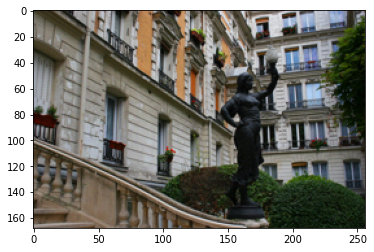

In [14]:
print(predd.max())
predd = np.clip(predd, 0, 1)*255
preddd = np.uint8(predd)
plt.imshow(preddd)

In [15]:
inp = lr_father.to(device)
print(inp.shape)
pred2 = model(inp)
pred3 = pred2.permute(0, 2, 3, 1).squeeze(0)
print(pred3.shape)

torch.Size([1, 3, 168, 256])
torch.Size([672, 1024, 3])


In [16]:
pred4 = pred3.cpu().detach().numpy()
print(pred4.dtype)

float32


In [17]:
print(pred4.max())

1.417816


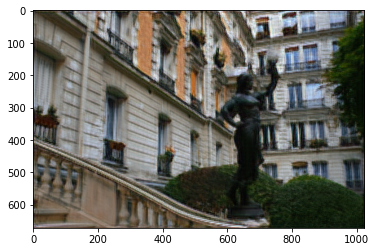

In [18]:
pred5 = np.clip(pred4, 0, 1)*255
pred6 = np.uint8(pred5)
plt.imshow(pred6)

In [19]:
pred6.shape

(672, 1024, 3)

In [21]:
cv2.imwrite(output_file, pred6[:,:,::-1])   

True